# Facial Keypoint Detection

## Problem Description

As explained on the [Kaggle platform](https://www.kaggle.com/c/facial-keypoints-detection), we seek to predict keypoint positions on face images. This is a precursor step to analysing faces for various specific purposes -

  * to track faces in images and video (for example, for cinematic motion capture)
  * to assess facial expressions, normal and dysmorphic
  * biometrics, which includes facial recognition

Ultimately our model can also be tested against 1,783 images of data hosted on the Kaggle platform. An RMS error measure will be determined by the platform using expected results it keeps secret.

__Inference__: We seek to predict the x,y coordinates of 15 facial keypoints using images 

__Model__: For the machine learning model we  will use Keras to set up a convolutional neural network solution. Keras sits on top of Tensorflow and greatly simplifies the process of building a model.

__Features__: Each image comprises 96x96 pixels. We have up to 7049 images with full or partial keypoints to work with. Feature transformation produces additional images with known (transformed) keypoints.

__Train__: Fit and Test. _steps to avoid overfitting_ : Dropout, Batch Normalization, Early stopping during fitting, Regularization (Activity reg., Weight reg.), Hyperparameter tuning
 - cost is a function of parameters (RMSE) ; objective minimizes cost. 

## Project Setup

In [87]:
#!pip install -U scikit-learn
#!pip install keras-tuner

# Making necessary imports
import os
import csv
import re
import copy
import random
import math
from math import sin, cos, pi
import cv2
import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import skimage.transform as sk

import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer, Activation, Conv2D, LeakyReLU, ELU, ReLU, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from keras.metrics import MeanAbsoluteError as mae
from keras.metrics import MeanAbsolutePercentageError as mape
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from keras.models import load_model     # for transfer learning
from keras.optimizers import SGD, RMSprop, Adagrad, Adam

# model tuning
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from kerastuner import HyperModel
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,KFold, cross_val_score
from keras.optimizers import SGD

In [88]:
# random seed for reproducibility
seed = 7
np.random.seed(seed)

## Read in the data

In [89]:
#check input files (when on Kaggle)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facial-keypoints-detection/test.csv
/kaggle/input/facial-keypoints-detection/training.csv


In [90]:
# Reading the datasets (when running th code on Kaggle)
Train_Dir = '../input/facial-keypoints-detection/training.csv'
Test_Dir = '../input/facial-keypoints-detection/test.csv'
df_train = pd.read_csv(Train_Dir)  
df_final_test = pd.read_csv(Test_Dir)

In [91]:
# Download the dataset directly from Kaggle (when running the code offline)
# ! conda install -y gdown
#import gdown
#train file
#url = 'https://drive.google.com/uc?id=1xAYQNxeFAp-_K5YIg_l2AIhUuFhI5qx9'
#output = 'training.csv'
#gdown.download(url, output, quiet=False)
#df_train = pd.read_csv("/kaggle/working/training.csv")

#test file
# url = 'https://drive.google.com/uc?id=11xpAqARwAM3FaX7zI8sN6hTzUOOi_Leq'
# output = 'test.csv'
# gdown.download(url, output, quiet=False)
# df_final_test = pd.read_csv("/kaggle/working/test.csv")

#IdLookup file
#url = 'https://drive.google.com/uc?id=1JK9jajM40uG14w9Eb1PcaUeOOybycy2v'
#output = 'IdLookupTable.csv'
#gdown.download(url, output, quiet=False)
#df_idlookup = pd.read_csv("/kaggle/working/IdLookupTable.csv")

In [92]:
# # Read training data (when running the code offline)
# df_train = pd.read_csv('training.csv')
# df_final_test = pd.read_csv('test.csv')

Train.csv identifies 3 sections of images:

* 1582 studio images - multiple well-framed face photos of a smaller number of people, possibly students
* 702 celebrity images - mostly sharp images of celebrities from the public domain
* 4765 other images - possibly web scraped - many of which might be rough scans of yearbook photos.

The Test.csv data comprises three sections, one after the other:

* 396 studio images - multiple well-framed face photos of a smaller number of people, possibly students
* 194 celebrity images - mostly sharp images of celebrities from the public domain
* 1197 other images - possibly web scraped - many of which might be rough scans of yearbook photos but also includes cartoons.

Having 67% "other" images highlights how important it will be to incorporate our "other" images from the training data (images with only 3-4 keypoints that also represent 67.6% of that dataset).

A quick review of the webscraped images shows what we're up against here, selected images below. Cartoons, sculpture, very blurry images, a full body painting, multiple faces, artworks, sunglasses, a child. But these are only some of the worst. Wish us luck!

## Exploratory Data Analysis
The poorer images with only 3-4 keypoints represent 32.4% of the dataset.

First we explore the Train.csv images with an unusual keypoint count:

In [93]:
df_train.head().T

0  \
left_eye_center_x                                                    66.0336   
left_eye_center_y                                                    39.0023   
right_eye_center_x                                                    30.227   
right_eye_center_y                                                   36.4217   
left_eye_inner_corner_x                                              59.5821   
left_eye_inner_corner_y                                              39.6474   
left_eye_outer_corner_x                                              73.1303   
left_eye_outer_corner_y                                                39.97   
right_eye_inner_corner_x                                             36.3566   
right_eye_inner_corner_y                                             37.3894   
right_eye_outer_corner_x                                             23.4529   
right_eye_outer_corner_y                                             37.3894   
left_eyebrow_inner_end_x                                             56.9533   
left_eyebrow_inner_end_y                                             29.0336   
left_eyebrow_outer_end_x                                             80.2271   
left_eyebrow_outer_end_y                                             32.2281   
right_eyebrow_inner_end_x                                            40.2276   
right_eyebrow_inner_end_y                                            29.0023   
right_eyebrow_outer_end_x                                            16.3564   
right_eyebrow_outer_end_y                                            29.6475   
nose_tip_x                                                           44.4206   
nose_tip_y                                                           57.0668   
mouth_left_corner_x                                                  61.1953   
mouth_left_corner_y                                                  79.9702   
mouth_right_corner_x                                                 28.6145   
mouth_right_corner_y                                                  77.389   
mouth_center_top_lip_x                                               43.3126   
mouth_center_top_lip_y                                               72.9355   
mouth_center_bottom_lip_x                                            43.1307   
mouth_center_bottom_lip_y                                            84.4858   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                           1  \
left_eye_center_x                                                    64.3329   
left_eye_center_y                                                    34.9701   
right_eye_center_x                                                   29.9493   
right_eye_center_y                                                   33.4487   
left_eye_inner_corner_x                                              58.8562   
left_eye_inner_corner_y                                              35.2743   
left_eye_outer_corner_x                                              70.7227   
left_eye_outer_corner_y                                              36.1872   
right_eye_inner_corner_x                                             36.0347   
right_eye_inner_corner_y                                             34.3615   
right_eye_outer_corner_x                                             24.4725   
right_eye_outer_corner_y                                             33.1444   
left_eyebrow_inner_end_x                                             53.9874   
left_eyebrow_inner_end_y                                             28.2759   
left_eyebrow_outer_end_x                                             78.6342   
left_eyebrow_outer_end_y                                             30.4059   
right_eyebrow_inner_end_x                                            42.7289   
right_eyebrow_inner_end_y                                             26.1

The df_test dataset contains only the Image data, no keypoints.

In [94]:
df_final_test.head()

ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...

In [95]:
print("Length of train data: {}".format(len(df_train)))
print("Number of Images with missing pixel values: {}".format(len(df_train) -
      int(df_train.Image.apply(lambda x: len(x.split())).value_counts().values)))
print("")
n_count = np.array(df_train.notnull().sum(axis=1))
frequencies = np.asarray(( np.unique(n_count, return_counts=True) )).T
for pts, counts in frequencies:
    print(counts, "images with", int((pts-1)/2), "keypoints:", np.flatnonzero(n_count==pts))

Length of train data: 7049
Number of Images with missing pixel values: 0

10 images with 3 keypoints: [2289 2321 2453 3173 3296 3447 4180 5556 6585 6859]
4755 images with 4 keypoints: [2284 2285 2286 ... 7046 7047 7048]
2 images with 5 keypoints: [2153 2186]
2 images with 8 keypoints: [1747 2137]
5 images with 9 keypoints: [1866 1877 1956 2036 2227]
3 images with 10 keypoints: [1620 1979 2095]
8 images with 11 keypoints: [1636 1731 1881 2039 2154 2175 2206 2239]
9 images with 12 keypoints: [1643 1646 1687 1834 1912 2090 2100 2148 2170]
28 images with 13 keypoints: [1652 1685 1703 1708 1717 1724 1737 1741 1742 1779 1795 1827 1874 1907
 1925 1938 1946 2020 2060 2101 2125 2144 2149 2161 2188 2199 2214 2265]
87 images with 14 keypoints: [ 210  350  499  512  810  839  895 1058 1194 1230 1245 1546 1548 1585
 1588 1598 1601 1605 1624 1626 1627 1629 1647 1654 1678 1679 1684 1693
 1719 1721 1723 1738 1744 1756 1759 1781 1782 1786 1797 1805 1837 1840
 1861 1876 1896 1919 1920 1939 1942 1957 196

We see 4,755 images have 4 x,y points. These are all numbered $ \ge$  2284.
* A further 10 images in this range have only 3 x,y points.

2,140 images have 15 x,y points. These are all numbered $\le$ 2283. within this range we also see:
* 2 images have only 5 x,y points.
* 2 images have only 8 x,y points.
* 5 images have only 9 x,y points.
* 3 images have only 10 x,y points.
* 8 images have only 11 x,y points.
* 9 images have only 12 x,y points.
* 28 images have only 13 x,y points.
* 87 images have only 14 x,y points.

We display the small number of images with 7, 11, 17, 19, 21, and 23 points to look for potential issues.

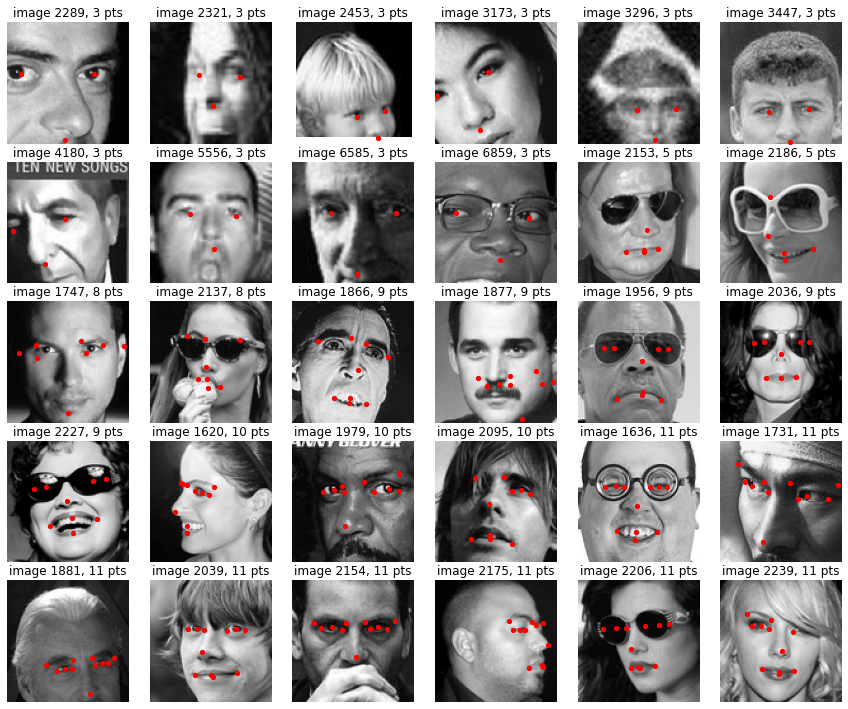

In [96]:
oddcounts = [ 7, 11, 17, 19, 21, 23 ]
pane = 1
plt.figure(figsize=(15,12.5))
plt.subplots_adjust(wspace=0.15, hspace=0.15)
for o in oddcounts:
    for i in np.flatnonzero(n_count==o):
        plt.subplot(5, 6, pane )
        plt.axis('off')
        plt.title("image " + str(i) + ", " + str(int((o-1)/2)) + " pts")
        image = np.array(df_train.iloc[i, 30].split()).astype(float).reshape(96,96)
        plt.imshow(image, cmap='gray')
        plt.scatter(df_train.iloc[i,0:30:2], df_train.iloc[i,1:31:2], s=18, color='red')
        pane += 1
plt.show()

Image 1877 is horribly wrong.

Image 2453 is scaled beyond 96x96 pixels. This suggests there exists points outside of the bounds of the image. Separate exploration of min/max (x,y) values shows all x and y values in the dataset lie between 0 and 96. The odd point above has y = 95.9356 which is outside of the range 0-95 represented by pixels, but within the range 0 to 96. We don't pursue this any further.

Sunglasses are a recurring challenge for picking keypoints. Examples: 1956, 2036, 2154, 2186, 

Images 1620 and 2175 are the only examples of side-profile in this set. We look for more in the 28 + 87 images missing just 1 or 2 points.

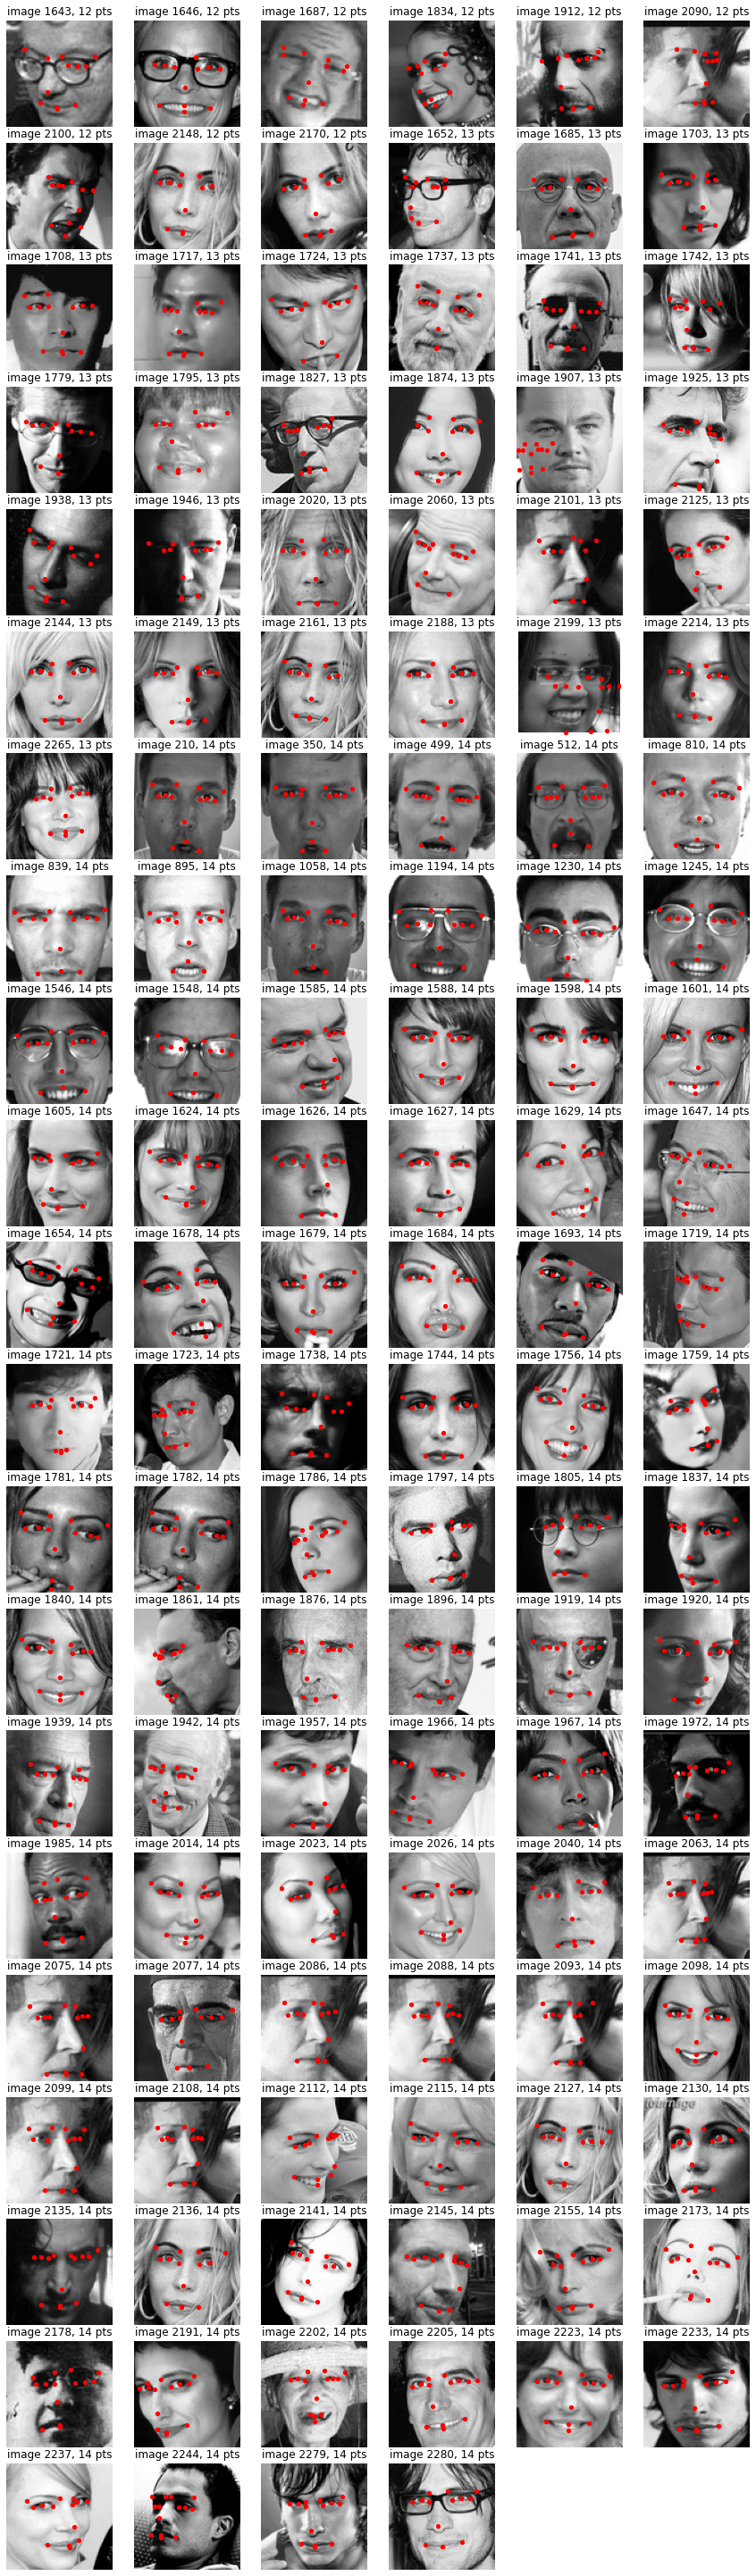

In [97]:
oddcounts = [ 25, 27, 29 ]
pane = 1
plt.figure(figsize=(15,52.5))
plt.subplots_adjust(wspace=0.15, hspace=0.15)
for o in oddcounts:
    for i in np.flatnonzero(n_count==o):
        plt.subplot(21, 6, pane )
        plt.axis('off')
        plt.title("image " + str(i) + ", " + str(int((o-1)/2)) + " pts")
        image = np.array(df_train.iloc[i, 30].split()).astype(float).reshape(96,96)
        plt.imshow(image, cmap='gray')
        plt.scatter(df_train.iloc[i,0:30:2], df_train.iloc[i,1:31:2], s=18, color='red')
        pane += 1
plt.show()

Image 2090 also has broken keypoints. Image 1861 has most of its keypoints despite being a profile image.

A missing point or two is usually the result of 3/4 profile faces. It is sometimes the result of a long fringe or deep side shadow. We would not seek to fake these points, many (but not all) are truly missing from the image.

## Cleaning & preparing the data for modeling

In [98]:
def reshape_inputs(X):
    ''' A function to reshape the input data in a way that each image is presented as a 96x96 matrix'''
    X_res = np.zeros(shape = (len(X), 96, 96, 1), dtype = np.float32)
    for i in range(len(X)):
        X_res[i] = np.array(X[i].split()).astype(float).reshape(96, 96, 1)
        
    # Normalize for further processing 
    X_res = np.array(X_res)/255
    
    return X_res

#####################################################################################################
def plot_facial_keypoints(x,y, color = 'b', title = 'labeled'):
    '''A function to plot the image with facial features located on it'''
    plt.imshow(x[:,:,0], cmap='gray')
    l = len(y)
    plt.scatter(y[list(range(0,l,2))], y[list(range(1,l+1,2))], c = color)
    plt.title(title)
    plt.show()

#### Splitting the dataset into the fully- and partially- populated sets

**Fully populated dataset (with all 15 keypoints labeled)**

The size of full dataset (after removing NaNs): (2140, 31)
The size of model-ready input matrix: (2140, 96, 96, 1), and output matrix: (2140, 30), regarding the fully-poulated data



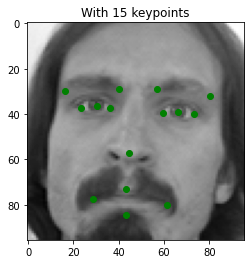

In [99]:
df_full = copy.deepcopy(df_train)           # make a deep copy of the original train set 
df_full.dropna(how = 'any', inplace=True)   # drop all NaN in the entire copied train dataset
df_full.reset_index(inplace = True)
df_full.drop(['index'], axis = 1, inplace = True)
print('The size of full dataset (after removing NaNs): {}'.format(df_full.shape))

# Splitting each dataset into the input (X) and output (Y) sets
Xf = df_full.iloc[:, -1]
Yf = df_full.iloc[:, :-1]

# We need to reshape the input data in a way that each image is presented as a 96x96 matrix
Xf1 = reshape_inputs(Xf)
Yf1 = np.array(Yf,dtype = 'float')

print('The size of model-ready input matrix: {}, and output matrix: {}, regarding the fully-poulated data\n'\
      .format(Xf1.shape, Yf1.shape))

# Plotting the first image in each dataset
n = 0
plot_facial_keypoints(Xf1[n], Yf1[n], 'g', 'With 15 keypoints')

# Get the list of all keypoints
keypoints_list_full = list(df_full.columns)[:-1]

#remove temp dataframe
del df_full

**Partially populated set (with only 4 keypoints labeled, but removing the wrongly labeled or less than 4 keypoints labeled images)**

The size of partial dataset (after removing NaNs): (7000, 9)
The size of model-ready input matrix: (7000, 96, 96, 1), and output matrix: (7000, 8), regarding the partially-poulated data



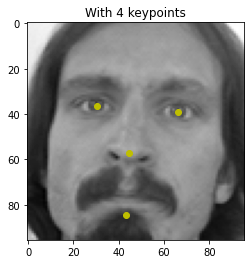

In [100]:
df_partial = copy.deepcopy(df_train)      # make a deep copy of the original train set 
df_partial.drop(df_partial.iloc[:, np.r_[4:20, 22:28]], axis = 1, inplace = True)   # only keep the four keypoints coordinates    
df_partial.dropna(how = 'any', inplace=True) # drop all NaN in the entire copied train dataset
df_partial.reset_index(inplace = True)
df_partial.drop(['index'], axis = 1, inplace = True)
print('The size of partial dataset (after removing NaNs): {}'.format(df_partial.shape))

# Splitting each dataset into the input (X) and output (Y) sets
Xp = df_partial.iloc[:, -1]
Yp = df_partial.iloc[:, :-1]

# We need to reshape the input data in a way that each image is presented as a 96x96 matrix
Xp1 = reshape_inputs(Xp)
Yp1 = np.array(Yp,dtype = 'float')

print('The size of model-ready input matrix: {}, and output matrix: {}, regarding the partially-populated data\n'\
      .format(Xp1.shape, Yp1.shape))

# Plotting the first image in each dataset
n = 0
plot_facial_keypoints(Xp1[n],Yp1[n], 'y', 'With 4 keypoints')

# Get the list of all keypoints
keypoints_list_partial = list(df_partial.columns)[:-1]
#remove temp dataframe
del df_partial

In [101]:
# delete df_train to save computation memory
del df_train

## Data Augmentation

Data Augmentation can help to increase the diversity of data available for training models and reduce overfitting on models. Since around 70% of data is missing, we can use some data augmentation techniques such as brightness adjustment, rotation, shifting, adding noise, and horizontal flipping to increase our training dataset without collecting new data. We also need to re-calculate the position of keypoints if rotation, shifting,and horizontal flipping techniques are used to transform the images. For brightness adjustment and adding noise techniques, the position of keypoints remain the same.


1. Brightness Adjustment: 
   Light condition manipulation method could help boost diversity of input images. We create a function bright_adj(images, adj_param) to either increase or decrease the brightness of the image.
                       the adjustment parameter would dictate the type of operation:
                       for increasing brightness: adj_param > 1 
                       for decreasing brightness: adj_param < 1 
        
2. Adding noise : Add some random noise to the image. In fact, noise helps to regularize training and prevents the model from overfitting.


3. Flipping(Horizontal) : In a horizontal flip, we rotate the image about a verticle line passing through its center. The pixels in the right half of the transformed image and the left half of the original image are mirror images of each other about the central line.


4. Shifting : Because images are not always centered, then shifting is needed. By shifting the images, we can change the position of the object in the image and hence give more variety to the model. If we shift in (x,y) direction, let it be (t_x,t_y), we can create the transformation matrix **M** as follows:

     M = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y  \end{bmatrix}

    We make it into a Numpy array of type np.float32 and pass it into cv2.warpAffine() function.  After the shift operation, an object present at a location (x,y) in the input image is shifted to a new position (X = x+dx, Y = y+dy).


5. Rotation :One common data augmentation technique is random rotation. We can manually pick rotation direction (0 means clockwise and 1 means counterclockwise)by passing parameter "direction" to function rotate, if direction is not defined, it will generate direction randomly in function. It also randomly choose number of degrees between [0,20]. The image pixel matrix X and labels are rotated using X•R, where **R** is the rotation matrix. The images are padded with their mean pixel value, along the edges where parts of the image were rotated out of bounds.

    𝑅 =  \begin{bmatrix} 𝑐𝑜𝑠(𝜃) & 𝑠𝑖𝑛(𝜃) \\ 𝑠𝑖𝑛(𝜃) & 𝑐𝑜𝑠(𝜃)\end{bmatrix}

 
6. Blur:  Since our images may have blur involved, all images in training, validation, and testing should be blurred in preprocessing. We randomly generate the blur value. It defines the value of the standard deviation to the Gaussian function, i.e., how many pixels on the screen blend into each other; thus, a larger value will create more blur.


#### Functions for data augmentation:
>  Brightness adjustment, Adding random noise, Blurring, Flipping, Random shifting, and Rotation

In [102]:
# Brightness adjustment
def bright_adj(images, adj_param):
    '''a function to either increase or decrease the brightness of the image'''
    #create a copy version of image data
    img = copy.deepcopy(images)
    
    # build a empty list for transformed images
    images_adj = []
    
    # the adjustment parameter would dictate the type of operation:
        #for increasing brightness: adj_param > 1 
        #for decreasing brightness: adj_param < 1 
    images_adj = np.clip(img * adj_param, 0.0, 1.0)
    
    #return tranformed images
    return images_adj

In [103]:
# Adding noise to the image
def add_noise(images, ratio = 0.05):
    
    # build a empty list for transformed images
    noisy_images = []
    
    #loop every images and add some random noise to the image
    for i in range(len(images)):
        noise = np.random.randn(96,96,1)
        noisy_image =  images[i] + ratio * noise  
        noisy_images.append(noisy_image)
    
    #return tranformed images
    return noisy_images

In [155]:
#Blur

def blur(images):
    
    #randomly generate the blur value (how many pixels on the screen blend into each other; thus, a larger value will create more blur.)
    blur_value = random.randint(0,5) * 2
    
    #create empty list for blurred images
    blurred_images = []
    
    #blur images
    for image in images:
        blurred_image = cv2.blur(image,(blur_value, blur_value))
        blurred_images.append(blurred_image.reshape(96,96,1))
    
    return np.array(blurred_images).reshape(len(images), 96, 96, 1)

In [105]:
# Flipping the image
def flipp(images, keypoints):
    #Locate column index for left and right
    left_x_keypoints_index = [0, 4, 6, 12, 14, 22]
    right_x_keypoints_index = [2, 8, 10, 16, 18, 24]
    #create a copy version of image and keypoints data
    inputs = copy.deepcopy(images)
    targets = copy.deepcopy(keypoints)
    # perform horizontal flipping
    inputs = np.flip(inputs, 2)
    # flip the keypoints
    for i in range(len(targets)):
        for j in range(len(targets[i])):
                if j%2 == 0:
                    temp = 96 - keypoints[i][j]
                    #Also flip the column(eg, left_eye_center_x to right_eye_xenter_x)
                    if j in left_x_keypoints_index:
                        right_keypoints_index = right_x_keypoints_index[left_x_keypoints_index.index(j)]
                        targets[i][right_keypoints_index] = temp
                        targets[i][right_keypoints_index+1] = keypoints[i][j+1]
                    elif j in right_x_keypoints_index:
                        left_keypoints_index = left_x_keypoints_index[right_x_keypoints_index.index(j)]
                        targets[i][left_keypoints_index] = temp
                        targets[i][left_keypoints_index+1] = keypoints[i][j+1]
                    else:
                        targets[i][j] = temp
    #return tranformed images and keypoints
    return inputs, targets

In [106]:
# Shifting the image and labels 

def shift(images, keypoints,shift_x = 0, shift_y = 0):
    
    #random generate nonzero-direction 
    while shift_x == 0 and shift_y == 0:
        shift_x = random.randint(-10, 10)  
        shift_y = random.randint(-10, 10)
    
    #initialize empty lists to obtain transformed data later
    shifted_images = []
    shifted_keypoints = []
    
    #create transformation matrix M
    M = np.array([[1,0,shift_x],[0,1,shift_y]], dtype=np.float32)
    
    for image, keypoint in zip(images, keypoints):
        
        #shift images
        shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
        # create empty list for shifted keypoints
        shifted_keypoint = []
        
        # generate new X = x+dx, Y = y+dy
        for index, point in enumerate(keypoint):
            if index % 2 == 0:
                shifted_keypoint.append(point+shift_x)
            else:
                shifted_keypoint.append(point+shift_y)
                
        #make sure all keypints are in the image    
        if np.all(0.0<np.array(shifted_keypoint)) and np.all(np.array(shifted_keypoint)<96.0):
            shifted_images.append(shifted_image.reshape(96,96,1))
            shifted_keypoints.append(shifted_keypoint)
            
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    
    #return transformed images and keypoints
    return shifted_images, shifted_keypoints

In [107]:
# Rotating images and labels either CW or CCW
def rotate(images, keypoints, direction = None):
    
    #If direction is not defined, randomly pick the direction.(0 means clockwise and 1 means counterclockwise)
    if direction == None:
        direction = random.randint(1,0)
    
    #make a copy of images and keypoints
    inputs = images.copy()
    targets = keypoints.copy()
    
    # randomly generate number of degrees
    angle = np.random.randint(20)
    
    if direction != 0:
        angle =  360 - angle
    
    #rotate the images
    for i in range(len(inputs)):
        inputs[i, :, :, 0] = sk.rotate(inputs[i, :, :, 0], angle)
    
    #rotate keypoints
    alpha = -angle*np.pi/180

    for i in range(len(targets)):     
        targets[i] = targets[i] - 96/2
        for j in range(len(targets[i])):
            if j%2 == 0:
                #https://stackoverflow.com/questions/52145755/calculate-new-position-of-coordinates-with-numpy
                x_old = targets[i][j]
                y_old = targets[i][j+1]
                targets[i][j] = x_old * np.cos(alpha) - y_old * np.sin(alpha)
                targets[i][j+1] = x_old * np.sin(alpha) + y_old * np.cos(alpha)
        targets[i] = targets[i] + 48
    
    #return transformed images and keypoints
    return inputs, targets

### Data augmentation results:

> #### Fully-populated data (FPD)
>> in this section, we will apply all the previously defined augmentation methds to the FPD one-by-obe, and consequently concatenate them all together. 

Size X:  (16895, 96, 96, 1)
Size Y:  (16895, 30)


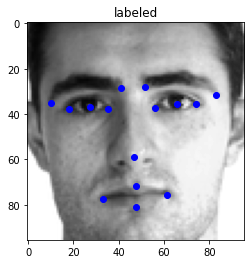

In [156]:
# Brightness increasing
Xf_br_inc = bright_adj(Xf1, 1.8)

################################################################################
# Adding random noise
Xf_noise = add_noise(Xf1, .07)

################################################################################
# Blurring
Xf_blur = blur(Xf1)

################################################################################
# Flipping
Xf_flip, Yf_flip = flipp(Xf1, Yf1)

################################################################################
# Shifting
Xf_shift, Yf_shift = shift(Xf1, Yf1)

################################################################################
# Rotation
Xf_rot1, Yf_rot1 = rotate(Xf1, Yf1, 1)
Xf_rot0, Yf_rot0 = rotate(Xf1, Yf1, 0)

################################################################################

# adding all data augmentation into the original dataset
Xfa = np.concatenate((Xf1, Xf_br_inc, Xf_noise, Xf_blur, Xf_rot1, Xf_rot0, Xf_shift, Xf_flip), axis=0, out=None)
Yfa = np.concatenate((Yf1, Yf1      , Yf1,      Yf1,     Yf_rot1, Yf_rot0, Yf_shift, Yf_flip), axis=0, out=None)

################################################################################

# Shuffle the enhanced data
Xfas, Yfas = shuffle(Xfa, Yfa, random_state = 1234)

print('Size X: ', Xfas.shape)
print('Size Y: ', Yfas.shape)
plot_facial_keypoints(Xfas[1], Yfas[1])

################################################################################
# Delete unused data to reduce memory
del Xfa, Xf_br_inc, Xf_noise, Xf_flip, Xf_shift, Xf_rot1, Xf_rot0
del Yfa, Yf_flip, Yf_shift, Yf_rot1, Yf_rot0
################################################################################

> ### Partially-populated data (PPD)
>> Given that the PPD is almost tripled size the FPD, applying and adding all augmentation methods to that will create a huge dataset that will surpass the limit of our our computational resource and thus we need to be selective of applying the augmentation methods. Having ideas from EDA, we decided to consider blurring, shifting, and CW rotation only

Size X:  (27329, 96, 96, 1)
Size Y:  (27329, 8)


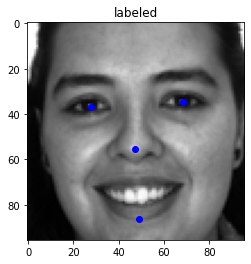

In [273]:
# Blurring
Xp_blur = blur(Xp1)
# ################################################################################
# # Shifting
Xp_shift, Yp_shift = shift(Xp1, Yp1)

# ################################################################################
# # Rotation
Xp_rot1, Yp_rot1 = rotate(Xp1, Yp1, 1)

################################################################################
# include all data augmentation into the original dataset
Xpa = np.concatenate((Xp1, Xp_blur, Xp_shift, Xp_rot1), axis=0, out=None)
Ypa = np.concatenate((Yp1, Yp1    , Yp_shift, Yp_rot1), axis=0, out=None)

################################################################################
# Shuffle the data
Xpas, Ypas = shuffle(Xpa, Ypa, random_state = 12345)
print('Size X: ', Xpas.shape)
print('Size Y: ', Ypas.shape)
plot_facial_keypoints(Xpas[1], Ypas[1])

################################################################################
# Delete unused data to reduce memory
del Xp_blur, Xp_rot1, Xp_shift, Xpa
del Yp_rot1, Yp_shift, Ypa

## Eigenfaces and "Eigen-keypoints"

### An ambitious but unsuccessful attempt to use PCA for data augmentation to infill missing keypoints 

We tested the possibility of using an eigenfaces (principal components of a set of images) workflow to populate keypoints on these images. Eigenfaces created from our input faces represent the variation present in our original faces. The original faces can be restored from these eigenfaces. So long as there are fewer eigenfaces than images, then each eigenface and restored image is a combination of other images. Thus our final images contain traces of other images in them. If we are able to carry keypoint data through singular value decomposition and back, and scale it up appropriately, then we might suppose we will introduce keypoint information from 'related images' where previously there was none.

__tldr; It didn't work.__

The project showed promise for quite some time so it is included here. We hope to push this research further after the end of the course, to either produce keypoints or prove conclusively why this might be a bad idea.


### Prior work

An eigenfaces-with-keypoints workflow has been applied to this dataset before. _Y. Wang and Y. Song, [Facial Keypoints Detection](http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf)_, unpublished 2014 Stanford student project applied supervised learning to 125 eigenfaces derived from 5,639 images. In this process, the keypoints are described as being translated into the PCA space, being the weighted sum of keypoints from the 5000 images. This weighting is described as: $ \| \phi_j \|_2^2 = \sum_{i=1}^{5639} \phi^2_{ij} = 1 $ . 

This process did not impute keypoints back to images. Instead supervised learning applied directly to these images determined a model that was applied on 20% of the original images that were set aside for testing. A flowchart suggests a model that picked keypoints using 125 principal component images was applied directly to the test images. It was not enough information to reproduce the workflow.

This unpublished paper does not describe the keypoints as being centered around a mean. Our own work showed this to be crucial to reducing the RMSE. The authors go on to describe their results in terms of the Kaggle leaderboard; however the process was run only on `train` Kaggle images for keypoints that were known (for 2/3 of the images this is only 4 keypoints). As this does not consider how well non-core keypoints resolve on the poorer quality images (possible on Kaggle) it is not a valid comparison. We do not rely on this unpublished paper.

### Process

We seek to add keypoint information from the well-populated images (up to image number 2283 in the original dataset) to later images that have 4 or less keypoints defined, through a two step process. 

* Step 1: PCA
 - with keypoints and unitary weights added as features to the images prior to PCA, weights permitting keypoint restoration
 - with keypoints mapped to eigenfaces after PCA of just the images using the eigenvectors as weights
 - with keypoints chosen for eigenfaces after PCA of just the images based on maximum eigenvector contribution

* Step 2: Reconstruction
 - with new keypoints mapped from the eigenfaces using the eigenvectors as weights

> _What about images that are meant to have less than a full complement of keypoints?_
> - The second PCA step above 'choosing' keypoints could conceivably honour such situations but otherwise this process will not honour such input so would best be discarded. This is another area for future work.

Already we describe three different ways of creating "eigenkeypoints" (key points linked to eigenfaces). As conversion of images in each direction uses the same Single Value Decomposition it is possible that this intermediate step is the wrong approach here. But we began with the vision of keypoints-with-images traveling to PC space and back. Future work will reconsider this.


### Algorithm

The SVD algorithm described by [Nev Acar](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184) was used as a basis for the process. The reconstruction process uses a compute-intensive one-time calculation of the dot product of the centered data with the transposed components, both outputs from the first-step PCA process. Unfortunately this calculation was inserted inside a loop that runs once for every image. Moving the calculation outside the loop made the process run 7049 times faster. Wish we spotted this sooner.

> _Do not try this at home_
```python
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)     # however this does not change for each image!
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
recovered_images=[reconstruction(Y, C, M, h, w, i) for i in range(len(images))]
```

Since 4 points in the images are populated we can calculate a cost function to measure our success, at least on those points.

PCA could also be used to eliminate noise in the images however results would be different for each new test dataset. The simpler blur process described above was used instead.

> _Could you not predict the missing keypoints of the 4-keypoint images from the original images using machine learning?_
> * We could. It might even be better. But with all the time spent on eigenfaces we ran out of time.


> _Since your keypoints are a weighted combination of prior keypoints rather than a prediction, does the lack of potential for extrapolation of keypoints to unknown parts of the image limit the range of possible webscraped images you can use?_
> * Data augmentation ('shifts') before this process could allow for more extreme keypoint locations.

#### Workflow 1:  PCA with included keypoints

Our input data uses both the full (15-keypoint) and partial (4-keypoint) datasets described above.

```python
# We use all of the 'full' (15-keypoint) and 'partial' (4-keypoint) images.
Xall = np.concatenate((Xf, Xp), axis=0, out=None)
Yall = np.concatenate((Yf, Yp), axis=0, out=None)
```
The keypoints are prepended to each image as additional features. To prevent these features dominating image variance, and thus the PCA process, we multiply the coordinate values by 0.0001.

We also add a weight feature for every keypoint. If the keypoint is valid the weight is 0.0001. Otherwise it is zero. If a keypoint contributes to an eigenface it will be reduced by an unknown amount. But these weights will be reduced the same amount as any image makes its impact felt by a whole-image scalar weight. So we can simply scale the keypoints back up by the weights once we're done. This is intuitive, not proven mathematically...

```python
# Create an empty list that will contain the extended images 
Xallext = []
# Iterate over each row (image) in the training data
for i in range(len(Xall)): 
    image = []
    # For each image, we start with the x,y coordinates shrunk down by a factor of 10,000
    image = list(Yall[i] / 10000)
    # Then we add a weight factor feature for every coordinate, 0.0001 for known keypoints,
    # zero for missing keypoints
    image.extend([ 0.0 if math.isnan(val) else 0.0001 for val in Yall[i] ])
    # our last set of features is the image vector itself, derived a string of numbers.
    image.extend(list(np.array(Xall.iloc[i, 30].split()).astype(float)))
    Xallext.append(image)
Xallext = np.array(Xallext)
# Set all nulls to zero - this step sets null keypoints as (0,0). Nulls were already weighted as zero.
np.nan_to_num(Xallext, copy=False)
```

We are ready to apply PCA. However the SVD process implies that all features (pixels or keypoint coordinates) are centered. This means each feature has an average of zero. However if we center the coordinates we can no longer simply scale them back up using the cumulative weight since both coordinates and weights would now have negative values, and no longer work cumulatively since subtraction is not commutative. Further our null data would no longer have an identity (zero) weight. So we simply cannot means-center the keypoints and weights. It is hoped that having very small values will avoid instability in our SVD matrix operations. This is left as an exercise for further study. The prior work (above) identified that 125 principal components captured a lot of the variance in the images. Combinatorially, this still allows for a huge variety of keypoint combinations when converting back. If the workflow actually _worked_ then the known 4-points could be used to optimize the n_components hyperparameter. We did not get that far since results were always very poor.

```python
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    print(mean[0:60])
# The all-important centering process - we center the pixel values but we don't center the
# coordinate values and corresponding weights, as it would make real values impossible to restore.
    mean[0:60] = 0.0
    centered_data = X - mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return S, projected, components, mean, centered_data

n_components = 125
S, P, C, M, Y = pca(Xallext, n_pc=n_components)
```
We take a look at the results - the first 15 eigenfaces with their "eigenkeypoints":
```python
# eigenfaces drops the keypoints, merely for show
eigenfaces = C[:, 60:].reshape((n_components, 96, 96))
# prepare to plot the first 15 eigenfaces with keypoints
plt.figure(figsize=(15,10))
pane = 1
for i in range(15):
    plt.subplot(3, 5, pane )
    plt.axis('off')
    plt.title(str(i))
    image = np.array(eigenfaces[i])
    plt.imshow(image, cmap='gray')
    # divide each diluted keypoint by its weight to restore its value
    delta = np.divide( C[i, 0:30], C[i, 30:60] )
    keypoints = delta.reshape(2,15)
    # this doesn't work all that well. Discard any keypoints projected outside the image
    good_keypoints = []
    for j in range(15):
        if keypoints[0,j] < 96 and keypoints[0,j] > 0 and keypoints[1,j] < 96 and keypoints[1,j] > 0:
            good_keypoints.append([ keypoints[0,j], keypoints[1,j] ])
    good_keypoints = np.array(good_keypoints)
    # if any keypoints remain, plot them
    if len(good_keypoints):
        plt.scatter(good_keypoints[:,0], good_keypoints[:,1], s=2, color='red')
    pane += 1
plt.show()
```
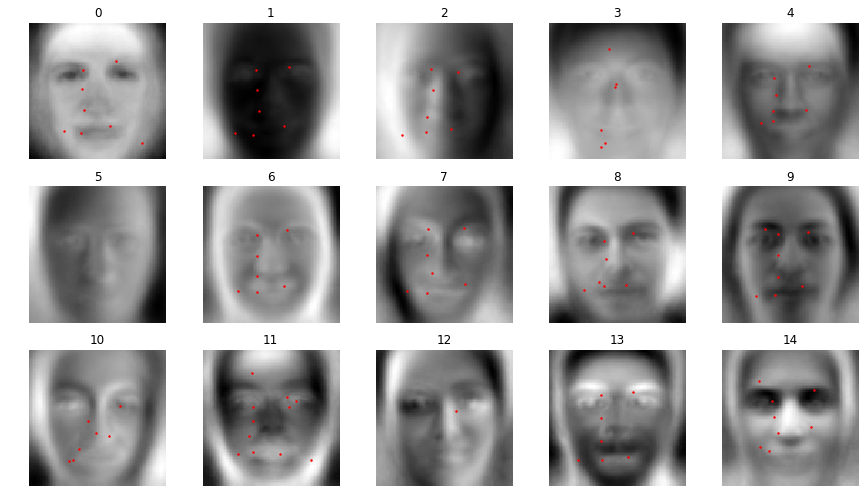

The "eigenkeypoints" do not appear quite where you might expect them to appear. It is possible the weights needed to be squared. It is possible the non-centered coordinates and means caused issues. It is possible that representing keypoints in the eigenface domain has diminishing returns, since it is more important that the data translates meaningfully back into the original image space. Further work needed.

But we can at least appreciate how much variance within the images is captured in these eigenfaces.
```python
var_explained = np.round(S**2/np.sum(S**2), decimals=6)
cumulative = np.cumsum(var_explained)
# plot the cumulative function
plt.plot(range(250), cumulative[0:250], c='blue')
plt.show()
print("95% of the image variance is explained by 235 eigenfaces. cum(235) =",
      round(cumulative[235],5))
```
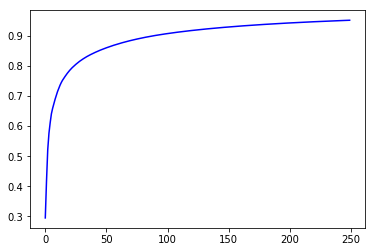
```python
95% of the image variance is explained by 235 eigenfaces. cum(235) = 0.95008
```
We convert the images back to regular images and see where our keypoints end up. Note the weights are ultimately calculated outside of the loop, once, prior to the loop.
```python
def reconstruction(C, M, w, image_index):
    centered_vector = np.dot(w[image_index, :], C)
    recovered_image = (M + centered_vector)
    return recovered_image
weights = np.dot(Y, C.T)
recovered_images = [ reconstruction(C, M, weights, i) for i in range(len(Xall)) ]
recovered_images = np.array(recovered_images)
```
Plotting these images showed the process needs more work. The blue points represent the input data, with 4 known keypoints on each of these images.

```python
plt.figure(figsize=(10,10))
pane = 1
for i in range(4000, 4016):
    plt.subplot(4, 4, pane )
    plt.axis('off')
    plt.title(str(i))
    image = np.array(recovered_images[i, 60:]).reshape(96,96)
    plt.imshow(image, cmap='gray')
    points = np.divide(recovered_images[i, 0:30], recovered_images[i, 30:60])
    good_points = []
    for j in range(15):
        if points[j*2] < 96 and points[j*2] > 0 and points[j*2+1] < 96 and points[j*2+1] > 0:
            good_points.append([ points[j*2], points[j*2+1] ])
    good_points = np.array(good_points)
    # blue is original points
    plt.scatter(df_train.iloc[i,0:30:2], df_train.iloc[i,1:31:2], s=18, color='blue')
    plt.scatter(good_points[:, 0], good_points[:, 1], s=18, color='red')
    pane += 1
plt.show()
```
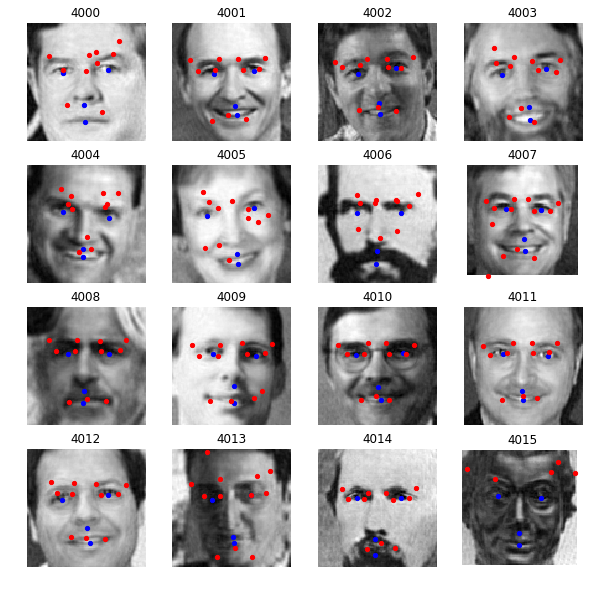
THe four keypoints previously known, existed for all images, and were maintained through this process, were imaged the worst (frequently off the edges of the image). This was the best of many attempts so a new approach was devised.

#### Workflow 2: PCA with eigenvector-weighted keypoints

Considering that integrating keypoints and weights into the images was a little too black-box, with unknown side-effects, a new approach was devised to use the SVD matrices more directly to estimate keypoints.

Keypoints are calculated for each eigenface after PCA using eigenvector contributions as weights.

This turned into a race to the mean, with all interesting variation washing out. At this point the jobs were still taking eight hours to run so we quickly moved on to a third workflow, to capture just the most 'interesting' keypoints (see below).

However this workflow is worthy of further work. While absolute weights were applied, they perhaps should have been squared (this was actually tested, and was not bad, but at that time there was no clear justification for a power of 2).

```python
# weights link our principal components to our input 15-point images 
im_weights = np.abs(P[0:len(Yf), :])
# scale the weights to sum to one, across the images
im_weights = im_weights/im_weights.sum(axis=0, keepdims=1)
im_weights.shape
# kp_means is the mean values of the keypoints based on full-point images
kp_means = np.mean(Yf)
# calculate the eigenkeypoints
eigen_kp = [ [ 0.0 for i in range(30) ] for face in range(len(eigenfaces)) ]
for face in range(len(eigenfaces)):
    for i in range(30):
        eigen_kp[face, i] = input_keypoints[np.argmax(im_weights[:, face]), i]
for face in range(len(eigenfaces)):
    eigen_kp[face, :] = eigen_kp[face, :] + kp_means
```


#### Workflow 3: PCA with top-engenvector keypoints

a final workflow was devised where the keypoints copied across to the eigenface were copied directly from the input full-15-keypoint image that generated the largest weight. This is certainly a shortcut. But considering PCA captures an image of maximum variance across all images at each step, we might also consider a maximum keypoint set. This is not expected to work perfectly. But given the total lack of detail in the previous process, at least this offers to present answers with variation!

For interest sake, this workflow is first documented with a hugely reduced dataset to facilitate a clearer understanding of what is happening (as well as run really fast). We begin with just 5 15-keypoint images and 7 4-keypoint images, and translate these with a 3-component PCA.

```python
X_12 = np.concatenate((Xf.iloc[0:5, :], Xp[0:7, :]), axis=0, out=None)
Y_12 = np.concatenate((Yf.iloc[0:5, :], Yp[0:7, :]), axis=0, out=None)
```
Quick display of these images, with red dots for 4-keypoint images:
```python
pane = 1
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.15, hspace=0.15)
colors = ['yellow', 'cyan', 'lime', 'blue', 'orange', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
color = 0
for i in range(len(X_12)):
    plt.subplot(3, 4, pane )
    plt.axis('off')
    plt.title("image " + str(i))
    image = np.array(X_12.iloc[i, 30].split()).astype(float).reshape(96,96)
    plt.imshow(image, cmap='gray')
    plt.scatter(X_12.iloc[i,0:30:2], X_12.iloc[i,1:31:2], s=18, color=colors[color])
    color += 1
    pane += 1
plt.show()
```
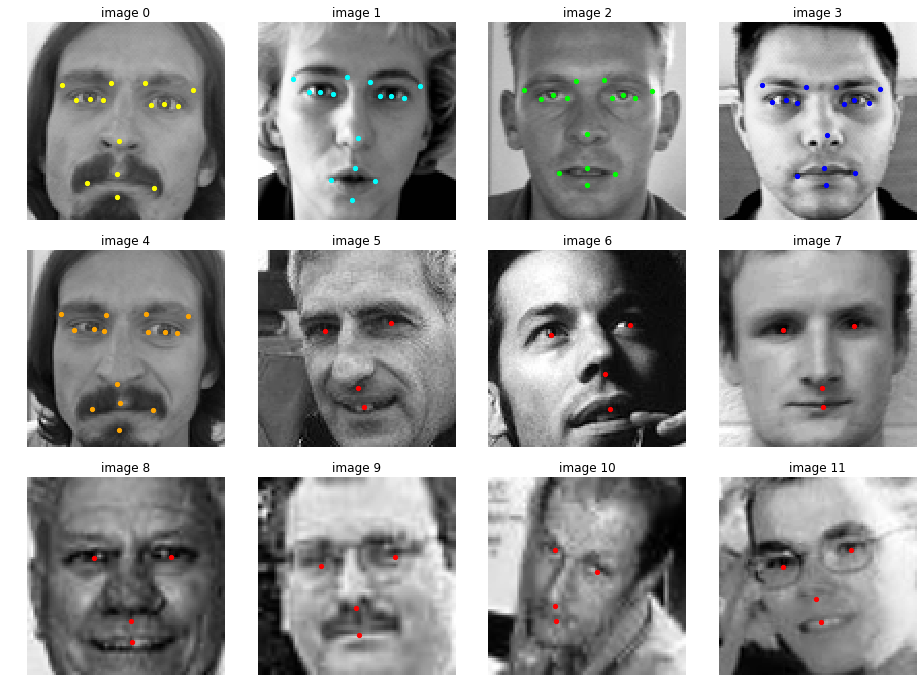
```python
def pca(X, n_pc):
    mean = np.mean(X, axis=0)
    centered_data = X - mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    return S, projected, components, mean, centered_data
n_components = 3
S, P, C, M, Y = pca(df_math_images, n_pc=n_components)
```
```python
eigenfaces = C.reshape((n_components, 96, 96))
pane = 1
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.15, hspace=0.15)
colors = ['yellow', 'cyan', 'lime', 'blue', 'orange', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
for i in range(3):
    plt.subplot(1, 3, pane )
    plt.axis('off')
    plt.title("image " + str(i))
    plt.imshow(eigenfaces[i], cmap='gray')
    # this time we show all the possible keypoint distributions behind the 12 input images
    for pts in range(12):
        plt.scatter(X_12.iloc[pts,0:30:2], X_12.iloc[pts,1:31:2], s=18, color=colors[pts])
    pane += 1
plt.show()
```
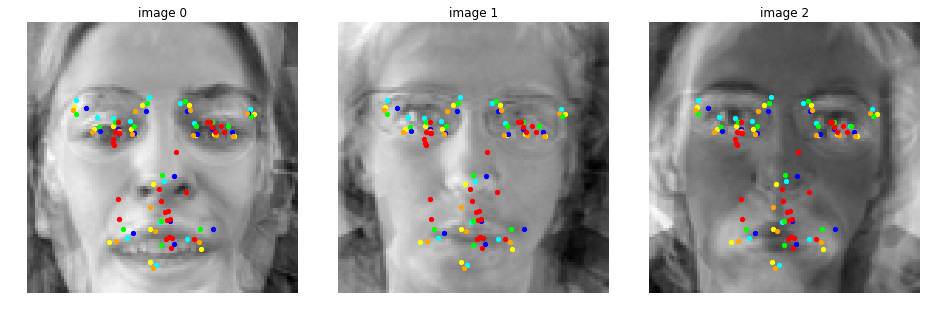

Calculate the weights 
```python
# 0:5 is the 15-pointer images, any of which could contain our preferred keypoint set
im_weights = np.abs(P[0:5, :])
# scale the weights to sum to one, across the images
im_weights = im_weights/im_weights.sum(axis=0, keepdims=1)
# determine the eigenkeypoints from the image that has the highest image weight in the eigenface
eigen_kp = [ [ 0.0 for i in range(30) ] for face in range(len(eigenfaces)) ]
eigen_kp = np.array(eigen_kp)
for face in range(len(eigenfaces)):
    for i in range(30):
        eigen_kp[face, i] = input_keypoints[np.argmax(im_weights[:, face]), i]
for face in range(len(eigenfaces)):
    eigen_kp[face, :] = eigen_kp[face, :] + kp_means
```
And then plot them out.
```python
```python
# ff is the first four-pointer image
ff = 5
im_weights = np.abs(P[0:ff, :])
# scale the weights to sum to one, across the images
im_weights = im_weights/im_weights.sum(axis=0, keepdims=1)
im_weights
```
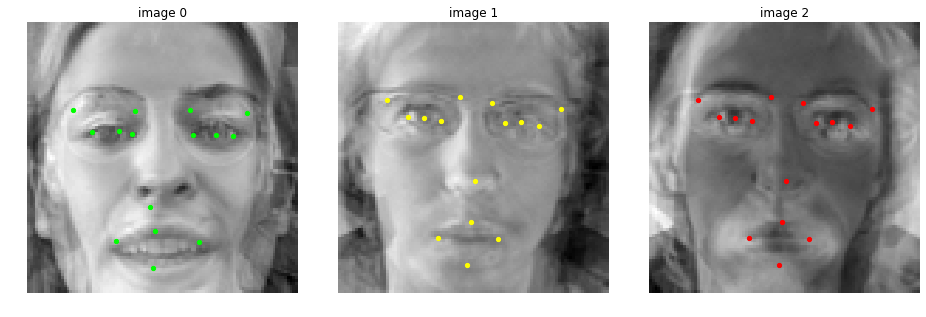

The faces are pretty blurry, with just 3 principal components for 12 faces we might expect a lot of the variance of the images is lost. We also see the same keypoints were chosen for two of the images. If we did further work on this we may want to understand how often this happens.

We reconstruct the images:
```python
def reconstruction(C, M, weights, image_index):
    centered_vector = np.dot(weights[image_index, :], C)
    recovered_image = (M + centered_vector)
    return recovered_image
weights = np.dot(Y, C.T)
recovered_images = [ reconstruction(C, M, weights, i) for i in range(len(X_12)) ]
recovered_images = np.array(recovered_images)
```
We rebuild the keypoints using weighted combination of eigenface keypoints (which in turn were the keypoints associated with the largest weight):
```python
kp_weights = np.abs(weights)
kp_weights = kp_weights/kp_weights.sum(axis=1, keepdims=1)
for face in range(len(eigen_kp)):
    eigen_kp[face, :] = eigen_kp[face, :] - kp_means

n_faces, n_eigenfaces = kp_weights.shape
recovered_keypoint = np.array( [ [ 0.0 for i in range(30) ] for face in range(n_faces) ] )
for face in range(n_faces):
    for e_face in range(n_eigenfaces):
        recovered_keypoint[face] += eigen_kp[e_face, :] * kp_weights[face, e_face]
for kp in range(len(recovered_keypoint)):
    recovered_keypoint[kp, :] = recovered_keypoint[kp, :] + kp_means
```
And display the 4-point images with their new 15-point facial points.
```python
pane = 1
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.15, hspace=0.15)
colors = ['lime', 'yellow', 'red']
for i in range(7):
    plt.subplot(2, 4, pane )
    plt.axis('off')
    plt.title("image " + str(i))
#     image = np.array(eigenfaces[i, :, 2].split()).astype(float).reshape(96,96)
    plt.imshow(recovered_images[i].reshape(96,96), cmap='gray')
#     for j in range(3):
    plt.scatter(recovered_keypoint[i,0:30:2], recovered_keypoint[i,1:31:2], s=18, color='red')
    pane += 1
plt.show()
```
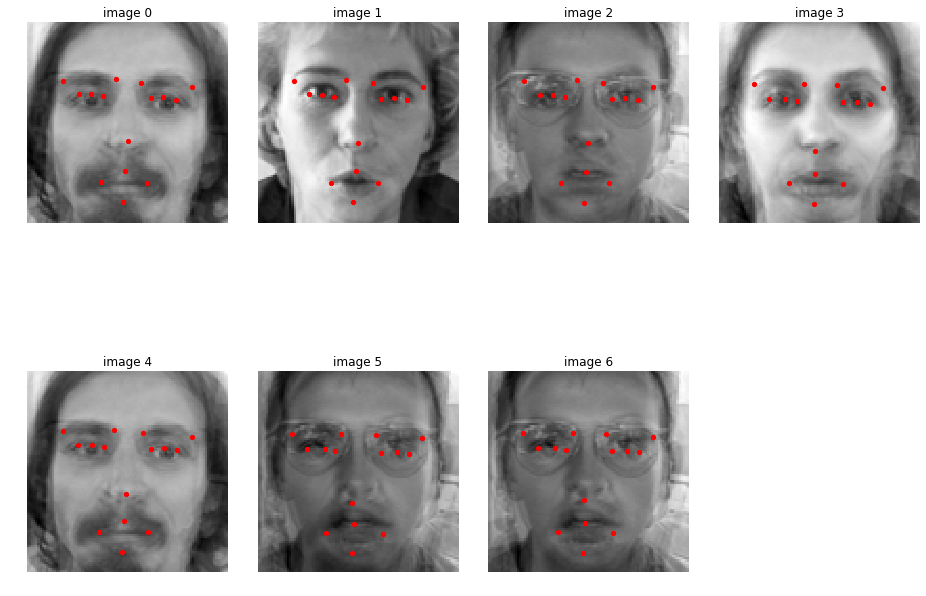
The concepts are clear. The results are off, but we've worked with only 12 input images.

Rerunning with 1000 n_components, the keypoints in the final images are all very close to the mean, and do not align with the images. At this point we run out of time, but we have a mountain of experience now just begging for further analysis.

## Build and train the CNN model in Keras

### _Model training_

**Model architecture:**

To build our CNN model, we adopted a LeNet [1] architecture in the form of: input → n x (conv2d → maxpool2d) → dense → output.  In detail, our model is structured as follows:
* Input layer: 96x96x1
* Hidden layers:
    * Convolutional layers (3+): each convolutional layer is composed of three layers as stacked as follows:
        * Conv2D layer (with different and descending kernel sizes for different layers, and stride of (1,1))
        * Activation: for all Conv2D layers, we use the **Leaky ReLU** activation function for two reasons:
            * to overcome the so-called _dying ReLU_ problem by preventing zero-slopes.  
            * to accelerate the learning process by keeping the mean activation close to zero.
        * Batch Normalization
        * Max pooling (with pool size of 2x2, stride of (1,1))
    * Flatten
    * Dense unit
    * Drop out
* Output layer: 30x1    
    
[1] Y. LeCun, L. Bottou, Y. Bengio and P. Haffner, "_Gradient-Based Learning Applied to Document Recognition_ " in Proceedings of the IEEE, 1998.

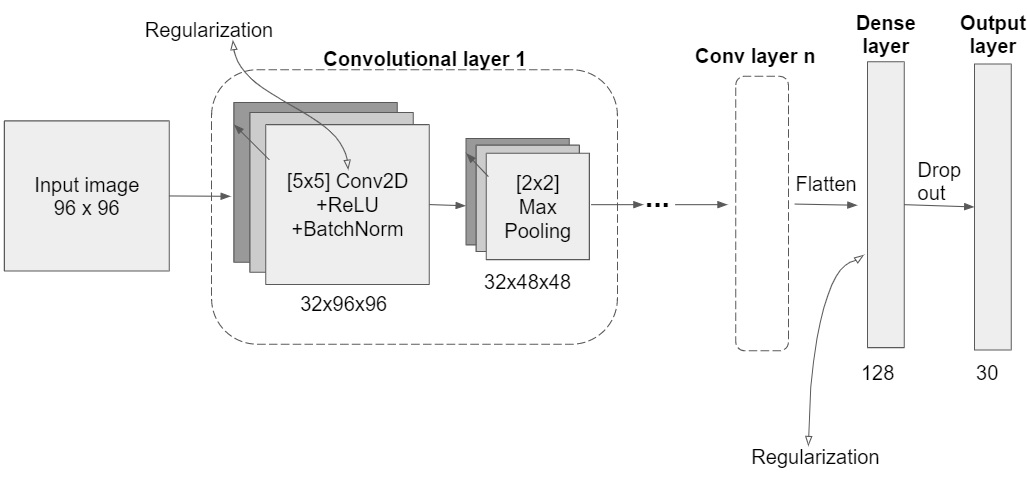

**Loss function:**

Our problem can be defined as regression predictive modeling in a sense that it aims at predicting real-valued quantities (i.e. keypoint poistions in a grid). Thus, we choose the mean of squares of errors (MSE) between labels and predictions as the loss function.

**Objective: to minimize the loss**
   
The default optimization algorithm for our CNN would be the Adaptive Momentum estimation (ADAM) [1]. ADAM is an advanced gradient descent family with the capability of computing adaptive learning rates for each parameter. ADAM is technically a combination of two other GD algorithms namely RMSprop and momentum. This algorithm has been proved to be very robust for a variety of applications including the image processing. There are four hyperparameters associated with ADAM inlcuding $\alpha$ (learning rate), $\beta_1$, $\beta_2$, and $\epsilon$. Most of ADAM users stick with the default values for the last three and only focus on the learning rate. For our model, we will follow the same approach.

[1] Kingma, D. P., & Ba, J. L. (2015). _Adam: a Method for Stochastic Optimization._ International Conference on Learning Representations, 1–13. 

**Metrics:**

To evaluate the model performance during the training (i.e. fit <--> validation) process, we consider the average of the absolute difference (MAE) between the actual and predicted values. The MAE is more robust to outliers as compared with MSE. The mean absolute  error (MAE) between true and predicted values is defined as folows:

$\text {MAE} = |y - y_h|$


**Callbacks:**

We will use the following callbacks during the model fitting process for either dataset:
* EarlyStopping: to stop the model (before reaching to the max epoch) if validation loss consistently increases for 15 consequtive epochs. This will save our time if the model would most likely overfit.
* ReduceLROnPlateau: to reduce the learning rate by a (10x) factor if the model performance would not continously improve between epochs (with patience of 5 epochs).

### *Model Performance Assessment & Error Analysis* 

Practical actions we took to prevent and/or overcome **underfitting and/or overfitting** in this project:

**On the data level:**

> **Detection and removing anomalies:**

> **Data augmentation:**
* Data augmentation can help improve the model performance in different ways, most importantly by increasing the size of the dataset. However, very aggressive augmentation my affect semantic content of the data and ultimately result in underfitting. Throughout the process of data augmentation, 

**On the model level:**
> **Dropout in the model:**
* Drop out has proved by many studies to be very effective in preventing overfitting. Although dropouts can be put anywhere in the model, the most efficient would be to use them after the Fully Connected (FC) layers considering that they contain the most parameters and thus are most prone layers to overfitting. 

> **Batch Normalization in the model:**
* Besides its effect to help speeding up convergence and allowing for the use of higher learning rates, batch normalization would also help regularization.

> **Early stopping during model fitting:**
* Is used to stop an unticipated overfitting prematurely by monitoring the validation loss and terminating the training phase when this metric stops improving after a number of epochs (called tolerance). This way we give the model enough time to learn the useful information but not enough to learn from the noise.

> **Regularization:**

* Increasing the complexity of the model (for instance adding more convoultional layers) helps increasing the model performance on training . However, this would at the cost of reducing the model ability to generalize well to the unseen dev dataset. Regularization will prevent the model to be perfectly fitted with the benefit of better prediction capability. 

    * l1: sum of absolute values.
    * l2: sum of the squared values.
    * l1_l2: sum of absolute and sum of the squared values.

>> Activity regularization:
* Activity regularization is specified on a layer in Keras.
* This can be achieved by setting the activity_regularizer argument on the layer to an instantiated and configured regularizer class.
    * Activity regularization on a Conv2D convolutional layer: model.add(Conv2D(32, (3,3), activity_regularizer=l1(0.001)))
    
>> Weight regularization:
* Weight regularization does not seem widely used in CNN models, or if it is used, its use is not widely reported. L2 weight regularization with very small regularization hyperparameters such as (e.g. 0.0005) may be a good starting point.
    * for Convolutional Layers: model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    
> **Hyperparameter tuning:**
* A very simple model may lead to underfitting. Increasing the compelxity, specially adding more convolutional layers can improve the training performance by allowing the model to learn more and more features of the images. However, excessive complexity can come at the cost of overfitting and prevents the model to generalize well on some or all features. As for HP tuning, we tried to keep a balance between bias and variance. To this end, we also included the hyperparameters regarding the regularization in the tuning process.


In [100]:
########### functions for modeling and error analysis ##########################

def create_CNN_model(n_out, layers, filters = [32, 64, 128, 256, 512], dense_unit = 512, ks = [3,3,3,3,3], 
                     lr = 0.1, mpls = 2, drpout = 0.1, 
                     reg = {'l1': 0.001, 'l2': 0.001}, padding = 'same', activation_last = 'relu'):
    '''
    Our main function to build the CNN model:
    
    n_out:    number of outputs--> for fully populated = 30, for partially populated = 8
    layers:   number of Conv2d layers 
    filters:  a list including the number of filters (neurons/channels) in each Conv2D layer. The size of this list
              also determined the number of Conv2D layers in the model
              example: [32, 64, 128]
    dense_unit: the number of units in the first dense layer 
    lr:         learning rate (alpha)
    ks:         a list of kernel sizes ([ks, ks]) for all conv2d layers
    mpls:       max pooling size (default 2)
    reg:        Regularization parameters for l1 and/or l2 regularizers; type: dictionary; if not given (=empty)
                 no regularization will be applied; for l1_l2 regularizer we should assign both the l1 and l2 parameters
    drpout:     dropout intensity
    padding:    default as "same" (for zero padding use 'valid')
    activation_last: activation function in the dense layer (default: ReLU)
    '''
    
    model = keras.models.Sequential()
    # Input Layer
    model.add(keras.layers.InputLayer(input_shape=[96,96,1]))
    

    # Looping over all elements in the list of filters and build the Conv2D layers one by one
    for i in range(len(filters)):
        if (i + 1 <= layers):
            # The CONV2D layer: 
            if reg != {}:     # two types of regularization are being applied: activation and kernel
                model.add(keras.layers.Conv2D(filters=filters[i], 
                                              kernel_size=[ks[i],ks[i]], 
                                              padding=padding, 
                                              use_bias=False,
                                              activity_regularizer=l1_l2(l1=reg['l1'], l2=reg['l2']), kernel_regularizer=l2(reg['l2'])))
            else:
                model.add(keras.layers.Conv2D(filters=filters[i], 
                                                  kernel_size=[ks[i],ks[i]], 
                                                  padding=padding, 
                                                  use_bias=False,))
            # The activation layer
            model.add(keras.layers.LeakyReLU(alpha = lr))
            # The Batch Normalization layer
            model.add(keras.layers.BatchNormalization())
            # The max pooling layer
            model.add(keras.layers.MaxPool2D(pool_size=[mpls,mpls]))
    
    # Flattening after all Conv2D Layers
    model.add(keras.layers.Flatten())
    
    # Dense layer: 
    if reg != {}:    # two types of regularization are being applied: activation and kernel
        model.add(keras.layers.Dense(units=dense_unit, 
                                     activation=activation_last,
                                     activity_regularizer=l1_l2(l1=reg['l1'], l2=reg['l2']), kernel_regularizer=l2(reg['l2'])))
    else:
        model.add(keras.layers.Dense(units=dense_unit, 
                             activation=activation_last,))
        
    # Dropout
    model.add(keras.layers.Dropout(drpout))
    
    # Output layer
    model.add(keras.layers.Dense(units=n_out))
    
    return model

#########################################################################################################
def plot_hist(history):
    '''Plots the loss and mean absolute error (MAE) curves for training and validation sets after the model is fully trained '''
    
    fig, ax = plt.subplots(2,1, figsize = (8,10), sharex = True)
    
    # Plot 1: training vs. validation loss
    ax[0].plot(history.history['loss'], color='b', label="Training Loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation Loss")
    ax[0].set_ylabel('Log Loss')
    legend = ax[0].legend(loc='best', shadow=True)
    
    # Plot 2: training vs. validation MAE
    ax[1].plot(history.history['mae'], color='b', label="Training MAE")
    ax[1].plot(history.history['val_mae'], color='r',label="Validation MAE")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Log MAE')
    legend = ax[1].legend(loc='best', shadow=True)

    plt.tight_layout(pad = 0.5)
    plt.show()

###########################################################################################################################

def error_analysis(model, X_train, X_dev, Y_train, Y_dev, keypoints_list):
    '''This function is used for error analysis by calculating and comparing the MAE for the model predicted keypoints coordinate 
      with train and dev data and compare them to each other
      The results can tell us what side of the famous Performance-Complexity we are, and which direction we need to go to improve the performance'''
    
    # apply the trained model to predict the outputs for the train (seen) and dev (never seen) data
    Y_pred_train = model.predict(X_train)
    Y_pred_dev = model.predict(X_dev) 

    # Calculate the MAE for all predicted keypoint coordinates vs the true labels
    mae_train = abs(Y_pred_train - Y_train)
    mae_dev  = abs(Y_pred_dev - Y_dev)
    
    # 
    print('Predicted average MAE with using Train data: {}'.format(np.mean(mae_train)))
    print('Predicted average MAE with using Dev data: {}'.format(np.mean(mae_dev)))
    
    # put the MAE erros for the train and dev data side by side in a data frame
    df = pd.DataFrame(index = [keypoints_list])
    df['Train'] = np.mean(mae_train, axis = 0)
    df['Dev'] = np.mean(mae_dev, axis = 0)

    # Plot the MAE erros for the train and dev data side by side
    df.plot(style = '--o', figsize = (20,5))
    plt.xticks(range(len(df.index)), df.index, rotation = 90)
    plt.ylabel('Average MAE')
    plt.ylim([0,3])
    plt.show()
    
    return Y_pred_dev, df

### Define the base model

For our base model, we consider 3 convolutional layers,kernel size of (5,4,3) for all layers, filter sizes of 32, 64, and 128 for layers 1 to 3, and 512 for the dense layer, dropout probability of 0.1, starting learning rate of 0.001, and no regularization.

In [102]:
base_model = create_CNN_model(n_out = 30, layers = 3, filters = [32, 64,128], dense_unit = 128, ks = [3,3,3], \
                           lr = 0.1, mpls = 2, drpout = 0.1, reg = {}, padding = 'same', activation_last = 'relu')
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 48, 48, 64)       

In [103]:
# Define necessary callbacks: will be used with every model
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(patience=15, restore_best_weights=True, mode='min')
adjust_lr =  ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=.1, min_lr=.00000001)                        
callbacks = [checkpointer, early_stop, adjust_lr]

### Fitting the model to input data

> ### ***Part 1.1*** - with fully populated dataset (no augmentation)

In [104]:
# remove the mean the keypoint values
Yf1_mean = np.mean(Yf1, axis = 0)
Yf1_n = (Yf1 - Yf1_mean)

# split the data into the train and dev datasets with 80% to 20%
Xf_train, Xf_dev, Yf_train, Yf_dev = train_test_split(Xf1, Yf1_n, test_size=0.2, random_state=46)

# Delete unused data to reduce memory
del  Yf1_n #Xf1, Yf1,

In [107]:
%%time

# compile the model
base_model.compile(optimizer = 'adam', 
              loss = "mse", 
              metrics = ["mae"])

# Fit and validate the model with fully-populated base dataset
hist_f = base_model.fit(
            Xf_train, Yf_train,
            epochs= 100, batch_size=64,
            validation_split=0.1,
            callbacks=callbacks,
            verbose=1
            )

Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 9.8044 - mae: 2.276 - ETA: 0s - loss: 10.1783 - mae: 2.36 - ETA: 0s - loss: 9.8944 - mae: 2.3210 - ETA: 0s - loss: 10.1774 - mae: 2.33 - ETA: 0s - loss: 10.0778 - mae: 2.32 - ETA: 0s - loss: 9.8825 - mae: 2.2988 - ETA: 0s - loss: 9.8577 - mae: 2.287 - ETA: 0s - loss: 9.9282 - mae: 2.2970
Epoch 00001: val_mae did not improve from 2.44693
25/25 [==============================] - 1s 25ms/step - loss: 9.9451 - mae: 2.2994 - val_loss: 54.8406 - val_mae: 5.8273 - lr: 0.0010
Epoch 2/100
22/25 [=========================>....] - ETA: 0s - loss: 10.3869 - mae: 2.34 - ETA: 0s - loss: 9.2368 - mae: 2.2460 - ETA: 0s - loss: 9.9475 - mae: 2.291 - ETA: 0s - loss: 9.7157 - mae: 2.273 - ETA: 0s - loss: 9.9233 - mae: 2.278 - ETA: 0s - loss: 9.7398 - mae: 2.271 - ETA: 0s - loss: 9.6904 - mae: 2.270 - ETA: 0s - loss: 9.4994 - mae: 2.2547
Epoch 00002: val_mae did not improve from 2.44693
25/25 [==============================] - 0s 19ms/st

25/25 [==============================] - 1s 23ms/step - loss: 5.0382 - mae: 1.6358 - val_loss: 6.6783 - val_mae: 1.9044 - lr: 0.0010
Epoch 16/100
22/25 [=========================>....] - ETA: 0s - loss: 5.2188 - mae: 1.663 - ETA: 0s - loss: 4.4809 - mae: 1.556 - ETA: 0s - loss: 4.6489 - mae: 1.576 - ETA: 0s - loss: 4.5844 - mae: 1.570 - ETA: 0s - loss: 4.5011 - mae: 1.555 - ETA: 0s - loss: 4.5932 - mae: 1.568 - ETA: 0s - loss: 4.5802 - mae: 1.569 - ETA: 0s - loss: 4.6152 - mae: 1.5716
Epoch 00016: val_mae improved from 1.90445 to 1.80469, saving model to best_model.hdf5
25/25 [==============================] - 1s 24ms/step - loss: 4.6265 - mae: 1.5736 - val_loss: 6.0168 - val_mae: 1.8047 - lr: 0.0010
Epoch 17/100
22/25 [=========================>....] - ETA: 0s - loss: 3.7085 - mae: 1.434 - ETA: 0s - loss: 4.9679 - mae: 1.622 - ETA: 0s - loss: 4.7589 - mae: 1.585 - ETA: 0s - loss: 4.6889 - mae: 1.572 - ETA: 0s - loss: 4.4629 - mae: 1.540 - ETA: 0s - loss: 4.4622 - mae: 1.537 - ETA: 0s 

22/25 [=========================>....] - ETA: 0s - loss: 4.0999 - mae: 1.433 - ETA: 0s - loss: 3.7872 - mae: 1.435 - ETA: 0s - loss: 3.8790 - mae: 1.444 - ETA: 0s - loss: 3.9918 - mae: 1.459 - ETA: 0s - loss: 4.0558 - mae: 1.464 - ETA: 0s - loss: 4.1161 - mae: 1.465 - ETA: 0s - loss: 4.2253 - mae: 1.480 - ETA: 0s - loss: 4.2245 - mae: 1.4834
Epoch 00044: val_mae did not improve from 1.38742
25/25 [==============================] - 0s 19ms/step - loss: 4.2682 - mae: 1.4880 - val_loss: 3.8035 - val_mae: 1.3999 - lr: 0.0010
Epoch 45/100
22/25 [=========================>....] - ETA: 0s - loss: 2.8424 - mae: 1.254 - ETA: 0s - loss: 3.7987 - mae: 1.421 - ETA: 0s - loss: 3.9766 - mae: 1.453 - ETA: 0s - loss: 3.9834 - mae: 1.455 - ETA: 0s - loss: 4.0073 - mae: 1.457 - ETA: 0s - loss: 4.2887 - mae: 1.473 - ETA: 0s - loss: 4.2882 - mae: 1.477 - ETA: 0s - loss: 4.2400 - mae: 1.4731
Epoch 00045: val_mae improved from 1.38742 to 1.38085, saving model to best_model.hdf5
25/25 [======================

Epoch 59/100
22/25 [=========================>....] - ETA: 0s - loss: 3.6892 - mae: 1.409 - ETA: 0s - loss: 4.2605 - mae: 1.456 - ETA: 0s - loss: 4.1460 - mae: 1.458 - ETA: 0s - loss: 4.0396 - mae: 1.442 - ETA: 0s - loss: 4.1195 - mae: 1.467 - ETA: 0s - loss: 4.0388 - mae: 1.456 - ETA: 0s - loss: 4.0650 - mae: 1.457 - ETA: 0s - loss: 4.0162 - mae: 1.4488
Epoch 00059: val_mae did not improve from 1.36632
25/25 [==============================] - 0s 19ms/step - loss: 3.9913 - mae: 1.4442 - val_loss: 3.6149 - val_mae: 1.3684 - lr: 1.0000e-05
Epoch 60/100
22/25 [=========================>....] - ETA: 0s - loss: 3.5160 - mae: 1.392 - ETA: 0s - loss: 3.6438 - mae: 1.381 - ETA: 0s - loss: 3.7361 - mae: 1.412 - ETA: 0s - loss: 4.0031 - mae: 1.445 - ETA: 0s - loss: 3.9930 - mae: 1.445 - ETA: 0s - loss: 4.0023 - mae: 1.445 - ETA: 0s - loss: 3.9733 - mae: 1.436 - ETA: 0s - loss: 3.9655 - mae: 1.4358
Epoch 00060: val_mae did not improve from 1.36632
25/25 [==============================] - 0s 19ms/

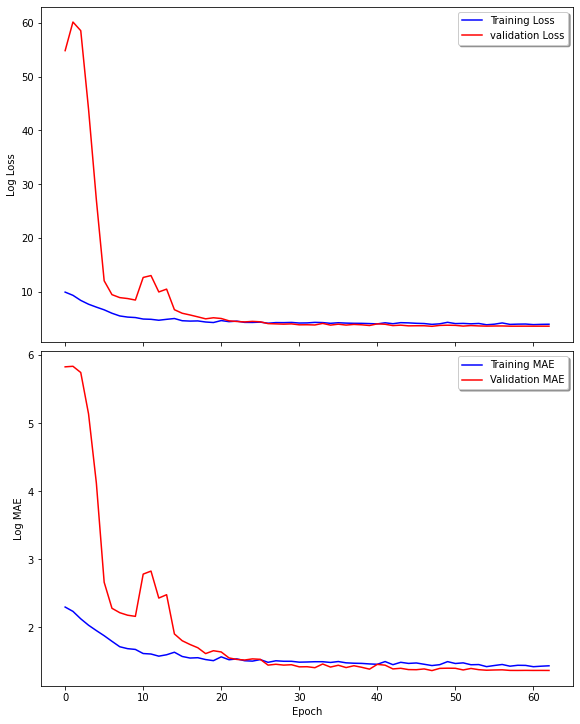

Predicted average MAE with using Train data: 1.282847099143637
Predicted average MAE with using Dev data: 1.4029570039227248


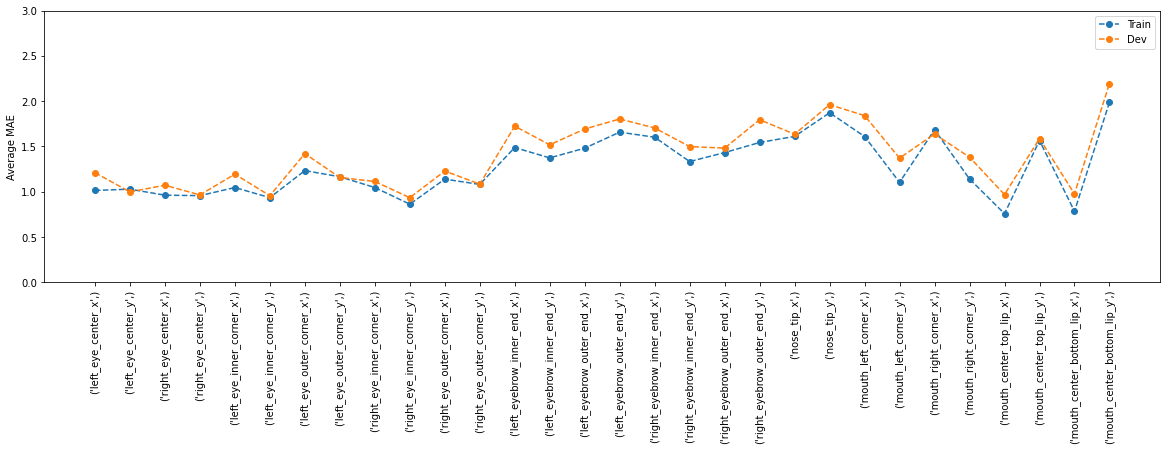

In [108]:
# Presenting the performance of the model in training
plot_hist(hist_f)

# Error analysis
Yf_pred_dev, df = error_analysis(base_model, Xf_train, Xf_dev, Yf_train, Yf_dev, keypoints_list_full)

In [ ]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
n = np.random.randint(len(Yf_dev))
print(n)
plot_facial_keypoints(Xf_dev[n],Yf_pred_dev[n]+Yf1_mean, 'b', 'predicted')
plot_facial_keypoints(Xf_dev[n],Yf_dev[n]+Yf1_mean, 'r')

> ### _**Part 1.2** - with added augmented data to the fully populated dataset_

In [75]:
# remove the mean from the keypoint values
Yfas_mean = np.mean(Yfas, axis = 0)
Yfas_n = (Yfas - Yfas_mean)
          
# split the data into the train and dev datasets with 80% to 20%
Xfa_train, Xfa_dev, Yfa_train, Yfa_dev = train_test_split(Xfas, Yfas_n,  test_size=0.2, random_state= 42)

# Delete unused data to reduce memory
del Yfas_n  #Xfas, Yfas, 

In [82]:
%%time
# compile the model
base_model.compile(optimizer = 'adam', 
              loss = "mse", 
              metrics = ["mae"])

# Fit and validate the model with augmented dataset
hist_fa = base_model.fit(Xfa_train, Yfa_train,
            epochs= 100, batch_size=128,
            validation_split=0.1,
            callbacks = callbacks,
            verbose=1)

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 21.8542 - mae: 3.58 - ETA: 2s - loss: 30.7932 - mae: 4.18 - ETA: 2s - loss: 23.8963 - mae: 3.63 - ETA: 2s - loss: 20.9878 - mae: 3.38 - ETA: 2s - loss: 19.4290 - mae: 3.25 - ETA: 2s - loss: 18.1763 - mae: 3.14 - ETA: 2s - loss: 17.4731 - mae: 3.08 - ETA: 2s - loss: 16.8462 - mae: 3.02 - ETA: 2s - loss: 16.4432 - mae: 2.99 - ETA: 2s - loss: 16.1166 - mae: 2.96 - ETA: 2s - loss: 15.6851 - mae: 2.92 - ETA: 2s - loss: 15.4031 - mae: 2.90 - ETA: 2s - loss: 15.1883 - mae: 2.88 - ETA: 2s - loss: 14.9628 - mae: 2.85 - ETA: 2s - loss: 14.7516 - mae: 2.83 - ETA: 2s - loss: 14.4901 - mae: 2.81 - ETA: 2s - loss: 14.3012 - mae: 2.79 - ETA: 2s - loss: 14.0976 - mae: 2.77 - ETA: 2s - loss: 13.8499 - mae: 2.75 - ETA: 1s - loss: 13.6906 - mae: 2.73 - ETA: 1s - loss: 13.5174 - mae: 2.71 - ETA: 1s - loss: 13.3725 - mae: 2.70 - ETA: 1s - loss: 13.2367 - mae: 2.68 - ETA: 1s - loss: 13.0758 - mae: 2.67 - ETA: 1s - loss: 12.9547 - mae: 2.65

Epoch 00007: val_mae improved from 1.47682 to 1.24798, saving model to best_model.hdf5
97/97 [==============================] - 4s 37ms/step - loss: 3.5576 - mae: 1.3883 - val_loss: 2.9060 - val_mae: 1.2480 - lr: 0.0010
Epoch 8/100
97/97 [==============================] - ETA: 0s - loss: 3.5755 - mae: 1.359 - ETA: 2s - loss: 3.4081 - mae: 1.345 - ETA: 2s - loss: 3.4627 - mae: 1.368 - ETA: 2s - loss: 3.5338 - mae: 1.385 - ETA: 2s - loss: 3.5492 - mae: 1.389 - ETA: 2s - loss: 3.5000 - mae: 1.379 - ETA: 2s - loss: 3.5454 - mae: 1.390 - ETA: 2s - loss: 3.5956 - mae: 1.395 - ETA: 2s - loss: 3.5426 - mae: 1.387 - ETA: 2s - loss: 3.5177 - mae: 1.382 - ETA: 2s - loss: 3.4947 - mae: 1.380 - ETA: 2s - loss: 3.4863 - mae: 1.377 - ETA: 2s - loss: 3.4700 - mae: 1.374 - ETA: 2s - loss: 3.4625 - mae: 1.374 - ETA: 2s - loss: 3.4473 - mae: 1.370 - ETA: 2s - loss: 3.4243 - mae: 1.366 - ETA: 2s - loss: 3.4087 - mae: 1.363 - ETA: 2s - loss: 3.3930 - mae: 1.360 - ETA: 1s - loss: 3.3937 - mae: 1.360 - ETA: 

97/97 [==============================] - ETA: 0s - loss: 3.2065 - mae: 1.319 - ETA: 2s - loss: 2.8728 - mae: 1.255 - ETA: 2s - loss: 2.9632 - mae: 1.269 - ETA: 2s - loss: 2.8941 - mae: 1.255 - ETA: 2s - loss: 2.8855 - mae: 1.251 - ETA: 2s - loss: 2.8743 - mae: 1.248 - ETA: 2s - loss: 2.8894 - mae: 1.249 - ETA: 2s - loss: 2.8599 - mae: 1.242 - ETA: 2s - loss: 2.8650 - mae: 1.242 - ETA: 2s - loss: 2.8604 - mae: 1.241 - ETA: 2s - loss: 2.8622 - mae: 1.241 - ETA: 2s - loss: 2.8726 - mae: 1.244 - ETA: 2s - loss: 2.8960 - mae: 1.249 - ETA: 2s - loss: 2.8966 - mae: 1.248 - ETA: 2s - loss: 2.9017 - mae: 1.250 - ETA: 2s - loss: 2.9160 - mae: 1.252 - ETA: 2s - loss: 2.9034 - mae: 1.250 - ETA: 2s - loss: 2.9033 - mae: 1.251 - ETA: 2s - loss: 2.9194 - mae: 1.254 - ETA: 1s - loss: 2.9058 - mae: 1.251 - ETA: 1s - loss: 2.9200 - mae: 1.254 - ETA: 1s - loss: 2.9434 - mae: 1.258 - ETA: 1s - loss: 2.9383 - mae: 1.258 - ETA: 1s - loss: 2.9402 - mae: 1.257 - ETA: 1s - loss: 2.9315 - mae: 1.255 - ETA: 1s -

97/97 [==============================] - ETA: 0s - loss: 2.4417 - mae: 1.170 - ETA: 2s - loss: 2.4152 - mae: 1.152 - ETA: 2s - loss: 2.6908 - mae: 1.198 - ETA: 2s - loss: 2.6949 - mae: 1.195 - ETA: 2s - loss: 2.6280 - mae: 1.185 - ETA: 2s - loss: 2.6291 - mae: 1.185 - ETA: 2s - loss: 2.6531 - mae: 1.191 - ETA: 2s - loss: 2.6291 - mae: 1.185 - ETA: 2s - loss: 2.6572 - mae: 1.189 - ETA: 2s - loss: 2.6708 - mae: 1.191 - ETA: 2s - loss: 2.6579 - mae: 1.187 - ETA: 2s - loss: 2.6438 - mae: 1.185 - ETA: 2s - loss: 2.6665 - mae: 1.188 - ETA: 2s - loss: 2.6699 - mae: 1.189 - ETA: 2s - loss: 2.6832 - mae: 1.192 - ETA: 2s - loss: 2.6814 - mae: 1.193 - ETA: 2s - loss: 2.6703 - mae: 1.191 - ETA: 2s - loss: 2.6678 - mae: 1.191 - ETA: 1s - loss: 2.6529 - mae: 1.188 - ETA: 1s - loss: 2.6658 - mae: 1.190 - ETA: 1s - loss: 2.6622 - mae: 1.189 - ETA: 1s - loss: 2.6563 - mae: 1.189 - ETA: 1s - loss: 2.6571 - mae: 1.188 - ETA: 1s - loss: 2.6521 - mae: 1.188 - ETA: 1s - loss: 2.6565 - mae: 1.187 - ETA: 1s -

Epoch 27/100
95/97 [============================>.] - ETA: 0s - loss: 2.6128 - mae: 1.166 - ETA: 2s - loss: 2.7439 - mae: 1.184 - ETA: 2s - loss: 2.5903 - mae: 1.158 - ETA: 2s - loss: 2.5508 - mae: 1.159 - ETA: 2s - loss: 2.4975 - mae: 1.148 - ETA: 2s - loss: 2.5114 - mae: 1.150 - ETA: 2s - loss: 2.5297 - mae: 1.154 - ETA: 2s - loss: 2.5008 - mae: 1.152 - ETA: 2s - loss: 2.4771 - mae: 1.148 - ETA: 2s - loss: 2.4724 - mae: 1.148 - ETA: 2s - loss: 2.4965 - mae: 1.151 - ETA: 2s - loss: 2.5194 - mae: 1.156 - ETA: 2s - loss: 2.5246 - mae: 1.156 - ETA: 2s - loss: 2.5223 - mae: 1.155 - ETA: 2s - loss: 2.5292 - mae: 1.157 - ETA: 2s - loss: 2.5247 - mae: 1.157 - ETA: 2s - loss: 2.5493 - mae: 1.160 - ETA: 2s - loss: 2.5516 - mae: 1.160 - ETA: 2s - loss: 2.5431 - mae: 1.158 - ETA: 2s - loss: 2.5424 - mae: 1.157 - ETA: 1s - loss: 2.5453 - mae: 1.158 - ETA: 1s - loss: 2.5423 - mae: 1.157 - ETA: 1s - loss: 2.5432 - mae: 1.156 - ETA: 1s - loss: 2.5345 - mae: 1.154 - ETA: 1s - loss: 2.5267 - mae: 1.15

97/97 [==============================] - ETA: 0s - loss: 2.2781 - mae: 1.128 - ETA: 2s - loss: 2.4045 - mae: 1.146 - ETA: 2s - loss: 2.4398 - mae: 1.142 - ETA: 2s - loss: 2.4395 - mae: 1.141 - ETA: 2s - loss: 2.4549 - mae: 1.139 - ETA: 2s - loss: 2.4506 - mae: 1.139 - ETA: 2s - loss: 2.4571 - mae: 1.140 - ETA: 2s - loss: 2.4842 - mae: 1.145 - ETA: 2s - loss: 2.4625 - mae: 1.141 - ETA: 2s - loss: 2.4649 - mae: 1.140 - ETA: 2s - loss: 2.4616 - mae: 1.140 - ETA: 2s - loss: 2.4659 - mae: 1.142 - ETA: 2s - loss: 2.4715 - mae: 1.143 - ETA: 2s - loss: 2.5062 - mae: 1.149 - ETA: 2s - loss: 2.5025 - mae: 1.148 - ETA: 2s - loss: 2.4982 - mae: 1.148 - ETA: 2s - loss: 2.4887 - mae: 1.145 - ETA: 2s - loss: 2.4972 - mae: 1.146 - ETA: 2s - loss: 2.4823 - mae: 1.144 - ETA: 2s - loss: 2.4856 - mae: 1.145 - ETA: 1s - loss: 2.4870 - mae: 1.145 - ETA: 1s - loss: 2.4912 - mae: 1.147 - ETA: 1s - loss: 2.4961 - mae: 1.147 - ETA: 1s - loss: 2.4983 - mae: 1.147 - ETA: 1s - loss: 2.5094 - mae: 1.148 - ETA: 1s -

95/97 [============================>.] - ETA: 0s - loss: 2.6323 - mae: 1.132 - ETA: 2s - loss: 2.4956 - mae: 1.126 - ETA: 2s - loss: 2.3378 - mae: 1.094 - ETA: 2s - loss: 2.3101 - mae: 1.093 - ETA: 2s - loss: 2.3613 - mae: 1.100 - ETA: 2s - loss: 2.3693 - mae: 1.100 - ETA: 2s - loss: 2.3210 - mae: 1.091 - ETA: 2s - loss: 2.3124 - mae: 1.092 - ETA: 2s - loss: 2.3036 - mae: 1.092 - ETA: 2s - loss: 2.3146 - mae: 1.095 - ETA: 2s - loss: 2.3100 - mae: 1.094 - ETA: 2s - loss: 2.2983 - mae: 1.092 - ETA: 2s - loss: 2.3323 - mae: 1.098 - ETA: 2s - loss: 2.3567 - mae: 1.100 - ETA: 2s - loss: 2.3592 - mae: 1.102 - ETA: 2s - loss: 2.3428 - mae: 1.099 - ETA: 2s - loss: 2.3363 - mae: 1.097 - ETA: 2s - loss: 2.3438 - mae: 1.099 - ETA: 1s - loss: 2.3425 - mae: 1.099 - ETA: 1s - loss: 2.3372 - mae: 1.097 - ETA: 1s - loss: 2.3315 - mae: 1.095 - ETA: 1s - loss: 2.3621 - mae: 1.100 - ETA: 1s - loss: 2.3500 - mae: 1.098 - ETA: 1s - loss: 2.3516 - mae: 1.097 - ETA: 1s - loss: 2.3593 - mae: 1.098 - ETA: 1s -

Epoch 44/100
95/97 [============================>.] - ETA: 0s - loss: 2.4740 - mae: 1.138 - ETA: 2s - loss: 2.1759 - mae: 1.062 - ETA: 2s - loss: 2.2961 - mae: 1.077 - ETA: 2s - loss: 2.2479 - mae: 1.070 - ETA: 2s - loss: 2.2081 - mae: 1.061 - ETA: 2s - loss: 2.2072 - mae: 1.066 - ETA: 2s - loss: 2.2005 - mae: 1.066 - ETA: 2s - loss: 2.1874 - mae: 1.064 - ETA: 2s - loss: 2.2099 - mae: 1.071 - ETA: 2s - loss: 2.2314 - mae: 1.075 - ETA: 2s - loss: 2.2561 - mae: 1.079 - ETA: 2s - loss: 2.2431 - mae: 1.077 - ETA: 2s - loss: 2.2586 - mae: 1.081 - ETA: 2s - loss: 2.2534 - mae: 1.079 - ETA: 2s - loss: 2.2491 - mae: 1.079 - ETA: 2s - loss: 2.2538 - mae: 1.078 - ETA: 2s - loss: 2.2649 - mae: 1.081 - ETA: 2s - loss: 2.2709 - mae: 1.082 - ETA: 2s - loss: 2.2696 - mae: 1.082 - ETA: 1s - loss: 2.2821 - mae: 1.084 - ETA: 1s - loss: 2.2817 - mae: 1.085 - ETA: 1s - loss: 2.2810 - mae: 1.086 - ETA: 1s - loss: 2.2834 - mae: 1.087 - ETA: 1s - loss: 2.2974 - mae: 1.089 - ETA: 1s - loss: 2.3019 - mae: 1.08

97/97 [==============================] - ETA: 0s - loss: 1.9251 - mae: 0.995 - ETA: 2s - loss: 2.1451 - mae: 1.043 - ETA: 2s - loss: 2.2209 - mae: 1.053 - ETA: 2s - loss: 2.1624 - mae: 1.045 - ETA: 2s - loss: 2.1828 - mae: 1.055 - ETA: 2s - loss: 2.2001 - mae: 1.060 - ETA: 2s - loss: 2.2137 - mae: 1.067 - ETA: 2s - loss: 2.2147 - mae: 1.068 - ETA: 2s - loss: 2.2080 - mae: 1.068 - ETA: 2s - loss: 2.1770 - mae: 1.062 - ETA: 2s - loss: 2.1848 - mae: 1.065 - ETA: 2s - loss: 2.2064 - mae: 1.068 - ETA: 2s - loss: 2.2163 - mae: 1.069 - ETA: 2s - loss: 2.2442 - mae: 1.071 - ETA: 2s - loss: 2.2523 - mae: 1.073 - ETA: 2s - loss: 2.2532 - mae: 1.074 - ETA: 2s - loss: 2.2508 - mae: 1.075 - ETA: 2s - loss: 2.2544 - mae: 1.076 - ETA: 1s - loss: 2.2608 - mae: 1.078 - ETA: 1s - loss: 2.2579 - mae: 1.078 - ETA: 1s - loss: 2.2498 - mae: 1.076 - ETA: 1s - loss: 2.2524 - mae: 1.077 - ETA: 1s - loss: 2.2495 - mae: 1.076 - ETA: 1s - loss: 2.2466 - mae: 1.075 - ETA: 1s - loss: 2.2445 - mae: 1.075 - ETA: 1s -

97/97 [==============================] - ETA: 0s - loss: 2.3797 - mae: 1.131 - ETA: 2s - loss: 2.2658 - mae: 1.103 - ETA: 2s - loss: 2.2460 - mae: 1.084 - ETA: 2s - loss: 2.2385 - mae: 1.080 - ETA: 2s - loss: 2.2562 - mae: 1.082 - ETA: 2s - loss: 2.2530 - mae: 1.078 - ETA: 2s - loss: 2.2356 - mae: 1.075 - ETA: 2s - loss: 2.2337 - mae: 1.075 - ETA: 2s - loss: 2.2483 - mae: 1.075 - ETA: 2s - loss: 2.2367 - mae: 1.073 - ETA: 2s - loss: 2.2200 - mae: 1.069 - ETA: 2s - loss: 2.2390 - mae: 1.074 - ETA: 2s - loss: 2.2271 - mae: 1.071 - ETA: 2s - loss: 2.2166 - mae: 1.069 - ETA: 2s - loss: 2.2113 - mae: 1.068 - ETA: 2s - loss: 2.2098 - mae: 1.067 - ETA: 2s - loss: 2.2366 - mae: 1.069 - ETA: 2s - loss: 2.2259 - mae: 1.067 - ETA: 1s - loss: 2.2291 - mae: 1.069 - ETA: 1s - loss: 2.2438 - mae: 1.071 - ETA: 1s - loss: 2.2603 - mae: 1.073 - ETA: 1s - loss: 2.2576 - mae: 1.072 - ETA: 1s - loss: 2.2552 - mae: 1.073 - ETA: 1s - loss: 2.2515 - mae: 1.072 - ETA: 1s - loss: 2.2409 - mae: 1.070 - ETA: 1s -

96/97 [============================>.] - ETA: 0s - loss: 2.3406 - mae: 1.069 - ETA: 2s - loss: 2.1632 - mae: 1.049 - ETA: 2s - loss: 2.1776 - mae: 1.059 - ETA: 2s - loss: 2.2370 - mae: 1.075 - ETA: 2s - loss: 2.1905 - mae: 1.060 - ETA: 2s - loss: 2.1805 - mae: 1.054 - ETA: 2s - loss: 2.1933 - mae: 1.056 - ETA: 2s - loss: 2.1929 - mae: 1.057 - ETA: 2s - loss: 2.2050 - mae: 1.060 - ETA: 2s - loss: 2.2370 - mae: 1.066 - ETA: 2s - loss: 2.2303 - mae: 1.066 - ETA: 2s - loss: 2.2306 - mae: 1.066 - ETA: 2s - loss: 2.2319 - mae: 1.066 - ETA: 2s - loss: 2.2257 - mae: 1.064 - ETA: 2s - loss: 2.2074 - mae: 1.061 - ETA: 2s - loss: 2.2017 - mae: 1.060 - ETA: 2s - loss: 2.1940 - mae: 1.057 - ETA: 2s - loss: 2.1901 - mae: 1.057 - ETA: 2s - loss: 2.1941 - mae: 1.057 - ETA: 2s - loss: 2.1960 - mae: 1.058 - ETA: 1s - loss: 2.2065 - mae: 1.060 - ETA: 1s - loss: 2.2008 - mae: 1.059 - ETA: 1s - loss: 2.2139 - mae: 1.061 - ETA: 1s - loss: 2.2116 - mae: 1.061 - ETA: 1s - loss: 2.2127 - mae: 1.062 - ETA: 1s -

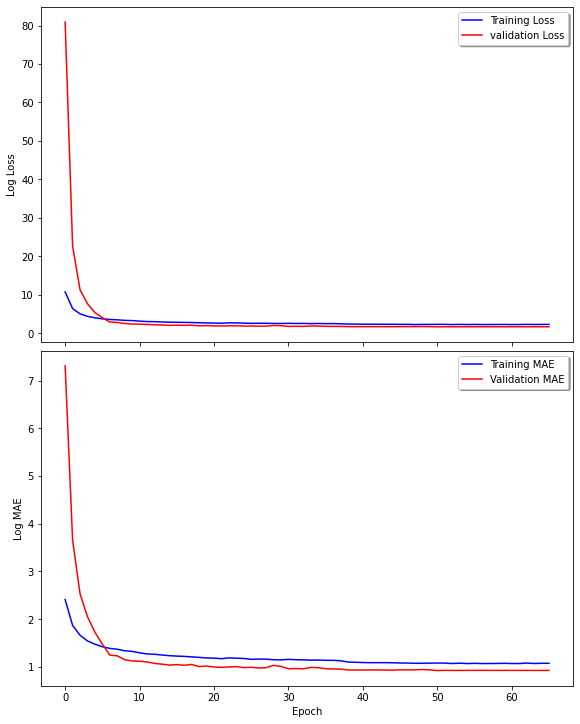

Predicted average MAE with using Train data: 0.7741853655343157
Predicted average MAE with using Dev data: 0.9227717910984982


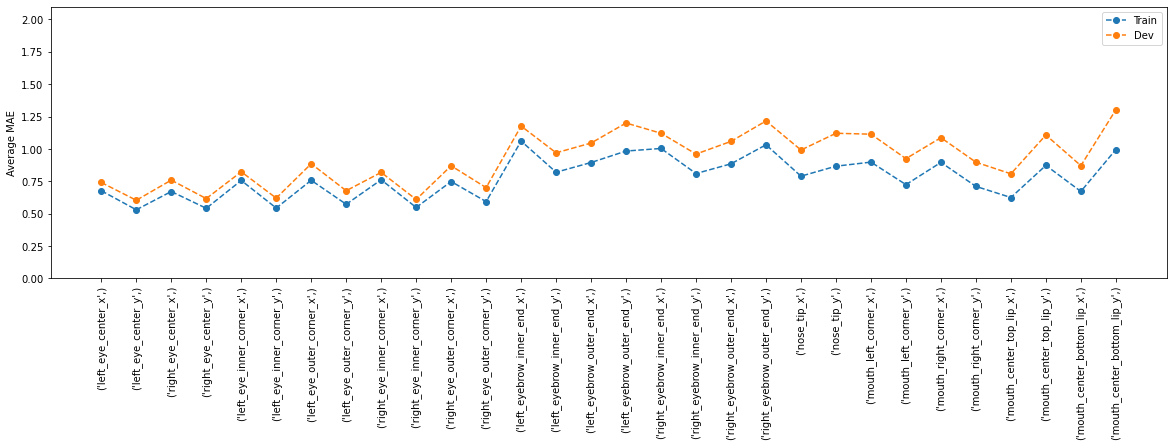

In [83]:
# Presenting the performance of the model in training
plot_hist(hist_fa)

# Error analysis
Yfa_pred_dev, dfa = error_analysis(base_model, Xfa_train, Xfa_dev, Yfa_train, Yfa_dev, keypoints_list_full)

818


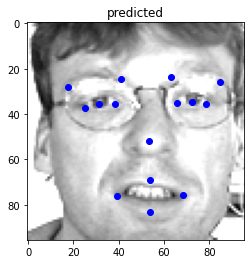

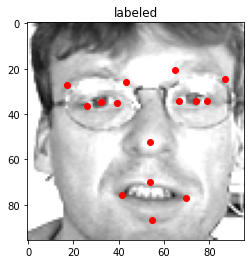

In [84]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
n = np.random.randint(len(Yfa_dev))
print(n)
plot_facial_keypoints(Xfa_dev[n],Yfa_pred_dev[n] + Yfas_mean, 'b', 'predicted')
plot_facial_keypoints(Xfa_dev[n],Yfa_dev[n]+ Yfas_mean, 'r')

> ### _**Part 2.1** - with the Partially populated dataset_

In [274]:
base_model_p = create_CNN_model(n_out = 8, layers = 3, filters = [32, 64,128], dense_unit = 512, ks = [5,3,3], \
                           lr = 0.01, mpls = 2, drpout = 0.1, reg = {}, padding = 'same', activation_last = 'relu')
base_model_p.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 96, 96, 32)        800       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 48, 48, 64)      

In [275]:
# remove the mean the keypoint values
Yp1_mean = np.mean(Yp1, axis = 0)
Yp1_n = (Yp1 - Yp1_mean)

# split the augmented data into the train and dev datasets
Xp_train, Xp_dev, Yp_train, Yp_dev = train_test_split(Xp1, Yp1_n,  test_size=0.2, random_state= 42)

# Delete unused data to reduce memory
del Yp1_n

In [276]:
# compile the model
base_model_p.compile(optimizer = 'adam', 
              loss = "mse", 
              metrics = ["mae"])

# Fit and validate the model with augmented dataset
hist_p = base_model_p.fit(Xp_train, Yp_train,
            epochs= 100, batch_size=64,
            validation_split=0.1,
            callbacks = callbacks,
            verbose=1)

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 17.9223 - mae: 3.13 - ETA: 1s - loss: 173.7552 - mae: 8.316 - ETA: 1s - loss: 112.7636 - mae: 6.612 - ETA: 1s - loss: 85.3502 - mae: 5.650 - ETA: 1s - loss: 71.1072 - mae: 5.14 - ETA: 1s - loss: 61.0266 - mae: 4.75 - ETA: 1s - loss: 53.9015 - mae: 4.47 - ETA: 1s - loss: 49.6596 - mae: 4.30 - ETA: 1s - loss: 45.7886 - mae: 4.12 - ETA: 0s - loss: 42.2371 - mae: 3.96 - ETA: 0s - loss: 39.8456 - mae: 3.86 - ETA: 0s - loss: 38.1454 - mae: 3.76 - ETA: 0s - loss: 35.9027 - mae: 3.66 - ETA: 0s - loss: 34.2686 - mae: 3.58 - ETA: 0s - loss: 33.2766 - mae: 3.52 - ETA: 0s - loss: 32.2170 - mae: 3.48 - ETA: 0s - loss: 31.1795 - mae: 3.43 - ETA: 0s - loss: 30.1923 - mae: 3.39 - ETA: 0s - loss: 29.4608 - mae: 3.34 - ETA: 0s - loss: 28.6155 - mae: 3.30 - ETA: 0s - loss: 27.7914 - mae: 3.26 - ETA: 0s - loss: 27.0014 - mae: 3.21 - ETA: 0s - loss: 26.2407 - mae: 3.17 - ETA: 0s - loss: 25.6646 - mae: 3.14 - ETA: 0s - loss: 25.0349 - mae:

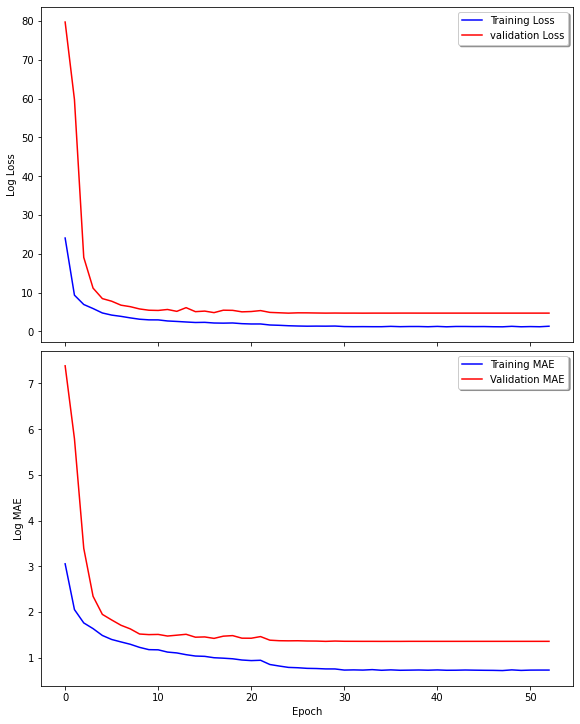

Predicted average MAE with using Train data: 0.5957086505497186
Predicted average MAE with using Dev data: 1.363827317283726


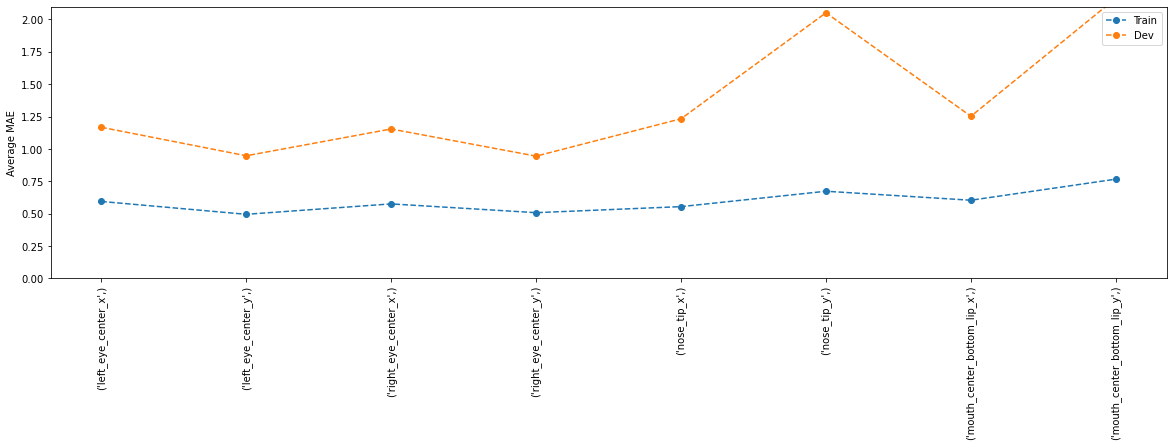

In [277]:
# Presenting the performance of the model in training
plot_hist(hist_p)

# Error analysis
Yp_pred_dev, dp = error_analysis(base_model_p, Xp_train, Xp_dev, Yp_train, Yp_dev, keypoints_list_partial)

719


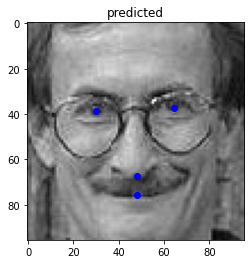

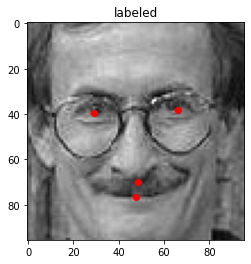

In [278]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
n = np.random.randint(len(Yp_dev))
print(n)
plot_facial_keypoints(Xp_dev[n],Yp_pred_dev[n]+Yp1_mean, 'b', 'predicted')
plot_facial_keypoints(Xp_dev[n],Yp_dev[n]+Yp1_mean, 'r')

> ### ***Part 2.2 - with augmented data added to the Partially populated dataset***

In [30]:
# remove the mean the keypoint values
Ypas_mean = np.mean(Ypas, axis = 0)
Ypas_n = (Ypas - Ypas_mean)

# split the augmented data into the train and dev datasets
Xpa_train, Xpa_dev, Ypa_train, Ypa_dev = train_test_split(Xpas, Ypas_n,  test_size=0.2, random_state= 42)

# Delete unused data to reduce memory
del Xpas, Ypas, Ypas_n

In [33]:
# compile the model
base_model_p.compile(optimizer = 'adam', 
              loss = "mse", 
              metrics = ["mae"])

# Fit and validate the model with augmented dataset
hist_pa = base_model_p.fit(Xpa_train, Ypa_train,
            epochs= 100, batch_size=64,
            validation_split=0.1,
            callbacks = callbacks,
            verbose=1)

Epoch 1/100
311/311 [==============================] - ETA: 0s - loss: 27.3401 - mae: 4.12 - ETA: 5s - loss: 170.8445 - mae: 8.640 - ETA: 6s - loss: 110.1746 - mae: 6.941 - ETA: 6s - loss: 82.4791 - mae: 5.930 - ETA: 6s - loss: 68.3424 - mae: 5.41 - ETA: 6s - loss: 58.8721 - mae: 5.01 - ETA: 5s - loss: 52.6729 - mae: 4.72 - ETA: 6s - loss: 49.7901 - mae: 4.61 - ETA: 6s - loss: 46.2741 - mae: 4.43 - ETA: 5s - loss: 43.0863 - mae: 4.28 - ETA: 5s - loss: 41.0976 - mae: 4.17 - ETA: 5s - loss: 38.9378 - mae: 4.07 - ETA: 5s - loss: 37.1533 - mae: 3.98 - ETA: 5s - loss: 35.6771 - mae: 3.91 - ETA: 5s - loss: 34.5256 - mae: 3.85 - ETA: 5s - loss: 33.3743 - mae: 3.78 - ETA: 5s - loss: 32.1196 - mae: 3.72 - ETA: 5s - loss: 31.2787 - mae: 3.67 - ETA: 5s - loss: 30.2524 - mae: 3.61 - ETA: 5s - loss: 29.6512 - mae: 3.57 - ETA: 5s - loss: 28.9452 - mae: 3.53 - ETA: 5s - loss: 28.1819 - mae: 3.49 - ETA: 4s - loss: 27.4010 - mae: 3.44 - ETA: 4s - loss: 26.8961 - mae: 3.41 - ETA: 4s - loss: 26.2870 - ma

310/311 [============================>.] - ETA: 0s - loss: 3.5703 - mae: 1.389 - ETA: 4s - loss: 5.6931 - mae: 1.552 - ETA: 4s - loss: 5.1612 - mae: 1.562 - ETA: 5s - loss: 4.9692 - mae: 1.565 - ETA: 5s - loss: 4.9959 - mae: 1.572 - ETA: 5s - loss: 4.8099 - mae: 1.556 - ETA: 5s - loss: 4.8945 - mae: 1.561 - ETA: 5s - loss: 4.9208 - mae: 1.570 - ETA: 5s - loss: 4.8688 - mae: 1.567 - ETA: 5s - loss: 4.8422 - mae: 1.570 - ETA: 5s - loss: 4.8850 - mae: 1.572 - ETA: 5s - loss: 4.8489 - mae: 1.568 - ETA: 5s - loss: 4.8820 - mae: 1.578 - ETA: 5s - loss: 4.8067 - mae: 1.569 - ETA: 5s - loss: 4.7635 - mae: 1.567 - ETA: 5s - loss: 4.7297 - mae: 1.563 - ETA: 5s - loss: 4.7334 - mae: 1.567 - ETA: 5s - loss: 4.7290 - mae: 1.565 - ETA: 5s - loss: 4.6849 - mae: 1.560 - ETA: 5s - loss: 4.6823 - mae: 1.559 - ETA: 5s - loss: 4.6623 - mae: 1.557 - ETA: 4s - loss: 4.7307 - mae: 1.560 - ETA: 4s - loss: 4.7269 - mae: 1.558 - ETA: 4s - loss: 4.7015 - mae: 1.556 - ETA: 4s - loss: 4.7220 - mae: 1.557 - ETA: 4s

311/311 [==============================] - ETA: 0s - loss: 2.5719 - mae: 1.174 - ETA: 4s - loss: 3.2382 - mae: 1.321 - ETA: 4s - loss: 3.1853 - mae: 1.316 - ETA: 5s - loss: 3.2107 - mae: 1.320 - ETA: 5s - loss: 4.7492 - mae: 1.367 - ETA: 5s - loss: 4.4808 - mae: 1.363 - ETA: 5s - loss: 4.3113 - mae: 1.363 - ETA: 5s - loss: 4.1583 - mae: 1.360 - ETA: 5s - loss: 4.0199 - mae: 1.352 - ETA: 5s - loss: 3.9370 - mae: 1.352 - ETA: 5s - loss: 3.8408 - mae: 1.348 - ETA: 5s - loss: 3.7988 - mae: 1.346 - ETA: 4s - loss: 3.7794 - mae: 1.347 - ETA: 4s - loss: 3.7253 - mae: 1.345 - ETA: 4s - loss: 3.6970 - mae: 1.345 - ETA: 4s - loss: 3.6441 - mae: 1.341 - ETA: 4s - loss: 3.6022 - mae: 1.338 - ETA: 4s - loss: 3.5532 - mae: 1.332 - ETA: 4s - loss: 3.5062 - mae: 1.325 - ETA: 4s - loss: 3.4719 - mae: 1.322 - ETA: 4s - loss: 3.4459 - mae: 1.320 - ETA: 4s - loss: 3.4818 - mae: 1.323 - ETA: 4s - loss: 3.5603 - mae: 1.325 - ETA: 4s - loss: 3.5448 - mae: 1.326 - ETA: 4s - loss: 3.5262 - mae: 1.326 - ETA: 4s

311/311 [==============================] - ETA: 0s - loss: 2.7663 - mae: 1.250 - ETA: 4s - loss: 2.6877 - mae: 1.230 - ETA: 4s - loss: 2.6507 - mae: 1.224 - ETA: 5s - loss: 4.1174 - mae: 1.265 - ETA: 5s - loss: 3.7975 - mae: 1.258 - ETA: 5s - loss: 3.5248 - mae: 1.235 - ETA: 5s - loss: 3.3639 - mae: 1.225 - ETA: 5s - loss: 3.3061 - mae: 1.221 - ETA: 5s - loss: 3.1851 - mae: 1.213 - ETA: 5s - loss: 3.1337 - mae: 1.213 - ETA: 5s - loss: 3.1028 - mae: 1.217 - ETA: 5s - loss: 3.1269 - mae: 1.215 - ETA: 5s - loss: 3.0806 - mae: 1.213 - ETA: 5s - loss: 3.0151 - mae: 1.207 - ETA: 4s - loss: 2.9848 - mae: 1.206 - ETA: 4s - loss: 2.9516 - mae: 1.205 - ETA: 4s - loss: 2.9382 - mae: 1.207 - ETA: 4s - loss: 2.9135 - mae: 1.207 - ETA: 4s - loss: 2.8827 - mae: 1.204 - ETA: 4s - loss: 2.8610 - mae: 1.203 - ETA: 4s - loss: 2.8427 - mae: 1.201 - ETA: 4s - loss: 2.8189 - mae: 1.198 - ETA: 4s - loss: 2.8018 - mae: 1.197 - ETA: 4s - loss: 2.7905 - mae: 1.195 - ETA: 4s - loss: 2.9257 - mae: 1.201 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 1.9814 - mae: 1.021 - ETA: 4s - loss: 2.1526 - mae: 1.071 - ETA: 5s - loss: 2.1674 - mae: 1.086 - ETA: 5s - loss: 2.1989 - mae: 1.095 - ETA: 5s - loss: 2.2515 - mae: 1.109 - ETA: 5s - loss: 2.3448 - mae: 1.115 - ETA: 5s - loss: 3.0017 - mae: 1.145 - ETA: 5s - loss: 3.1459 - mae: 1.187 - ETA: 5s - loss: 3.3089 - mae: 1.223 - ETA: 5s - loss: 3.4264 - mae: 1.254 - ETA: 5s - loss: 3.4436 - mae: 1.271 - ETA: 5s - loss: 3.4243 - mae: 1.281 - ETA: 5s - loss: 3.4394 - mae: 1.290 - ETA: 5s - loss: 3.5360 - mae: 1.295 - ETA: 5s - loss: 3.5086 - mae: 1.297 - ETA: 5s - loss: 3.5156 - mae: 1.303 - ETA: 5s - loss: 3.6079 - mae: 1.310 - ETA: 4s - loss: 3.6217 - mae: 1.314 - ETA: 4s - loss: 3.6126 - mae: 1.314 - ETA: 4s - loss: 3.5872 - mae: 1.313 - ETA: 4s - loss: 3.5725 - mae: 1.313 - ETA: 4s - loss: 3.5924 - mae: 1.315 - ETA: 4s - loss: 3.5749 - mae: 1.315 - ETA: 4s - loss: 3.5596 - mae: 1.314 - ETA: 4s - loss: 3.5261 - mae: 1.311 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 2.0241 - mae: 1.069 - ETA: 4s - loss: 2.0799 - mae: 1.057 - ETA: 4s - loss: 2.0176 - mae: 1.042 - ETA: 5s - loss: 2.2377 - mae: 1.057 - ETA: 5s - loss: 2.1313 - mae: 1.037 - ETA: 5s - loss: 2.0998 - mae: 1.036 - ETA: 5s - loss: 2.0887 - mae: 1.038 - ETA: 5s - loss: 2.1874 - mae: 1.046 - ETA: 5s - loss: 2.2053 - mae: 1.057 - ETA: 5s - loss: 2.2134 - mae: 1.062 - ETA: 5s - loss: 2.2197 - mae: 1.066 - ETA: 5s - loss: 2.3408 - mae: 1.075 - ETA: 5s - loss: 2.3331 - mae: 1.078 - ETA: 5s - loss: 2.3080 - mae: 1.075 - ETA: 5s - loss: 2.3047 - mae: 1.074 - ETA: 4s - loss: 2.2886 - mae: 1.073 - ETA: 4s - loss: 2.2897 - mae: 1.075 - ETA: 4s - loss: 2.2750 - mae: 1.075 - ETA: 4s - loss: 2.2718 - mae: 1.073 - ETA: 4s - loss: 2.2576 - mae: 1.073 - ETA: 4s - loss: 2.2485 - mae: 1.071 - ETA: 4s - loss: 2.2331 - mae: 1.069 - ETA: 4s - loss: 2.2153 - mae: 1.067 - ETA: 4s - loss: 2.2033 - mae: 1.066 - ETA: 4s - loss: 2.1828 - mae: 1.062 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 1.7301 - mae: 0.971 - ETA: 4s - loss: 2.0029 - mae: 1.010 - ETA: 5s - loss: 2.6319 - mae: 1.047 - ETA: 5s - loss: 2.7449 - mae: 1.070 - ETA: 5s - loss: 2.6561 - mae: 1.077 - ETA: 5s - loss: 2.8615 - mae: 1.075 - ETA: 5s - loss: 2.6807 - mae: 1.060 - ETA: 5s - loss: 2.5649 - mae: 1.053 - ETA: 5s - loss: 2.5341 - mae: 1.057 - ETA: 5s - loss: 2.4793 - mae: 1.056 - ETA: 5s - loss: 2.4106 - mae: 1.049 - ETA: 5s - loss: 2.4506 - mae: 1.054 - ETA: 5s - loss: 2.3941 - mae: 1.050 - ETA: 5s - loss: 2.3499 - mae: 1.046 - ETA: 5s - loss: 2.3435 - mae: 1.048 - ETA: 4s - loss: 2.3319 - mae: 1.047 - ETA: 4s - loss: 2.3167 - mae: 1.047 - ETA: 4s - loss: 2.3206 - mae: 1.048 - ETA: 4s - loss: 2.3299 - mae: 1.050 - ETA: 4s - loss: 2.3211 - mae: 1.052 - ETA: 4s - loss: 2.2933 - mae: 1.049 - ETA: 4s - loss: 2.2762 - mae: 1.047 - ETA: 4s - loss: 2.2623 - mae: 1.048 - ETA: 4s - loss: 2.2546 - mae: 1.048 - ETA: 4s - loss: 2.2454 - mae: 1.048 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 1.8015 - mae: 0.972 - ETA: 4s - loss: 1.6641 - mae: 0.953 - ETA: 4s - loss: 1.7081 - mae: 0.969 - ETA: 5s - loss: 1.7805 - mae: 0.972 - ETA: 5s - loss: 1.8171 - mae: 0.979 - ETA: 5s - loss: 1.8264 - mae: 0.979 - ETA: 5s - loss: 1.8151 - mae: 0.977 - ETA: 5s - loss: 1.8088 - mae: 0.974 - ETA: 5s - loss: 1.8047 - mae: 0.976 - ETA: 5s - loss: 1.8007 - mae: 0.975 - ETA: 5s - loss: 1.8072 - mae: 0.979 - ETA: 5s - loss: 1.8612 - mae: 0.984 - ETA: 5s - loss: 2.0005 - mae: 0.990 - ETA: 5s - loss: 1.9783 - mae: 0.987 - ETA: 5s - loss: 1.9675 - mae: 0.988 - ETA: 5s - loss: 1.9638 - mae: 0.988 - ETA: 5s - loss: 1.9541 - mae: 0.988 - ETA: 5s - loss: 1.9419 - mae: 0.988 - ETA: 4s - loss: 1.9284 - mae: 0.986 - ETA: 4s - loss: 1.9267 - mae: 0.988 - ETA: 4s - loss: 1.9907 - mae: 0.990 - ETA: 4s - loss: 1.9807 - mae: 0.990 - ETA: 4s - loss: 1.9738 - mae: 0.990 - ETA: 4s - loss: 1.9832 - mae: 0.993 - ETA: 4s - loss: 1.9764 - mae: 0.993 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 1.6808 - mae: 0.961 - ETA: 4s - loss: 1.5679 - mae: 0.941 - ETA: 4s - loss: 1.7072 - mae: 0.958 - ETA: 5s - loss: 1.6682 - mae: 0.942 - ETA: 5s - loss: 1.6732 - mae: 0.943 - ETA: 5s - loss: 1.9285 - mae: 0.951 - ETA: 5s - loss: 1.8595 - mae: 0.944 - ETA: 5s - loss: 1.9044 - mae: 0.955 - ETA: 5s - loss: 1.8614 - mae: 0.951 - ETA: 5s - loss: 1.8343 - mae: 0.948 - ETA: 5s - loss: 1.8189 - mae: 0.946 - ETA: 5s - loss: 1.7846 - mae: 0.941 - ETA: 5s - loss: 1.8163 - mae: 0.944 - ETA: 5s - loss: 1.8103 - mae: 0.945 - ETA: 5s - loss: 1.7942 - mae: 0.944 - ETA: 4s - loss: 1.7843 - mae: 0.942 - ETA: 4s - loss: 1.7682 - mae: 0.941 - ETA: 4s - loss: 1.7654 - mae: 0.942 - ETA: 4s - loss: 1.8824 - mae: 0.947 - ETA: 4s - loss: 1.8681 - mae: 0.947 - ETA: 4s - loss: 1.8437 - mae: 0.944 - ETA: 4s - loss: 1.8452 - mae: 0.946 - ETA: 4s - loss: 1.8357 - mae: 0.946 - ETA: 4s - loss: 1.8155 - mae: 0.943 - ETA: 4s - loss: 1.7989 - mae: 0.941 - ETA: 4s

311/311 [==============================] - ETA: 0s - loss: 1.5076 - mae: 0.915 - ETA: 4s - loss: 1.5842 - mae: 0.924 - ETA: 4s - loss: 1.5226 - mae: 0.911 - ETA: 5s - loss: 1.5351 - mae: 0.912 - ETA: 5s - loss: 1.5456 - mae: 0.915 - ETA: 5s - loss: 1.4984 - mae: 0.902 - ETA: 5s - loss: 1.5388 - mae: 0.909 - ETA: 5s - loss: 1.6044 - mae: 0.911 - ETA: 5s - loss: 1.5887 - mae: 0.906 - ETA: 5s - loss: 1.5760 - mae: 0.906 - ETA: 5s - loss: 1.5691 - mae: 0.907 - ETA: 5s - loss: 1.5754 - mae: 0.908 - ETA: 5s - loss: 1.6026 - mae: 0.910 - ETA: 5s - loss: 1.5877 - mae: 0.908 - ETA: 5s - loss: 1.5707 - mae: 0.905 - ETA: 5s - loss: 1.5693 - mae: 0.903 - ETA: 4s - loss: 1.5658 - mae: 0.903 - ETA: 4s - loss: 1.5685 - mae: 0.905 - ETA: 4s - loss: 1.5820 - mae: 0.907 - ETA: 4s - loss: 1.6041 - mae: 0.910 - ETA: 4s - loss: 1.5938 - mae: 0.908 - ETA: 4s - loss: 1.6013 - mae: 0.909 - ETA: 4s - loss: 1.5974 - mae: 0.909 - ETA: 4s - loss: 1.5949 - mae: 0.910 - ETA: 4s - loss: 1.5976 - mae: 0.911 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 2.1677 - mae: 0.949 - ETA: 4s - loss: 1.6322 - mae: 0.906 - ETA: 4s - loss: 1.5525 - mae: 0.901 - ETA: 4s - loss: 1.5353 - mae: 0.896 - ETA: 5s - loss: 1.8241 - mae: 0.901 - ETA: 5s - loss: 1.7869 - mae: 0.903 - ETA: 5s - loss: 1.7232 - mae: 0.900 - ETA: 5s - loss: 1.6978 - mae: 0.898 - ETA: 5s - loss: 1.6750 - mae: 0.897 - ETA: 5s - loss: 1.6485 - mae: 0.897 - ETA: 5s - loss: 1.6333 - mae: 0.897 - ETA: 5s - loss: 1.6230 - mae: 0.897 - ETA: 5s - loss: 1.6119 - mae: 0.896 - ETA: 5s - loss: 1.5961 - mae: 0.894 - ETA: 5s - loss: 1.5990 - mae: 0.898 - ETA: 5s - loss: 1.6069 - mae: 0.902 - ETA: 5s - loss: 1.5952 - mae: 0.901 - ETA: 5s - loss: 1.5827 - mae: 0.899 - ETA: 5s - loss: 1.5696 - mae: 0.897 - ETA: 5s - loss: 1.5584 - mae: 0.896 - ETA: 5s - loss: 1.5567 - mae: 0.896 - ETA: 5s - loss: 1.5451 - mae: 0.895 - ETA: 4s - loss: 1.5339 - mae: 0.893 - ETA: 4s - loss: 1.5261 - mae: 0.892 - ETA: 4s - loss: 1.5431 - mae: 0.894 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 1.1874 - mae: 0.818 - ETA: 4s - loss: 1.6267 - mae: 0.900 - ETA: 4s - loss: 1.5729 - mae: 0.890 - ETA: 5s - loss: 1.7388 - mae: 0.899 - ETA: 5s - loss: 1.6323 - mae: 0.883 - ETA: 5s - loss: 1.5969 - mae: 0.884 - ETA: 5s - loss: 1.6064 - mae: 0.890 - ETA: 5s - loss: 1.6580 - mae: 0.892 - ETA: 5s - loss: 1.6764 - mae: 0.893 - ETA: 5s - loss: 1.6673 - mae: 0.892 - ETA: 5s - loss: 1.6313 - mae: 0.887 - ETA: 5s - loss: 1.6031 - mae: 0.883 - ETA: 5s - loss: 1.6040 - mae: 0.885 - ETA: 5s - loss: 1.5901 - mae: 0.884 - ETA: 5s - loss: 1.5912 - mae: 0.885 - ETA: 4s - loss: 1.7950 - mae: 0.896 - ETA: 4s - loss: 1.8107 - mae: 0.895 - ETA: 4s - loss: 1.7856 - mae: 0.894 - ETA: 4s - loss: 1.8036 - mae: 0.895 - ETA: 4s - loss: 1.7917 - mae: 0.896 - ETA: 4s - loss: 1.7699 - mae: 0.894 - ETA: 4s - loss: 1.7776 - mae: 0.894 - ETA: 4s - loss: 1.7599 - mae: 0.894 - ETA: 4s - loss: 1.7556 - mae: 0.895 - ETA: 4s - loss: 1.8525 - mae: 0.899 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.9104 - mae: 0.707 - ETA: 4s - loss: 1.1135 - mae: 0.749 - ETA: 4s - loss: 1.0650 - mae: 0.739 - ETA: 5s - loss: 1.0330 - mae: 0.735 - ETA: 5s - loss: 1.1382 - mae: 0.761 - ETA: 5s - loss: 1.1901 - mae: 0.772 - ETA: 5s - loss: 1.1709 - mae: 0.771 - ETA: 5s - loss: 1.1668 - mae: 0.773 - ETA: 5s - loss: 1.3177 - mae: 0.781 - ETA: 5s - loss: 1.2903 - mae: 0.779 - ETA: 5s - loss: 1.2698 - mae: 0.777 - ETA: 5s - loss: 1.6336 - mae: 0.793 - ETA: 5s - loss: 1.5888 - mae: 0.790 - ETA: 5s - loss: 1.6364 - mae: 0.793 - ETA: 5s - loss: 1.6045 - mae: 0.794 - ETA: 4s - loss: 1.5872 - mae: 0.793 - ETA: 4s - loss: 1.5587 - mae: 0.794 - ETA: 4s - loss: 1.5328 - mae: 0.792 - ETA: 4s - loss: 1.5306 - mae: 0.794 - ETA: 4s - loss: 1.5074 - mae: 0.792 - ETA: 4s - loss: 1.5242 - mae: 0.792 - ETA: 4s - loss: 1.5825 - mae: 0.797 - ETA: 4s - loss: 1.5684 - mae: 0.797 - ETA: 4s - loss: 1.5430 - mae: 0.795 - ETA: 4s - loss: 1.5362 - mae: 0.796 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 1.1318 - mae: 0.805 - ETA: 4s - loss: 1.1898 - mae: 0.806 - ETA: 5s - loss: 1.1818 - mae: 0.790 - ETA: 5s - loss: 1.1100 - mae: 0.768 - ETA: 7s - loss: 1.1181 - mae: 0.768 - ETA: 7s - loss: 1.1239 - mae: 0.765 - ETA: 7s - loss: 1.1688 - mae: 0.779 - ETA: 7s - loss: 1.4228 - mae: 0.791 - ETA: 7s - loss: 1.3924 - mae: 0.789 - ETA: 7s - loss: 1.3482 - mae: 0.781 - ETA: 7s - loss: 1.3161 - mae: 0.778 - ETA: 7s - loss: 1.2873 - mae: 0.773 - ETA: 6s - loss: 1.2525 - mae: 0.767 - ETA: 6s - loss: 1.2271 - mae: 0.764 - ETA: 6s - loss: 1.2089 - mae: 0.760 - ETA: 6s - loss: 1.2023 - mae: 0.760 - ETA: 6s - loss: 1.1850 - mae: 0.757 - ETA: 6s - loss: 1.3436 - mae: 0.765 - ETA: 6s - loss: 1.4071 - mae: 0.768 - ETA: 5s - loss: 1.3815 - mae: 0.767 - ETA: 5s - loss: 1.3637 - mae: 0.765 - ETA: 5s - loss: 1.4061 - mae: 0.770 - ETA: 5s - loss: 1.3916 - mae: 0.769 - ETA: 5s - loss: 1.3869 - mae: 0.768 - ETA: 5s - loss: 1.3741 - mae: 0.768 - ETA: 5s

311/311 [==============================] - ETA: 0s - loss: 0.9180 - mae: 0.707 - ETA: 4s - loss: 0.9140 - mae: 0.709 - ETA: 5s - loss: 0.9257 - mae: 0.715 - ETA: 5s - loss: 0.9343 - mae: 0.714 - ETA: 5s - loss: 0.9178 - mae: 0.705 - ETA: 5s - loss: 0.9401 - mae: 0.712 - ETA: 5s - loss: 0.9797 - mae: 0.722 - ETA: 5s - loss: 0.9655 - mae: 0.718 - ETA: 5s - loss: 1.1392 - mae: 0.729 - ETA: 5s - loss: 1.1201 - mae: 0.727 - ETA: 5s - loss: 1.1182 - mae: 0.728 - ETA: 5s - loss: 1.1120 - mae: 0.731 - ETA: 5s - loss: 1.0968 - mae: 0.729 - ETA: 5s - loss: 1.0912 - mae: 0.729 - ETA: 4s - loss: 1.0922 - mae: 0.730 - ETA: 4s - loss: 1.0814 - mae: 0.729 - ETA: 4s - loss: 1.0786 - mae: 0.729 - ETA: 4s - loss: 1.0697 - mae: 0.728 - ETA: 4s - loss: 1.1158 - mae: 0.730 - ETA: 4s - loss: 1.1148 - mae: 0.730 - ETA: 4s - loss: 1.1819 - mae: 0.733 - ETA: 4s - loss: 1.1831 - mae: 0.734 - ETA: 4s - loss: 1.1784 - mae: 0.734 - ETA: 4s - loss: 1.1720 - mae: 0.734 - ETA: 4s - loss: 1.1647 - mae: 0.734 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.7746 - mae: 0.661 - ETA: 4s - loss: 0.9046 - mae: 0.705 - ETA: 4s - loss: 2.1418 - mae: 0.746 - ETA: 5s - loss: 1.8340 - mae: 0.740 - ETA: 5s - loss: 1.6185 - mae: 0.728 - ETA: 5s - loss: 1.4612 - mae: 0.717 - ETA: 5s - loss: 1.3583 - mae: 0.709 - ETA: 5s - loss: 1.3008 - mae: 0.706 - ETA: 5s - loss: 1.2773 - mae: 0.705 - ETA: 5s - loss: 1.2571 - mae: 0.707 - ETA: 5s - loss: 1.2263 - mae: 0.708 - ETA: 5s - loss: 1.1959 - mae: 0.706 - ETA: 5s - loss: 1.1907 - mae: 0.709 - ETA: 5s - loss: 1.1812 - mae: 0.711 - ETA: 5s - loss: 1.1742 - mae: 0.714 - ETA: 5s - loss: 1.1567 - mae: 0.713 - ETA: 5s - loss: 1.1401 - mae: 0.712 - ETA: 5s - loss: 1.1914 - mae: 0.718 - ETA: 5s - loss: 1.2067 - mae: 0.720 - ETA: 5s - loss: 1.1911 - mae: 0.719 - ETA: 5s - loss: 1.3400 - mae: 0.724 - ETA: 5s - loss: 1.3290 - mae: 0.725 - ETA: 5s - loss: 1.3111 - mae: 0.725 - ETA: 4s - loss: 1.2944 - mae: 0.724 - ETA: 4s - loss: 1.2794 - mae: 0.723 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.7105 - mae: 0.620 - ETA: 4s - loss: 0.9244 - mae: 0.695 - ETA: 4s - loss: 0.9170 - mae: 0.693 - ETA: 5s - loss: 0.9407 - mae: 0.697 - ETA: 5s - loss: 1.2223 - mae: 0.722 - ETA: 5s - loss: 1.2160 - mae: 0.728 - ETA: 5s - loss: 1.1641 - mae: 0.723 - ETA: 5s - loss: 1.1462 - mae: 0.723 - ETA: 5s - loss: 1.1134 - mae: 0.718 - ETA: 5s - loss: 1.0963 - mae: 0.719 - ETA: 5s - loss: 1.0761 - mae: 0.716 - ETA: 5s - loss: 1.2595 - mae: 0.723 - ETA: 5s - loss: 1.3057 - mae: 0.727 - ETA: 5s - loss: 1.2737 - mae: 0.725 - ETA: 5s - loss: 1.2614 - mae: 0.727 - ETA: 4s - loss: 1.2346 - mae: 0.724 - ETA: 4s - loss: 1.2051 - mae: 0.719 - ETA: 4s - loss: 1.1895 - mae: 0.718 - ETA: 4s - loss: 1.1703 - mae: 0.716 - ETA: 4s - loss: 1.1614 - mae: 0.716 - ETA: 4s - loss: 1.1479 - mae: 0.714 - ETA: 4s - loss: 1.1399 - mae: 0.714 - ETA: 4s - loss: 1.1350 - mae: 0.715 - ETA: 4s - loss: 1.1273 - mae: 0.715 - ETA: 4s - loss: 1.1262 - mae: 0.717 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.7799 - mae: 0.663 - ETA: 4s - loss: 0.8055 - mae: 0.663 - ETA: 4s - loss: 0.9091 - mae: 0.683 - ETA: 5s - loss: 0.9041 - mae: 0.685 - ETA: 5s - loss: 0.9181 - mae: 0.689 - ETA: 5s - loss: 0.9285 - mae: 0.693 - ETA: 5s - loss: 0.9278 - mae: 0.693 - ETA: 5s - loss: 1.4309 - mae: 0.710 - ETA: 5s - loss: 1.3749 - mae: 0.711 - ETA: 5s - loss: 1.3304 - mae: 0.709 - ETA: 5s - loss: 1.2877 - mae: 0.708 - ETA: 5s - loss: 1.2554 - mae: 0.706 - ETA: 5s - loss: 1.5264 - mae: 0.714 - ETA: 5s - loss: 1.4803 - mae: 0.714 - ETA: 5s - loss: 1.4297 - mae: 0.708 - ETA: 4s - loss: 1.3932 - mae: 0.706 - ETA: 4s - loss: 1.3624 - mae: 0.704 - ETA: 4s - loss: 1.3484 - mae: 0.703 - ETA: 4s - loss: 1.3267 - mae: 0.701 - ETA: 4s - loss: 1.3041 - mae: 0.701 - ETA: 4s - loss: 1.2893 - mae: 0.702 - ETA: 4s - loss: 1.2702 - mae: 0.701 - ETA: 4s - loss: 1.2747 - mae: 0.704 - ETA: 4s - loss: 1.2846 - mae: 0.706 - ETA: 4s - loss: 1.2695 - mae: 0.706 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 1.0674 - mae: 0.755 - ETA: 4s - loss: 1.0141 - mae: 0.730 - ETA: 4s - loss: 1.0072 - mae: 0.730 - ETA: 5s - loss: 1.7849 - mae: 0.748 - ETA: 5s - loss: 1.5914 - mae: 0.740 - ETA: 5s - loss: 1.4913 - mae: 0.738 - ETA: 5s - loss: 1.3842 - mae: 0.726 - ETA: 5s - loss: 1.3024 - mae: 0.716 - ETA: 5s - loss: 1.2813 - mae: 0.719 - ETA: 5s - loss: 1.2425 - mae: 0.715 - ETA: 5s - loss: 1.2078 - mae: 0.712 - ETA: 5s - loss: 1.1732 - mae: 0.707 - ETA: 5s - loss: 1.1609 - mae: 0.708 - ETA: 5s - loss: 1.1371 - mae: 0.705 - ETA: 5s - loss: 1.1179 - mae: 0.702 - ETA: 4s - loss: 1.1022 - mae: 0.701 - ETA: 4s - loss: 1.0818 - mae: 0.699 - ETA: 4s - loss: 1.0740 - mae: 0.697 - ETA: 4s - loss: 1.0635 - mae: 0.696 - ETA: 4s - loss: 1.0690 - mae: 0.699 - ETA: 4s - loss: 1.0688 - mae: 0.701 - ETA: 4s - loss: 1.0603 - mae: 0.699 - ETA: 4s - loss: 1.0531 - mae: 0.698 - ETA: 4s - loss: 1.0443 - mae: 0.698 - ETA: 4s - loss: 1.0433 - mae: 0.698 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.7518 - mae: 0.639 - ETA: 4s - loss: 0.8980 - mae: 0.692 - ETA: 5s - loss: 0.9273 - mae: 0.696 - ETA: 5s - loss: 0.9795 - mae: 0.711 - ETA: 5s - loss: 0.9434 - mae: 0.698 - ETA: 5s - loss: 0.9311 - mae: 0.695 - ETA: 5s - loss: 0.9335 - mae: 0.695 - ETA: 5s - loss: 0.9322 - mae: 0.693 - ETA: 5s - loss: 0.9218 - mae: 0.690 - ETA: 5s - loss: 0.9147 - mae: 0.687 - ETA: 5s - loss: 0.9136 - mae: 0.687 - ETA: 5s - loss: 0.9238 - mae: 0.688 - ETA: 5s - loss: 0.9138 - mae: 0.685 - ETA: 5s - loss: 0.9231 - mae: 0.688 - ETA: 4s - loss: 0.9135 - mae: 0.684 - ETA: 4s - loss: 0.9192 - mae: 0.685 - ETA: 4s - loss: 0.9204 - mae: 0.686 - ETA: 4s - loss: 0.9655 - mae: 0.688 - ETA: 4s - loss: 0.9601 - mae: 0.687 - ETA: 4s - loss: 0.9529 - mae: 0.686 - ETA: 4s - loss: 0.9537 - mae: 0.687 - ETA: 4s - loss: 0.9459 - mae: 0.685 - ETA: 4s - loss: 0.9436 - mae: 0.685 - ETA: 4s - loss: 0.9351 - mae: 0.683 - ETA: 4s - loss: 0.9345 - mae: 0.684 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 0.7788 - mae: 0.653 - ETA: 4s - loss: 0.8341 - mae: 0.666 - ETA: 4s - loss: 0.8137 - mae: 0.655 - ETA: 5s - loss: 0.8557 - mae: 0.669 - ETA: 5s - loss: 1.5626 - mae: 0.702 - ETA: 5s - loss: 1.4323 - mae: 0.696 - ETA: 5s - loss: 1.4114 - mae: 0.697 - ETA: 5s - loss: 1.3353 - mae: 0.693 - ETA: 5s - loss: 1.2801 - mae: 0.691 - ETA: 5s - loss: 1.2396 - mae: 0.690 - ETA: 5s - loss: 1.2345 - mae: 0.699 - ETA: 5s - loss: 1.2067 - mae: 0.699 - ETA: 5s - loss: 1.1820 - mae: 0.699 - ETA: 5s - loss: 1.2584 - mae: 0.706 - ETA: 4s - loss: 1.2256 - mae: 0.702 - ETA: 4s - loss: 1.2061 - mae: 0.702 - ETA: 4s - loss: 1.1847 - mae: 0.700 - ETA: 4s - loss: 1.1641 - mae: 0.697 - ETA: 4s - loss: 1.1504 - mae: 0.696 - ETA: 4s - loss: 1.1327 - mae: 0.693 - ETA: 4s - loss: 1.1193 - mae: 0.692 - ETA: 4s - loss: 1.1055 - mae: 0.691 - ETA: 4s - loss: 1.0924 - mae: 0.689 - ETA: 4s - loss: 1.0775 - mae: 0.687 - ETA: 4s - loss: 1.0708 - mae: 0.687 - ETA: 4s

311/311 [==============================] - ETA: 0s - loss: 1.0918 - mae: 0.733 - ETA: 4s - loss: 0.8988 - mae: 0.662 - ETA: 5s - loss: 0.8469 - mae: 0.652 - ETA: 5s - loss: 0.8665 - mae: 0.658 - ETA: 5s - loss: 0.8941 - mae: 0.665 - ETA: 6s - loss: 0.8751 - mae: 0.660 - ETA: 6s - loss: 0.9517 - mae: 0.666 - ETA: 6s - loss: 0.9407 - mae: 0.665 - ETA: 6s - loss: 0.9171 - mae: 0.659 - ETA: 6s - loss: 0.9179 - mae: 0.662 - ETA: 6s - loss: 0.9191 - mae: 0.665 - ETA: 5s - loss: 0.9201 - mae: 0.668 - ETA: 5s - loss: 0.9171 - mae: 0.668 - ETA: 5s - loss: 0.9103 - mae: 0.666 - ETA: 5s - loss: 0.9103 - mae: 0.667 - ETA: 5s - loss: 0.8988 - mae: 0.664 - ETA: 5s - loss: 0.8916 - mae: 0.662 - ETA: 5s - loss: 1.0782 - mae: 0.672 - ETA: 5s - loss: 1.0668 - mae: 0.673 - ETA: 5s - loss: 1.0560 - mae: 0.673 - ETA: 5s - loss: 1.0493 - mae: 0.673 - ETA: 5s - loss: 1.0355 - mae: 0.672 - ETA: 5s - loss: 1.0239 - mae: 0.670 - ETA: 4s - loss: 1.0257 - mae: 0.672 - ETA: 4s - loss: 1.0194 - mae: 0.673 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 0.7482 - mae: 0.662 - ETA: 4s - loss: 0.8926 - mae: 0.684 - ETA: 4s - loss: 0.9014 - mae: 0.684 - ETA: 5s - loss: 0.8480 - mae: 0.664 - ETA: 5s - loss: 0.8304 - mae: 0.662 - ETA: 5s - loss: 0.8210 - mae: 0.660 - ETA: 5s - loss: 0.8572 - mae: 0.665 - ETA: 5s - loss: 0.8865 - mae: 0.673 - ETA: 5s - loss: 0.9005 - mae: 0.677 - ETA: 5s - loss: 0.8998 - mae: 0.676 - ETA: 5s - loss: 0.9044 - mae: 0.679 - ETA: 5s - loss: 1.3137 - mae: 0.690 - ETA: 5s - loss: 1.2850 - mae: 0.689 - ETA: 5s - loss: 1.2691 - mae: 0.691 - ETA: 4s - loss: 1.2487 - mae: 0.692 - ETA: 4s - loss: 1.2190 - mae: 0.689 - ETA: 4s - loss: 1.2002 - mae: 0.689 - ETA: 4s - loss: 1.1834 - mae: 0.687 - ETA: 4s - loss: 1.1694 - mae: 0.688 - ETA: 4s - loss: 1.1558 - mae: 0.688 - ETA: 4s - loss: 1.1395 - mae: 0.687 - ETA: 4s - loss: 1.1228 - mae: 0.684 - ETA: 4s - loss: 1.1089 - mae: 0.683 - ETA: 4s - loss: 1.0988 - mae: 0.682 - ETA: 4s - loss: 1.0944 - mae: 0.684 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.8193 - mae: 0.653 - ETA: 4s - loss: 0.8675 - mae: 0.676 - ETA: 4s - loss: 1.8659 - mae: 0.730 - ETA: 5s - loss: 2.4402 - mae: 0.749 - ETA: 5s - loss: 2.1076 - mae: 0.737 - ETA: 5s - loss: 1.9010 - mae: 0.730 - ETA: 5s - loss: 1.7328 - mae: 0.719 - ETA: 5s - loss: 1.6089 - mae: 0.711 - ETA: 5s - loss: 1.5378 - mae: 0.708 - ETA: 5s - loss: 1.4556 - mae: 0.702 - ETA: 5s - loss: 1.3962 - mae: 0.697 - ETA: 5s - loss: 1.3583 - mae: 0.698 - ETA: 5s - loss: 1.3289 - mae: 0.700 - ETA: 5s - loss: 1.2882 - mae: 0.696 - ETA: 5s - loss: 1.3133 - mae: 0.700 - ETA: 5s - loss: 1.3163 - mae: 0.702 - ETA: 5s - loss: 1.2941 - mae: 0.700 - ETA: 4s - loss: 1.2860 - mae: 0.701 - ETA: 4s - loss: 1.2636 - mae: 0.700 - ETA: 4s - loss: 1.2446 - mae: 0.698 - ETA: 4s - loss: 1.2465 - mae: 0.700 - ETA: 4s - loss: 1.2269 - mae: 0.698 - ETA: 4s - loss: 1.3875 - mae: 0.706 - ETA: 4s - loss: 1.3650 - mae: 0.704 - ETA: 4s - loss: 1.3551 - mae: 0.706 - ETA: 4s

309/311 [============================>.] - ETA: 0s - loss: 1.2074 - mae: 0.726 - ETA: 4s - loss: 1.4460 - mae: 0.727 - ETA: 5s - loss: 1.1864 - mae: 0.698 - ETA: 5s - loss: 1.0997 - mae: 0.692 - ETA: 5s - loss: 1.0648 - mae: 0.690 - ETA: 5s - loss: 1.0295 - mae: 0.688 - ETA: 5s - loss: 1.0008 - mae: 0.685 - ETA: 5s - loss: 0.9685 - mae: 0.680 - ETA: 5s - loss: 0.9538 - mae: 0.679 - ETA: 5s - loss: 1.2440 - mae: 0.693 - ETA: 5s - loss: 1.2139 - mae: 0.692 - ETA: 5s - loss: 1.5849 - mae: 0.701 - ETA: 5s - loss: 1.5222 - mae: 0.698 - ETA: 5s - loss: 1.4760 - mae: 0.697 - ETA: 5s - loss: 1.4290 - mae: 0.694 - ETA: 5s - loss: 1.4195 - mae: 0.697 - ETA: 4s - loss: 1.3944 - mae: 0.697 - ETA: 4s - loss: 1.3629 - mae: 0.697 - ETA: 4s - loss: 1.3338 - mae: 0.695 - ETA: 4s - loss: 1.3097 - mae: 0.694 - ETA: 4s - loss: 1.2892 - mae: 0.692 - ETA: 4s - loss: 1.2704 - mae: 0.692 - ETA: 4s - loss: 1.3898 - mae: 0.697 - ETA: 4s - loss: 1.3685 - mae: 0.695 - ETA: 4s - loss: 1.3515 - mae: 0.695 - ETA: 4s

310/311 [============================>.] - ETA: 0s - loss: 0.9963 - mae: 0.719 - ETA: 4s - loss: 0.9625 - mae: 0.683 - ETA: 4s - loss: 0.9994 - mae: 0.705 - ETA: 5s - loss: 1.0938 - mae: 0.711 - ETA: 5s - loss: 1.0443 - mae: 0.704 - ETA: 5s - loss: 0.9950 - mae: 0.695 - ETA: 5s - loss: 0.9858 - mae: 0.696 - ETA: 5s - loss: 0.9776 - mae: 0.694 - ETA: 5s - loss: 0.9864 - mae: 0.697 - ETA: 5s - loss: 0.9737 - mae: 0.695 - ETA: 5s - loss: 1.0115 - mae: 0.698 - ETA: 5s - loss: 1.0096 - mae: 0.698 - ETA: 5s - loss: 0.9982 - mae: 0.694 - ETA: 5s - loss: 1.0088 - mae: 0.698 - ETA: 5s - loss: 1.0181 - mae: 0.700 - ETA: 4s - loss: 1.0128 - mae: 0.700 - ETA: 4s - loss: 1.0113 - mae: 0.701 - ETA: 4s - loss: 1.0009 - mae: 0.699 - ETA: 4s - loss: 0.9893 - mae: 0.696 - ETA: 4s - loss: 0.9858 - mae: 0.696 - ETA: 4s - loss: 1.0123 - mae: 0.697 - ETA: 4s - loss: 1.0051 - mae: 0.696 - ETA: 4s - loss: 0.9995 - mae: 0.694 - ETA: 4s - loss: 0.9935 - mae: 0.693 - ETA: 4s - loss: 0.9885 - mae: 0.692 - ETA: 4s

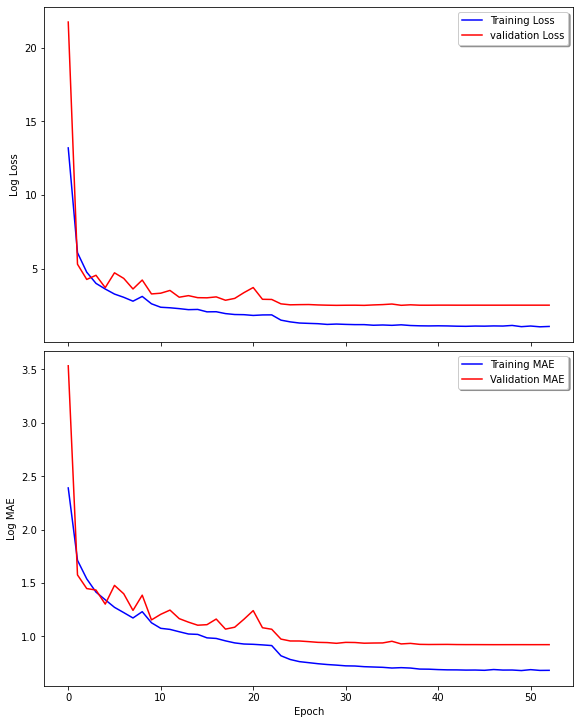

Predicted average MAE with using Train data: 0.5138757421532487
Predicted average MAE with using Dev data: 0.9244578446722626


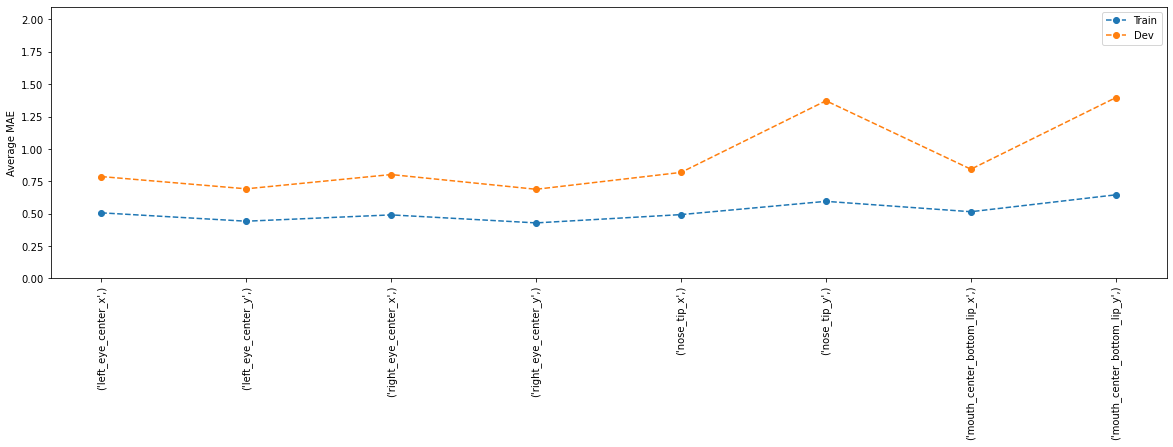

In [34]:
# Presenting the performance of the model in training
plot_hist(hist_pa)

# Error analysis
Ypa_pred_dev, dpa = error_analysis(base_model_p, Xpa_train, Xpa_dev, Ypa_train, Ypa_dev, keypoints_list_partial)

5315


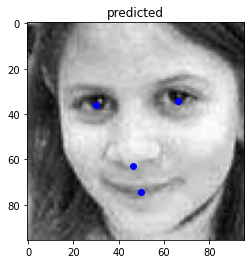

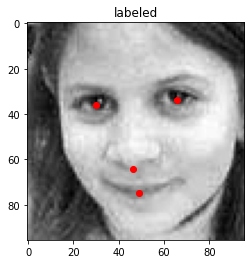

In [36]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
n = np.random.randint(len(Ypa_dev))
print(n)
plot_facial_keypoints(Xpa_dev[n],Ypa_pred_dev[n]+Ypas_mean, 'b', 'predicted')
plot_facial_keypoints(Xpa_dev[n],Ypa_dev[n]+Ypas_mean, 'r')

## Assess the model performance vs complexity (bias-variance tradeoff)

This step specifically helps us to decide about the direction we need to choose for better tuning the model. Considering that the complexity of a deep neural network can vary with many parameters and taking limitations on our computational resources, we decided to focus on the most obvious aspect of complexity which would be to increase the number of Conv2D layers (and consequently the number of filters per layer as going further) while all other hyperparameters fixed.

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 16.9182 - mae: 3.02 - ETA: 0s - loss: 81.1541 - mae: 5.93 - ETA: 0s - loss: 52.3232 - mae: 4.60 - ETA: 0s - loss: 40.1873 - mae: 3.97 - ETA: 0s - loss: 32.8589 - mae: 3.56 - ETA: 0s - loss: 28.4239 - mae: 3.31 - ETA: 0s - loss: 26.0832 - mae: 3.17 - ETA: 0s - loss: 23.0608 - mae: 2.99 - ETA: 0s - loss: 21.8672 - mae: 2.9279
Epoch 00001: val_mae improved from inf to 2.30112, saving model to best_model.hdf5
25/25 [==============================] - 1s 44ms/step - loss: 21.8672 - mae: 2.9279 - val_loss: 9.7510 - val_mae: 2.3011 - lr: 0.0010
Epoch 2/100
21/25 [========================>.....] - ETA: 0s - loss: 7.0528 - mae: 2.026 - ETA: 0s - loss: 7.3556 - mae: 2.022 - ETA: 0s - loss: 7.2977 - mae: 1.997 - ETA: 0s - loss: 7.2813 - mae: 1.980 - ETA: 0s - loss: 7.2547 - mae: 1.972 - ETA: 0s - loss: 7.1188 - mae: 1.9461
Epoch 00002: val_mae did not improve from 2.30112
25/25 [==============================] - 0s 15ms/step - lo

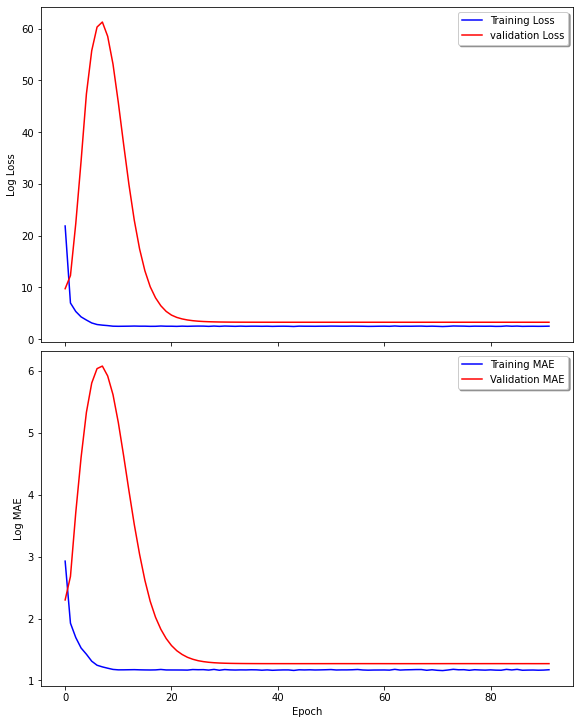

54/54 [==============================] - ETA: 0s - loss: 2.5092 - mae: 1.107 - ETA: 0s - loss: 2.0834 - mae: 1.051 - ETA: 0s - loss: 2.0162 - mae: 1.036 - ETA: 0s - loss: 2.0387 - mae: 1.045 - ETA: 0s - loss: 2.0190 - mae: 1.042 - ETA: 0s - loss: 2.1082 - mae: 1.061 - 0s 5ms/step - loss: 2.1654 - mae: 1.0718
[2.1654019355773926, 1.071803331375122]
14/14 [==============================] - ETA: 0s - loss: 3.4218 - mae: 1.218 - ETA: 0s - loss: 3.1455 - mae: 1.256 - 0s 6ms/step - loss: 3.3399 - mae: 1.2938
[3.33986234664917, 1.2937833070755005]
Epoch 1/100
21/25 [========================>.....] - ETA: 0s - loss: 14.8771 - mae: 2.92 - ETA: 0s - loss: 33.4048 - mae: 3.93 - ETA: 0s - loss: 23.5840 - mae: 3.29 - ETA: 0s - loss: 19.1045 - mae: 2.97 - ETA: 0s - loss: 16.5293 - mae: 2.76 - ETA: 0s - loss: 15.0767 - mae: 2.6436
Epoch 00001: val_mae did not improve from 1.27174
25/25 [==============================] - 1s 21ms/step - loss: 14.0242 - mae: 2.5534 - val_loss: 10.1020 - val_mae: 2.3560 

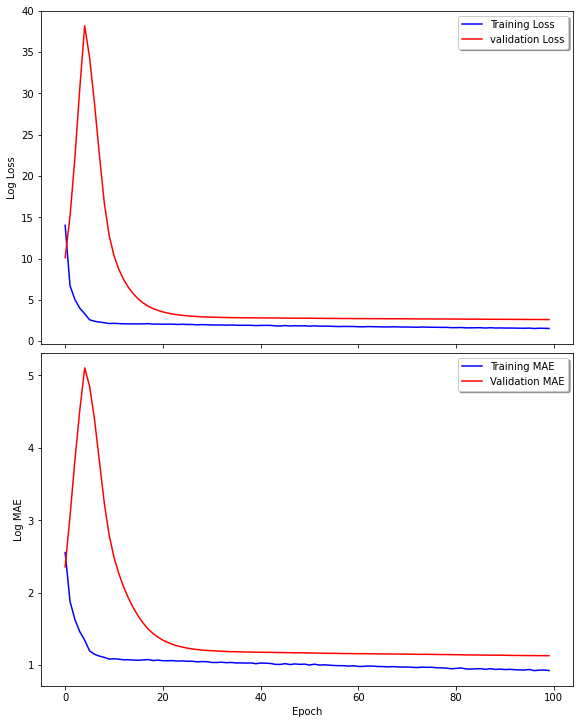

54/54 [==============================] - ETA: 0s - loss: 1.1480 - mae: 0.795 - ETA: 0s - loss: 1.1818 - mae: 0.800 - ETA: 0s - loss: 1.1287 - mae: 0.784 - ETA: 0s - loss: 1.1498 - mae: 0.791 - ETA: 0s - loss: 1.1656 - mae: 0.797 - 0s 5ms/step - loss: 1.3074 - mae: 0.8304
[1.3073903322219849, 0.8303953409194946]
14/14 [==============================] - ETA: 0s - loss: 3.0387 - mae: 1.144 - ETA: 0s - loss: 2.7051 - mae: 1.148 - 0s 4ms/step - loss: 2.8349 - mae: 1.1700
[2.8348844051361084, 1.1700338125228882]
Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 14.2300 - mae: 2.87 - ETA: 0s - loss: 18.8061 - mae: 3.14 - ETA: 0s - loss: 14.7816 - mae: 2.76 - ETA: 0s - loss: 12.8609 - mae: 2.56 - ETA: 0s - loss: 11.9527 - mae: 2.47 - ETA: 0s - loss: 11.1267 - mae: 2.38 - ETA: 0s - loss: 10.7890 - mae: 2.3472
Epoch 00001: val_mae did not improve from 1.12940
25/25 [==============================] - 1s 23ms/step - loss: 10.7890 - mae: 2.3472 - val_loss: 10.9179 - val_mae: 2.45

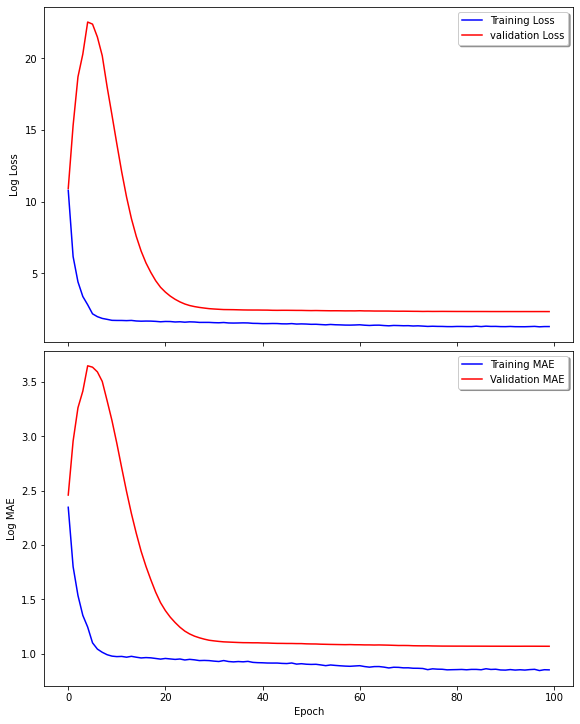

54/54 [==============================] - ETA: 0s - loss: 0.9736 - mae: 0.739 - ETA: 0s - loss: 1.0201 - mae: 0.747 - ETA: 0s - loss: 0.9822 - mae: 0.732 - ETA: 0s - loss: 0.9977 - mae: 0.738 - ETA: 0s - loss: 0.9921 - mae: 0.738 - 0s 5ms/step - loss: 1.1265 - mae: 0.7718
[1.126542568206787, 0.7718337774276733]
14/14 [==============================] - ETA: 0s - loss: 2.2887 - mae: 1.026 - ETA: 0s - loss: 2.3200 - mae: 1.070 - 0s 5ms/step - loss: 2.4291 - mae: 1.0900
[2.4290740489959717, 1.089951753616333]
Epoch 1/100
23/25 [==========================>...] - ETA: 0s - loss: 13.0204 - mae: 2.68 - ETA: 0s - loss: 16.7153 - mae: 3.02 - ETA: 0s - loss: 13.9659 - mae: 2.71 - ETA: 0s - loss: 12.1264 - mae: 2.52 - ETA: 0s - loss: 11.1902 - mae: 2.42 - ETA: 0s - loss: 10.7028 - mae: 2.36 - ETA: 0s - loss: 10.3394 - mae: 2.3212
Epoch 00001: val_mae did not improve from 1.06888
25/25 [==============================] - 1s 23ms/step - loss: 10.3384 - mae: 2.3197 - val_loss: 10.0295 - val_mae: 2.3416

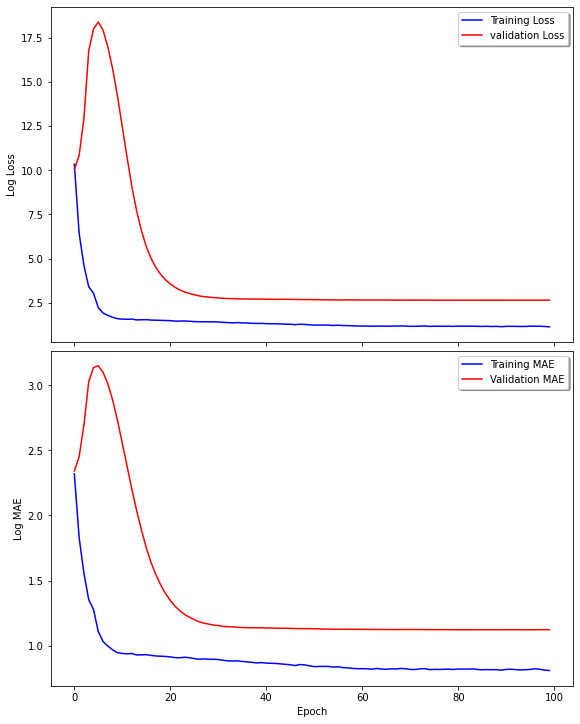

54/54 [==============================] - ETA: 0s - loss: 0.9337 - mae: 0.720 - ETA: 0s - loss: 0.9432 - mae: 0.719 - ETA: 0s - loss: 0.9046 - mae: 0.708 - ETA: 0s - loss: 0.8866 - mae: 0.704 - ETA: 0s - loss: 0.8795 - mae: 0.703 - ETA: 0s - loss: 1.0365 - mae: 0.740 - 0s 5ms/step - loss: 1.0607 - mae: 0.7477
[1.0607008934020996, 0.7477145791053772]
14/14 [==============================] - ETA: 0s - loss: 2.9083 - mae: 1.134 - ETA: 0s - loss: 2.6261 - mae: 1.131 - 0s 5ms/step - loss: 2.7064 - mae: 1.1441
[2.7064101696014404, 1.1440739631652832]
Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 11.6986 - mae: 2.58 - ETA: 0s - loss: 11.1871 - mae: 2.48 - ETA: 0s - loss: 10.6991 - mae: 2.41 - ETA: 0s - loss: 10.3782 - mae: 2.37 - ETA: 0s - loss: 9.7233 - mae: 2.2878 - ETA: 0s - loss: 9.4055 - mae: 2.249 - ETA: 0s - loss: 8.9894 - mae: 2.191 - ETA: 0s - loss: 8.7604 - mae: 2.153 - ETA: 0s - loss: 8.5811 - mae: 2.1303
Epoch 00001: val_mae did not improve from 1.06888
25/25

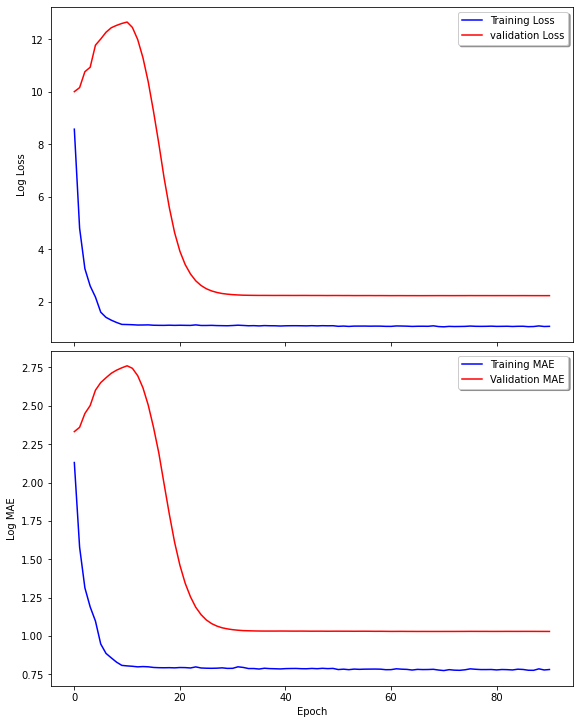

54/54 [==============================] - ETA: 0s - loss: 0.8477 - mae: 0.696 - ETA: 0s - loss: 0.9033 - mae: 0.702 - ETA: 0s - loss: 0.9673 - mae: 0.698 - ETA: 0s - loss: 0.9304 - mae: 0.696 - ETA: 0s - loss: 0.9003 - mae: 0.691 - ETA: 0s - loss: 1.0156 - mae: 0.721 - 0s 5ms/step - loss: 1.0304 - mae: 0.7267
[1.0303970575332642, 0.7266517281532288]
14/14 [==============================] - ETA: 0s - loss: 2.9577 - mae: 1.059 - ETA: 0s - loss: 2.3125 - mae: 1.052 - 0s 5ms/step - loss: 2.3660 - mae: 1.0650
[2.3660166263580322, 1.0650421380996704]
Epoch 1/100
23/25 [==========================>...] - ETA: 0s - loss: 15.0453 - mae: 2.85 - ETA: 0s - loss: 11.5809 - mae: 2.50 - ETA: 0s - loss: 10.2158 - mae: 2.34 - ETA: 0s - loss: 9.8070 - mae: 2.2932 - ETA: 0s - loss: 9.6456 - mae: 2.266 - ETA: 0s - loss: 9.5061 - mae: 2.233 - ETA: 0s - loss: 9.1138 - mae: 2.188 - ETA: 0s - loss: 8.8947 - mae: 2.1559
Epoch 00001: val_mae did not improve from 1.02874
25/25 [==============================] - 1s

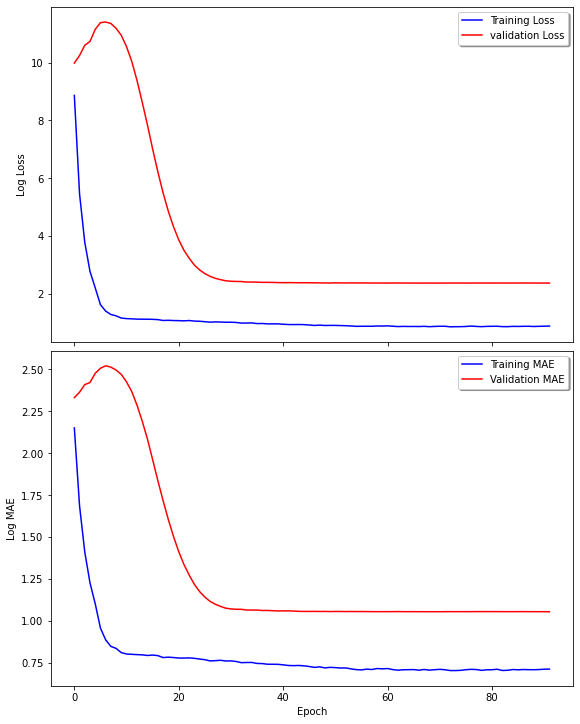

54/54 [==============================] - ETA: 0s - loss: 0.6437 - mae: 0.612 - ETA: 0s - loss: 0.6748 - mae: 0.610 - ETA: 0s - loss: 0.6720 - mae: 0.607 - ETA: 0s - loss: 0.6606 - mae: 0.605 - ETA: 0s - loss: 0.6545 - mae: 0.604 - ETA: 0s - loss: 0.8242 - mae: 0.649 - 0s 5ms/step - loss: 0.8329 - mae: 0.6525
[0.8328685760498047, 0.652495265007019]
14/14 [==============================] - ETA: 0s - loss: 2.9585 - mae: 1.086 - ETA: 0s - loss: 2.3841 - mae: 1.065 - 0s 5ms/step - loss: 2.5033 - mae: 1.0837
[2.503262996673584, 1.0837106704711914]


In [21]:
# remove the mean the keypoint values
Yf1_mean = np.mean(Yf1, axis = 0)
Yf1_n = (Yf1 - Yf1_mean)

# split the data into the train and dev datasets with 80% to 20%
Xf_train, Xf_dev, Yf_train, Yf_dev = train_test_split(Xf1, Yf1_n, test_size=0.2, random_state=46)

# Delete unused data to reduce memory
del  Yf1_n

# Define necessary callbacks: will be used with every model
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(patience=25, restore_best_weights=True, mode='min')
adjust_lr =  ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=0, factor=.1, min_lr=.00000001)                        
callbacks = [checkpointer, early_stop, adjust_lr]

# list of filters
filts = [16, 32, 64, 128, 256, 512]
# the size of the dense layer
dense = 750
# list of parameters indicating the kernel size
ks_list = [5,4,3,3,3,2]
# dropout probability
dropout = 0.1

bias = []
var = []

# increase the model complexity by adding more Conv2D layer and also more filters in each layer as we go further
for n_layer in range(2, 8):
    #build the model
    model = create_CNN_model(n_out = 30, layers = n_layer, filters = filts[:n_layer], dense_unit = dense, ks = ks_list[:n_layer], \
                               lr = 0.01, mpls = 2, drpout = dropout, reg = {}, padding = 'same', activation_last = 'relu')

    # compile the model
    model.compile(optimizer = 'adam', 
                  loss = "mse", 
                  metrics = ["mae"])

    # Fit and validate the model with fully-populated base dataset
    hist = model.fit(
                Xf_train, Yf_train,
                epochs= 100, batch_size=64,
                validation_split=0.1,
                callbacks=callbacks,
                verbose=1
                )

    # Presenting the performance of the model in training
    plot_hist(hist)

    # Error analysis: update the values for 
    bias.append([model.evaluate(Xf_train, Yf_train)[0], model.evaluate(Xf_dev, Yf_dev)[0]])
    var.append([model.evaluate(Xf_train, Yf_train)[1], model.evaluate(Xf_dev, Yf_dev)[1]])

    del model, hist

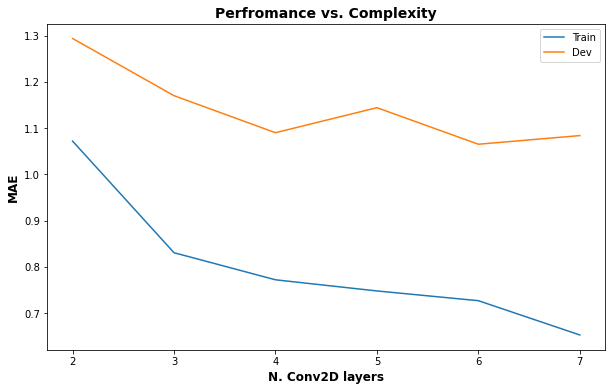

In [25]:
# plotting the results
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(np.array(var)[:,0], label = 'Train')
plt.plot(np.array(var)[:,1], label = 'Dev')
plt.title('Perfromance vs. Complexity', fontsize = 14, fontweight = 'bold')
plt.xlabel('N. Conv2D layers', fontsize = 12, fontweight = 'bold')
plt.ylabel('MAE', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), range(2,8))
plt.legend()
plt.show()

## Hyperparameter tuning


We are going to use grid search from the scikit-learn library to tune the hyperparameters of Keras deep learning model.
We create a hypermodel from our base model and  wrap it with the KerasRegressor class. The constructor for the KerasClassifier class will take default arguments that are passed on to the calls to model.fit(), such as the number of epochs and the batch size.It also take new arguments that can be passed to the custom create_hypermodel() function


In [ ]:
def create_hypermodel(layer_count=5,
                     hidden_layers =[32,64,128, 256, 512],
                     kernel_sizes = [3,3,3,3,3],
                     dropout_rate = 0.1,
                     optimizer = 'adam',
                     learning_rate = 0.01,
                     momentum = 0.9,
                     loss = "mse",
                     metrics =  ["mae"],
                     dense_unit = 512,
                     drpout = 0.1, 
                     n_input = 100, n_class = 2):
    
    #create model  
    model_tuning = create_CNN_model(n_out = 30, layers=layer_count, filters = hidden_layers, dense_unit = 512, ks = kernel_sizes,reg =  {'l1': 0.01, 'l2': 0.01}, lr = learning_rate, mpls = 2, drpout = dropout_rate, padding = 'same', activation_last = 'relu')     

    if optimizer == "SGD":
        opt = SGD(lr= learning_rate, momentum= momentum)
    else :
        opt = optimizer
    model_tuning.compile(optimizer = opt, 
              loss =loss, 
              metrics = "mae")
    
    return model_tuning

In [ ]:
#Keras Classifier vs Regressor
#model_keras = KerasClassifier(build_fn = create_hypermodel)

model_keras = KerasRegressor(build_fn = create_hypermodel)

We are going to try to these hyperparameters
-Number of Layers in our architecture
-Batch size and training epochs.
-Otimization algorithms.
-Dropout regularization.
-Dense Unit



In [ ]:
#Hyperparameters options


keras_param_options = {
    'epochs': [100,150,200],
    'batch_size': [16,32,64],
    'optimizer': ['RMSprop', 'adam', 'adamax'],
    'layer_count':[3,4,5],
    'dense_unit':  [256, 512],
    'drpout':[0.1, 0.3, 0.6]
} 
# After seperate tuning, we decide to use  {'l1': 0.001, 'l2': 0.001} and  learning rate=0.1 as default value 

In [ ]:
#Call-backs with patience= 10, 20. We also decide to use the original callbacks as default after tuning these seperately.
callbacks_20 = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, mode='min'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=.1, min_lr=.0000001)]

callbacks_10 = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, mode='min'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=.1, min_lr=.0000001)]



In [ ]:
# split the full augmented data into the train and dev datasets
#create dataset for tuning (cross validation k=3)
Xfa_tuning, Xfa_tuning_test, Yfa_tuning, Yfa_tuning_test = train_test_split(Xfa_train, Yfa_train,  \
                                                                            test_size=0.2, random_state= 42)


In [ ]:
#Run GridSearchCV. We also tried RandomizedSearchCV
#set up gridsearch 
tuning_keras = GridSearchCV(estimator=model_keras,param_grid=keras_param_options, scoring='accuracy' , n_jobs=-1, cv=3, )
#start fitting with the tuning data set above
grid_result = tuning_keras.fit(Xfa_tuning, Yfa_tuning) #tried with different datasets...Xfa_train, Yfa_train, Xf_train, Yf_train 

In [ ]:
685/685 [==============================] - ETA: 0s - loss: 12.6221 - mae: 2.39 - ETA: 7s - loss: 16.2112 - mae: 2.38 - ETA: 7s - loss: 17.2810 - mae: 2.44 - ETA: 8s - loss: 17.8423 - mae: 2.48 - ETA: 8s - loss: 17.9526 - mae: 2.49 - ETA: 8s - loss: 17.9662 - mae: 2.47 - ETA: 8s - loss: 18.0341 - mae: 2.46 - ETA: 8s - loss: 18.0221 - mae: 2.45 - ETA: 8s - loss: 17.9435 - mae: 2.46 - ETA: 8s - loss: 18.0375 - mae: 2.46 - ETA: 8s - loss: 17.8332 - mae: 2.45 - ETA: 8s - loss: 17.9013 - mae: 2.45 - ETA: 8s - loss: 17.8924 - mae: 2.44 - ETA: 8s - loss: 17.7597 - mae: 2.43 - ETA: 7s - loss: 17.8479 - mae: 2.43 - ETA: 7s - loss: 17.8002 - mae: 2.44 - ETA: 7s - loss: 17.7903 - mae: 2.43 - ETA: 7s - loss: 17.7704 - mae: 2.43 - ETA: 7s - loss: 17.7887 - mae: 2.44 - ETA: 7s - loss: 17.9523 - mae: 2.45 - ETA: 7s - loss: 18.0528 - mae: 2.45 - ETA: 7s - loss: 17.9370 - mae: 2.45 - ETA: 7s - loss: 18.0283 - mae: 2.45 - ETA: 7s - loss: 18.0453 - mae: 2.45 - ETA: 7s - loss: 18.0146 - mae: 2.45 - ETA: 7s - loss: 18.0099 - mae: 2.45 - ETA: 7s - loss: 17.8794 - mae: 2.44 - ETA: 7s - loss: 17.8754 - mae: 2.44 - ETA: 7s - loss: 17.8484 - mae: 2.43 - ETA: 7s - loss: 17.8664 - mae: 2.43 - ETA: 7s - loss: 17.9024 - mae: 2.43 - ETA: 7s - loss: 17.9962 - mae: 2.44 - ETA: 7s - loss: 18.0340 - mae: 2.44 - ETA: 6s - loss: 18.1006 - mae: 2.45 - ETA: 6s - loss: 18.0944 - mae: 2.45 - ETA: 6s - loss: 17.9666 - mae: 2.44 - ETA: 6s - loss: 17.9971 - mae: 2.44 - ETA: 6s - loss: 17.9938 - mae: 2.44 - ETA: 6s - loss: 18.0011 - mae: 2.44 - ETA: 6s - loss: 17.9858 - mae: 2.44 - ETA: 6s - loss: 17.9536 - mae: 2.43 - ETA: 6s - loss: 17.9823 - mae: 2.44 - ETA: 6s - loss: 17.9753 - mae: 2.43 - ETA: 6s - loss: 17.9208 - mae: 2.43 - ETA: 6s - loss: 17.8545 - mae: 2.42 - ETA: 6s - loss: 17.9354 - mae: 2.43 - ETA: 6s - loss: 17.9297 - mae: 2.43 - ETA: 6s - loss: 17.9253 - mae: 2.43 - ETA: 6s - loss: 17.9136 - mae: 2.43 - ETA: 6s - loss: 17.9194 - mae: 2.43 - ETA: 6s - loss: 17.8914 - mae: 2.43 - ETA: 5s - loss: 17.8656 - mae: 2.42 - ETA: 5s - loss: 17.8860 - mae: 2.42 - ETA: 5s - loss: 17.8958 - mae: 2.43 - ETA: 5s - loss: 17.9141 - mae: 2.43 - ETA: 5s - loss: 17.9184 - mae: 2.43 - ETA: 5s - loss: 17.9356 - mae: 2.43 - ETA: 5s - loss: 17.9162 - mae: 2.43 - ETA: 5s - loss: 17.9428 - mae: 2.43 - ETA: 5s - loss: 17.9378 - mae: 2.43 - ETA: 5s - loss: 17.9086 - mae: 2.43 - ETA: 5s - loss: 17.8953 - mae: 2.43 - ETA: 5s - loss: 17.9037 - mae: 2.43 - ETA: 5s - loss: 17.8931 - mae: 2.43 - ETA: 5s - loss: 17.8889 - mae: 2.43 - ETA: 5s - loss: 17.8725 - mae: 2.43 - ETA: 5s - loss: 17.8650 - mae: 2.42 - ETA: 5s - loss: 17.8289 - mae: 2.42 - ETA: 5s - loss: 17.8748 - mae: 2.43 - ETA: 5s - loss: 17.8240 - mae: 2.42 - ETA: 4s - loss: 17.8116 - mae: 2.42 - ETA: 4s - loss: 17.7914 - mae: 2.42 - ETA: 4s - loss: 17.7701 - mae: 2.42 - ETA: 4s - loss: 17.7874 - mae: 2.42 - ETA: 4s - loss: 17.7835 - mae: 2.42 - ETA: 4s - loss: 17.7785 - mae: 2.42 - ETA: 4s - loss: 17.8050 - mae: 2.42 - ETA: 4s - loss: 17.8034 - mae: 2.42 - ETA: 4s - loss: 17.8094 - mae: 2.42 - ETA: 4s - loss: 17.8259 - mae: 2.42 - ETA: 4s - loss: 17.8246 - mae: 2.42 - ETA: 4s - loss: 17.8220 - mae: 2.42 - ETA: 4s - loss: 17.8523 - mae: 2.42 - ETA: 4s - loss: 17.8502 - mae: 2.42 - ETA: 4s - loss: 17.8501 - mae: 2.42 - ETA: 4s - loss: 17.8579 - mae: 2.42 - ETA: 4s - loss: 17.8520 - mae: 2.42 - ETA: 4s - loss: 17.8261 - mae: 2.42 - ETA: 3s - loss: 17.8278 - mae: 2.42 - ETA: 3s - loss: 17.8237 - mae: 2.42 - ETA: 3s - loss: 17.8378 - mae: 2.42 - ETA: 3s - loss: 17.8230 - mae: 2.42 - ETA: 3s - loss: 17.8213 - mae: 2.42 - ETA: 3s - loss: 17.8350 - mae: 2.42 - ETA: 3s - loss: 17.8233 - mae: 2.42 - ETA: 3s - loss: 17.8191 - mae: 2.42 - ETA: 3s - loss: 17.8130 - mae: 2.42 - ETA: 3s - loss: 17.7908 - mae: 2.42 - ETA: 3s - loss: 17.8158 - mae: 2.42 - ETA: 3s - loss: 17.8433 - mae: 2.42 - ETA: 3s - loss: 17.8483 - mae: 2.42 - ETA: 3s - loss: 17.8508 - mae: 2.42 - ETA: 3s - loss: 17.8541 - mae: 2.42 - ETA: 3s - loss: 17.8460 - mae: 2.43 - ETA: 3s - loss: 17.8544 - mae: 2.43 - ETA: 3s - loss: 17.8427 - mae: 2.42 - ETA: 2s - loss: 17.8442 - mae: 2.42 - ETA: 2s - loss: 17.8575 - mae: 2.42 - ETA: 2s - loss: 17.8562 - mae: 2.43 - ETA: 2s - loss: 17.8582 - mae: 2.43 - ETA: 2s - loss: 17.8496 - mae: 2.42 - ETA: 2s - loss: 17.8563 - mae: 2.42 - ETA: 2s - loss: 17.8610 - mae: 2.43 - ETA: 2s - loss: 17.8750 - mae: 2.43 - ETA: 2s - loss: 17.8862 - mae: 2.43 - ETA: 2s - loss: 17.8883 - mae: 2.43 - ETA: 2s - loss: 17.8969 - mae: 2.43 - ETA: 2s - loss: 17.8953 - mae: 2.43 - ETA: 2s - loss: 17.8989 - mae: 2.43 - ETA: 2s - loss: 17.8986 - mae: 2.43 - ETA: 2s - loss: 17.8924 - mae: 2.43 - ETA: 2s - loss: 17.8794 - mae: 2.43 - ETA: 2s - loss: 17.8741 - mae: 2.43 - ETA: 2s - loss: 17.8745 - mae: 2.43 - ETA: 2s - loss: 17.8789 - mae: 2.43 - ETA: 2s - loss: 17.8854 - mae: 2.43 - ETA: 1s - loss: 17.8609 - mae: 2.43 - ETA: 1s - loss: 17.8579 - mae: 2.43 - ETA: 1s - loss: 17.8679 - mae: 2.43 - ETA: 1s - loss: 17.8630 - mae: 2.43 - ETA: 1s - loss: 17.8537 - mae: 2.43 - ETA: 1s - loss: 17.8383 - mae: 2.42 - ETA: 1s - loss: 17.8541 - mae: 2.43 - ETA: 1s - loss: 17.8811 - mae: 2.43 - ETA: 1s - loss: 17.8841 - mae: 2.43 - ETA: 1s - loss: 17.8770 - mae: 2.43 - ETA: 1s - loss: 17.8967 - mae: 2.43 - ETA: 1s - loss: 17.8911 - mae: 2.43 - ETA: 1s - loss: 17.8902 - mae: 2.43 - ETA: 1s - loss: 17.8768 - mae: 2.43 - ETA: 1s - loss: 17.8747 - mae: 2.43 - ETA: 1s - loss: 17.8720 - mae: 2.43 - ETA: 1s - loss: 17.8664 - mae: 2.43 - ETA: 1s - loss: 17.8684 - mae: 2.43 - ETA: 1s - loss: 17.8798 - mae: 2.43 - ETA: 0s - loss: 17.8899 - mae: 2.43 - ETA: 0s - loss: 17.8953 - mae: 2.43 - ETA: 0s - loss: 17.8855 - mae: 2.43 - ETA: 0s - loss: 17.8746 - mae: 2.43 - ETA: 0s - loss: 17.8776 - mae: 2.43 - ETA: 0s - loss: 17.8703 - mae: 2.43 - ETA: 0s - loss: 17.8705 - mae: 2.43 - ETA: 0s - loss: 17.8703 - mae: 2.43 - ETA: 0s - loss: 17.8974 - mae: 2.43 - ETA: 0s - loss: 17.8956 - mae: 2.43 - ETA: 0s - loss: 17.9055 - mae: 2.43 - ETA: 0s - loss: 17.8961 - mae: 2.43 - ETA: 0s - loss: 17.8958 - mae: 2.43 - ETA: 0s - loss: 17.9096 - mae: 2.43 - ETA: 0s - loss: 17.9038 - mae: 2.43 - ETA: 0s - loss: 17.8992 - mae: 2.43 - ETA: 0s - loss: 17.8900 - mae: 2.43 - ETA: 0s - loss: 17.8847 - mae: 2.43 - ETA: 0s - loss: 17.8841 - mae: 2.43 - 9s 13ms/step - loss: 17.8864 - mae: 2.4339

In [ ]:
# summarize results
print("Best Model using %s" % ( grid_result.best_params_))
#Get best parameters for final model
best_epoch = grid_result.best_params_["epochs"]
best_batch_size = grid_result.best_params_["batch_size"]
best_layers = grid_result.best_params_["layer_count"]
best_optimizer =  grid_result.best_params_["optimizer"]
best_dense_unit = grid_result.best_params_["dense_unit"]
best_drpout=  grid_result.best_params_["drpout"]

#Best Model using {'batch_size': 16, 'dense_unit': 256, 'drpout': 0.1, 'epochs': 100, 'layer_count': 3, 'optimizer': 'RMSprop'}best_learning_rate = 0.01 

## Run the _best model_ on the full-populated augmented data

### without regularization

In [41]:
#Final model

model_final = create_CNN_model(n_out = 30, layers=best_layers, filters = [32,64,128,256, 512], dense_unit = best_dense_unit, ks = [5,3,3,3,3], \
                           lr = 0.1, mpls = 2, drpout = best_drpout, padding = 'same', activation_last = 'relu')

model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 32)        800       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)       

In [42]:
#compile final model
model_final.compile(optimizer = best_optimizer , 
               loss = "mse", 
               metrics=["mae"])

In [45]:
# Fit and validate the model with augmented dataset
hist_final = model_final.fit(Xfa_train, Yfa_train,
            epochs= best_epoch, batch_size=best_batch_size,
            validation_split=0.1,
            callbacks = callbacks,
            verbose=1)

Epoch 1/100
771/771 [==============================] - ETA: 0s - loss: 284.1607 - mae: 3.551 - ETA: 7s - loss: 370.8699 - mae: 7.663 - ETA: 8s - loss: 271.8098 - mae: 5.604 - ETA: 8s - loss: 217.2153 - mae: 4.582 - ETA: 8s - loss: 187.5916 - mae: 4.108 - ETA: 8s - loss: 168.7198 - mae: 3.857 - ETA: 8s - loss: 158.4250 - mae: 3.721 - ETA: 8s - loss: 148.0852 - mae: 3.586 - ETA: 8s - loss: 139.7854 - mae: 3.475 - ETA: 8s - loss: 133.2739 - mae: 3.388 - ETA: 8s - loss: 127.7351 - mae: 3.299 - ETA: 8s - loss: 122.8116 - mae: 3.250 - ETA: 8s - loss: 119.0843 - mae: 3.248 - ETA: 8s - loss: 115.4931 - mae: 3.214 - ETA: 8s - loss: 111.9380 - mae: 3.161 - ETA: 8s - loss: 109.0221 - mae: 3.139 - ETA: 8s - loss: 106.1031 - mae: 3.113 - ETA: 8s - loss: 103.7090 - mae: 3.101 - ETA: 7s - loss: 101.1771 - mae: 3.074 - ETA: 7s - loss: 99.3318 - mae: 3.053 - ETA: 7s - loss: 97.2672 - mae: 3.03 - ETA: 7s - loss: 95.4077 - mae: 3.02 - ETA: 7s - loss: 93.7220 - mae: 3.00 - ETA: 7s - loss: 91.9697 - mae: 2

768/771 [============================>.] - ETA: 0s - loss: 12.1627 - mae: 1.86 - ETA: 7s - loss: 11.5726 - mae: 1.83 - ETA: 7s - loss: 12.0638 - mae: 1.89 - ETA: 8s - loss: 12.3536 - mae: 1.91 - ETA: 8s - loss: 12.2109 - mae: 1.89 - ETA: 8s - loss: 12.0163 - mae: 1.87 - ETA: 8s - loss: 11.6456 - mae: 1.84 - ETA: 8s - loss: 11.9180 - mae: 1.86 - ETA: 8s - loss: 11.6749 - mae: 1.84 - ETA: 8s - loss: 11.4486 - mae: 1.81 - ETA: 8s - loss: 11.8799 - mae: 1.84 - ETA: 8s - loss: 11.9696 - mae: 1.84 - ETA: 8s - loss: 11.9531 - mae: 1.84 - ETA: 8s - loss: 11.8769 - mae: 1.83 - ETA: 8s - loss: 11.9025 - mae: 1.83 - ETA: 8s - loss: 11.9003 - mae: 1.83 - ETA: 8s - loss: 11.7404 - mae: 1.82 - ETA: 8s - loss: 12.0488 - mae: 1.84 - ETA: 7s - loss: 12.0753 - mae: 1.84 - ETA: 7s - loss: 12.0485 - mae: 1.84 - ETA: 7s - loss: 11.9396 - mae: 1.83 - ETA: 7s - loss: 11.9704 - mae: 1.83 - ETA: 7s - loss: 11.9806 - mae: 1.83 - ETA: 7s - loss: 11.9053 - mae: 1.82 - ETA: 7s - loss: 11.8270 - mae: 1.82 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 7.4441 - mae: 1.347 - ETA: 7s - loss: 6.3186 - mae: 1.287 - ETA: 7s - loss: 6.3764 - mae: 1.308 - ETA: 8s - loss: 6.3352 - mae: 1.284 - ETA: 8s - loss: 6.2953 - mae: 1.281 - ETA: 8s - loss: 6.1909 - mae: 1.270 - ETA: 8s - loss: 6.2211 - mae: 1.276 - ETA: 8s - loss: 6.1551 - mae: 1.265 - ETA: 8s - loss: 6.1535 - mae: 1.268 - ETA: 8s - loss: 6.0978 - mae: 1.262 - ETA: 8s - loss: 6.1069 - mae: 1.262 - ETA: 8s - loss: 6.0620 - mae: 1.259 - ETA: 8s - loss: 6.0077 - mae: 1.245 - ETA: 8s - loss: 5.9809 - mae: 1.246 - ETA: 8s - loss: 6.0030 - mae: 1.246 - ETA: 8s - loss: 5.9856 - mae: 1.246 - ETA: 8s - loss: 5.9717 - mae: 1.248 - ETA: 8s - loss: 5.9557 - mae: 1.244 - ETA: 7s - loss: 5.9650 - mae: 1.247 - ETA: 7s - loss: 5.9699 - mae: 1.247 - ETA: 7s - loss: 5.9557 - mae: 1.245 - ETA: 7s - loss: 5.9443 - mae: 1.244 - ETA: 7s - loss: 5.9883 - mae: 1.249 - ETA: 7s - loss: 6.0082 - mae: 1.252 - ETA: 7s - loss: 6.0110 - mae: 1.251 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 6.4333 - mae: 1.344 - ETA: 7s - loss: 5.5235 - mae: 1.188 - ETA: 7s - loss: 4.9828 - mae: 1.110 - ETA: 8s - loss: 5.0751 - mae: 1.121 - ETA: 8s - loss: 5.1320 - mae: 1.115 - ETA: 8s - loss: 5.1355 - mae: 1.121 - ETA: 8s - loss: 5.0982 - mae: 1.116 - ETA: 8s - loss: 5.1080 - mae: 1.120 - ETA: 8s - loss: 5.0732 - mae: 1.118 - ETA: 8s - loss: 5.0759 - mae: 1.120 - ETA: 8s - loss: 5.0816 - mae: 1.119 - ETA: 8s - loss: 5.1750 - mae: 1.131 - ETA: 8s - loss: 5.1727 - mae: 1.133 - ETA: 8s - loss: 5.1653 - mae: 1.133 - ETA: 8s - loss: 5.1477 - mae: 1.133 - ETA: 8s - loss: 5.1033 - mae: 1.126 - ETA: 8s - loss: 5.1231 - mae: 1.126 - ETA: 7s - loss: 5.1101 - mae: 1.125 - ETA: 7s - loss: 5.0846 - mae: 1.120 - ETA: 7s - loss: 5.0734 - mae: 1.116 - ETA: 7s - loss: 5.0627 - mae: 1.113 - ETA: 7s - loss: 5.0798 - mae: 1.113 - ETA: 7s - loss: 5.1166 - mae: 1.119 - ETA: 7s - loss: 5.1192 - mae: 1.120 - ETA: 7s - loss: 5.0966 - mae: 1.116 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 4.8521 - mae: 1.256 - ETA: 7s - loss: 5.0861 - mae: 1.096 - ETA: 7s - loss: 4.7730 - mae: 1.044 - ETA: 8s - loss: 4.6359 - mae: 1.034 - ETA: 9s - loss: 4.5857 - mae: 1.026 - ETA: 9s - loss: 4.6703 - mae: 1.046 - ETA: 9s - loss: 4.7202 - mae: 1.057 - ETA: 9s - loss: 4.7879 - mae: 1.068 - ETA: 9s - loss: 4.8127 - mae: 1.067 - ETA: 8s - loss: 4.7554 - mae: 1.061 - ETA: 8s - loss: 4.7264 - mae: 1.057 - ETA: 8s - loss: 4.7810 - mae: 1.068 - ETA: 8s - loss: 4.7714 - mae: 1.069 - ETA: 8s - loss: 4.7624 - mae: 1.065 - ETA: 8s - loss: 4.8281 - mae: 1.076 - ETA: 8s - loss: 4.8204 - mae: 1.074 - ETA: 8s - loss: 4.8369 - mae: 1.080 - ETA: 8s - loss: 4.8187 - mae: 1.075 - ETA: 8s - loss: 4.8076 - mae: 1.074 - ETA: 8s - loss: 4.8274 - mae: 1.076 - ETA: 8s - loss: 4.8398 - mae: 1.079 - ETA: 7s - loss: 4.8192 - mae: 1.076 - ETA: 7s - loss: 4.8286 - mae: 1.077 - ETA: 7s - loss: 4.8465 - mae: 1.080 - ETA: 7s - loss: 4.8297 - mae: 1.077 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 3.4250 - mae: 0.953 - ETA: 7s - loss: 3.6183 - mae: 1.076 - ETA: 7s - loss: 3.5397 - mae: 1.097 - ETA: 8s - loss: 3.3483 - mae: 1.067 - ETA: 8s - loss: 3.2317 - mae: 1.052 - ETA: 8s - loss: 3.1674 - mae: 1.043 - ETA: 8s - loss: 3.1277 - mae: 1.039 - ETA: 8s - loss: 3.1426 - mae: 1.045 - ETA: 8s - loss: 3.0935 - mae: 1.035 - ETA: 8s - loss: 3.0686 - mae: 1.030 - ETA: 8s - loss: 3.0287 - mae: 1.022 - ETA: 8s - loss: 3.0016 - mae: 1.017 - ETA: 8s - loss: 2.9639 - mae: 1.010 - ETA: 8s - loss: 2.9496 - mae: 1.006 - ETA: 8s - loss: 2.9335 - mae: 1.004 - ETA: 8s - loss: 2.9207 - mae: 1.000 - ETA: 8s - loss: 2.9163 - mae: 0.999 - ETA: 8s - loss: 2.9231 - mae: 1.002 - ETA: 8s - loss: 2.8978 - mae: 0.995 - ETA: 8s - loss: 2.8835 - mae: 0.992 - ETA: 7s - loss: 2.8756 - mae: 0.991 - ETA: 7s - loss: 2.8576 - mae: 0.988 - ETA: 7s - loss: 2.8593 - mae: 0.988 - ETA: 7s - loss: 2.8549 - mae: 0.988 - ETA: 7s - loss: 2.8446 - mae: 0.987 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 2.2763 - mae: 0.871 - ETA: 7s - loss: 2.3460 - mae: 0.900 - ETA: 8s - loss: 2.2953 - mae: 0.881 - ETA: 8s - loss: 2.3580 - mae: 0.896 - ETA: 8s - loss: 2.3104 - mae: 0.887 - ETA: 8s - loss: 2.2987 - mae: 0.887 - ETA: 8s - loss: 2.3158 - mae: 0.890 - ETA: 8s - loss: 2.3430 - mae: 0.899 - ETA: 8s - loss: 2.3886 - mae: 0.910 - ETA: 8s - loss: 2.3921 - mae: 0.910 - ETA: 8s - loss: 2.3948 - mae: 0.911 - ETA: 8s - loss: 2.3902 - mae: 0.909 - ETA: 8s - loss: 2.4147 - mae: 0.913 - ETA: 8s - loss: 2.4329 - mae: 0.912 - ETA: 8s - loss: 2.4263 - mae: 0.913 - ETA: 8s - loss: 2.4206 - mae: 0.911 - ETA: 8s - loss: 2.4276 - mae: 0.912 - ETA: 8s - loss: 2.4287 - mae: 0.912 - ETA: 8s - loss: 2.4258 - mae: 0.911 - ETA: 7s - loss: 2.4239 - mae: 0.910 - ETA: 7s - loss: 2.4256 - mae: 0.912 - ETA: 8s - loss: 2.4267 - mae: 0.911 - ETA: 8s - loss: 2.4316 - mae: 0.912 - ETA: 8s - loss: 2.4248 - mae: 0.911 - ETA: 8s - loss: 2.4273 - mae: 0.912 - ETA: 8s

770/771 [============================>.] - ETA: 0s - loss: 2.2250 - mae: 0.880 - ETA: 7s - loss: 2.3266 - mae: 0.910 - ETA: 7s - loss: 2.2790 - mae: 0.874 - ETA: 8s - loss: 2.3785 - mae: 0.900 - ETA: 8s - loss: 2.3128 - mae: 0.886 - ETA: 8s - loss: 2.3151 - mae: 0.889 - ETA: 8s - loss: 2.2970 - mae: 0.887 - ETA: 8s - loss: 2.3125 - mae: 0.893 - ETA: 8s - loss: 2.3177 - mae: 0.895 - ETA: 8s - loss: 2.2935 - mae: 0.888 - ETA: 8s - loss: 2.2893 - mae: 0.887 - ETA: 8s - loss: 2.2668 - mae: 0.883 - ETA: 8s - loss: 2.2835 - mae: 0.888 - ETA: 7s - loss: 2.2765 - mae: 0.887 - ETA: 8s - loss: 2.2785 - mae: 0.889 - ETA: 8s - loss: 2.2745 - mae: 0.888 - ETA: 7s - loss: 2.2912 - mae: 0.891 - ETA: 7s - loss: 2.2861 - mae: 0.891 - ETA: 7s - loss: 2.3030 - mae: 0.894 - ETA: 7s - loss: 2.3040 - mae: 0.894 - ETA: 7s - loss: 2.2987 - mae: 0.892 - ETA: 7s - loss: 2.2929 - mae: 0.890 - ETA: 7s - loss: 2.2917 - mae: 0.888 - ETA: 7s - loss: 2.3068 - mae: 0.890 - ETA: 7s - loss: 2.3091 - mae: 0.891 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.1661 - mae: 0.832 - ETA: 7s - loss: 2.1483 - mae: 0.868 - ETA: 7s - loss: 2.2283 - mae: 0.877 - ETA: 8s - loss: 2.1656 - mae: 0.864 - ETA: 8s - loss: 2.1381 - mae: 0.856 - ETA: 8s - loss: 2.1919 - mae: 0.871 - ETA: 8s - loss: 2.1761 - mae: 0.867 - ETA: 8s - loss: 2.1843 - mae: 0.868 - ETA: 8s - loss: 2.1660 - mae: 0.863 - ETA: 8s - loss: 2.1732 - mae: 0.864 - ETA: 8s - loss: 2.1530 - mae: 0.859 - ETA: 8s - loss: 2.1440 - mae: 0.856 - ETA: 8s - loss: 2.1402 - mae: 0.854 - ETA: 8s - loss: 2.1401 - mae: 0.855 - ETA: 8s - loss: 2.1698 - mae: 0.861 - ETA: 8s - loss: 2.1910 - mae: 0.865 - ETA: 8s - loss: 2.2144 - mae: 0.869 - ETA: 7s - loss: 2.2199 - mae: 0.871 - ETA: 7s - loss: 2.2172 - mae: 0.870 - ETA: 7s - loss: 2.2105 - mae: 0.870 - ETA: 7s - loss: 2.1958 - mae: 0.867 - ETA: 7s - loss: 2.2002 - mae: 0.868 - ETA: 7s - loss: 2.2033 - mae: 0.870 - ETA: 7s - loss: 2.2074 - mae: 0.872 - ETA: 7s - loss: 2.2014 - mae: 0.871 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 2.0704 - mae: 0.872 - ETA: 7s - loss: 2.1330 - mae: 0.863 - ETA: 7s - loss: 2.2195 - mae: 0.871 - ETA: 7s - loss: 2.1902 - mae: 0.865 - ETA: 8s - loss: 2.1817 - mae: 0.869 - ETA: 8s - loss: 2.1791 - mae: 0.870 - ETA: 8s - loss: 2.1636 - mae: 0.869 - ETA: 8s - loss: 2.1521 - mae: 0.869 - ETA: 8s - loss: 2.1493 - mae: 0.868 - ETA: 8s - loss: 2.1488 - mae: 0.869 - ETA: 8s - loss: 2.1729 - mae: 0.875 - ETA: 8s - loss: 2.1748 - mae: 0.876 - ETA: 8s - loss: 2.1695 - mae: 0.874 - ETA: 7s - loss: 2.1581 - mae: 0.871 - ETA: 7s - loss: 2.1762 - mae: 0.874 - ETA: 7s - loss: 2.1962 - mae: 0.876 - ETA: 7s - loss: 2.1987 - mae: 0.877 - ETA: 7s - loss: 2.1872 - mae: 0.873 - ETA: 7s - loss: 2.1878 - mae: 0.874 - ETA: 7s - loss: 2.1855 - mae: 0.873 - ETA: 7s - loss: 2.1964 - mae: 0.876 - ETA: 7s - loss: 2.1868 - mae: 0.873 - ETA: 7s - loss: 2.1794 - mae: 0.872 - ETA: 7s - loss: 2.1900 - mae: 0.872 - ETA: 7s - loss: 2.1950 - mae: 0.873 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 2.2044 - mae: 0.898 - ETA: 8s - loss: 2.1795 - mae: 0.879 - ETA: 9s - loss: 2.1625 - mae: 0.870 - ETA: 9s - loss: 2.1542 - mae: 0.872 - ETA: 9s - loss: 2.1580 - mae: 0.871 - ETA: 10s - loss: 2.1544 - mae: 0.87 - ETA: 10s - loss: 2.1706 - mae: 0.87 - ETA: 11s - loss: 2.1934 - mae: 0.88 - ETA: 11s - loss: 2.1846 - mae: 0.88 - ETA: 11s - loss: 2.1941 - mae: 0.88 - ETA: 11s - loss: 2.2421 - mae: 0.89 - ETA: 11s - loss: 2.2321 - mae: 0.89 - ETA: 12s - loss: 2.2265 - mae: 0.89 - ETA: 12s - loss: 2.2382 - mae: 0.89 - ETA: 12s - loss: 2.2457 - mae: 0.89 - ETA: 11s - loss: 2.2175 - mae: 0.88 - ETA: 12s - loss: 2.2080 - mae: 0.88 - ETA: 12s - loss: 2.2092 - mae: 0.88 - ETA: 12s - loss: 2.1979 - mae: 0.88 - ETA: 11s - loss: 2.1874 - mae: 0.88 - ETA: 11s - loss: 2.1775 - mae: 0.87 - ETA: 11s - loss: 2.1849 - mae: 0.87 - ETA: 11s - loss: 2.1905 - mae: 0.87 - ETA: 11s - loss: 2.1866 - mae: 0.87 - ETA: 10s - loss: 2.1712 - mae: 0.87 - ETA: 10

770/771 [============================>.] - ETA: 0s - loss: 2.5717 - mae: 0.939 - ETA: 7s - loss: 1.9692 - mae: 0.808 - ETA: 8s - loss: 2.0282 - mae: 0.829 - ETA: 8s - loss: 2.0873 - mae: 0.857 - ETA: 8s - loss: 2.1323 - mae: 0.862 - ETA: 8s - loss: 2.1131 - mae: 0.860 - ETA: 8s - loss: 2.1349 - mae: 0.867 - ETA: 8s - loss: 2.1173 - mae: 0.862 - ETA: 8s - loss: 2.1055 - mae: 0.861 - ETA: 8s - loss: 2.1078 - mae: 0.863 - ETA: 8s - loss: 2.1063 - mae: 0.863 - ETA: 8s - loss: 2.0953 - mae: 0.859 - ETA: 8s - loss: 2.1359 - mae: 0.864 - ETA: 8s - loss: 2.1487 - mae: 0.867 - ETA: 8s - loss: 2.1424 - mae: 0.865 - ETA: 8s - loss: 2.1455 - mae: 0.865 - ETA: 8s - loss: 2.1414 - mae: 0.865 - ETA: 8s - loss: 2.1350 - mae: 0.865 - ETA: 7s - loss: 2.1397 - mae: 0.866 - ETA: 7s - loss: 2.1435 - mae: 0.868 - ETA: 7s - loss: 2.1347 - mae: 0.865 - ETA: 7s - loss: 2.1195 - mae: 0.863 - ETA: 7s - loss: 2.1243 - mae: 0.864 - ETA: 7s - loss: 2.1280 - mae: 0.865 - ETA: 7s - loss: 2.1438 - mae: 0.867 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.8147 - mae: 0.791 - ETA: 7s - loss: 1.8755 - mae: 0.817 - ETA: 7s - loss: 1.8777 - mae: 0.803 - ETA: 8s - loss: 1.9270 - mae: 0.814 - ETA: 8s - loss: 1.9682 - mae: 0.826 - ETA: 8s - loss: 1.9782 - mae: 0.828 - ETA: 8s - loss: 1.9769 - mae: 0.831 - ETA: 8s - loss: 1.9863 - mae: 0.834 - ETA: 8s - loss: 1.9895 - mae: 0.837 - ETA: 8s - loss: 2.0212 - mae: 0.847 - ETA: 8s - loss: 2.0060 - mae: 0.842 - ETA: 8s - loss: 1.9926 - mae: 0.838 - ETA: 8s - loss: 1.9987 - mae: 0.841 - ETA: 8s - loss: 1.9901 - mae: 0.838 - ETA: 7s - loss: 1.9856 - mae: 0.837 - ETA: 7s - loss: 1.9801 - mae: 0.835 - ETA: 7s - loss: 1.9820 - mae: 0.835 - ETA: 7s - loss: 1.9877 - mae: 0.836 - ETA: 7s - loss: 1.9903 - mae: 0.836 - ETA: 7s - loss: 1.9962 - mae: 0.838 - ETA: 7s - loss: 1.9918 - mae: 0.837 - ETA: 7s - loss: 1.9973 - mae: 0.839 - ETA: 7s - loss: 2.0022 - mae: 0.840 - ETA: 7s - loss: 1.9980 - mae: 0.839 - ETA: 7s - loss: 2.0041 - mae: 0.841 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 2.0787 - mae: 0.823 - ETA: 7s - loss: 2.0200 - mae: 0.848 - ETA: 7s - loss: 2.0901 - mae: 0.863 - ETA: 8s - loss: 2.0427 - mae: 0.852 - ETA: 8s - loss: 2.0471 - mae: 0.850 - ETA: 8s - loss: 2.0935 - mae: 0.860 - ETA: 8s - loss: 2.0557 - mae: 0.853 - ETA: 8s - loss: 2.0699 - mae: 0.858 - ETA: 8s - loss: 2.0456 - mae: 0.853 - ETA: 8s - loss: 2.0275 - mae: 0.847 - ETA: 8s - loss: 2.0379 - mae: 0.848 - ETA: 8s - loss: 2.0185 - mae: 0.843 - ETA: 8s - loss: 2.0263 - mae: 0.845 - ETA: 8s - loss: 2.0264 - mae: 0.846 - ETA: 8s - loss: 2.0246 - mae: 0.845 - ETA: 8s - loss: 2.0107 - mae: 0.842 - ETA: 8s - loss: 2.0092 - mae: 0.842 - ETA: 8s - loss: 2.0113 - mae: 0.843 - ETA: 8s - loss: 2.0197 - mae: 0.844 - ETA: 9s - loss: 2.0561 - mae: 0.850 - ETA: 9s - loss: 2.0443 - mae: 0.847 - ETA: 9s - loss: 2.0441 - mae: 0.848 - ETA: 9s - loss: 2.0318 - mae: 0.845 - ETA: 9s - loss: 2.0431 - mae: 0.847 - ETA: 9s - loss: 2.0523 - mae: 0.850 - ETA: 8s

771/771 [==============================] - ETA: 0s - loss: 2.2533 - mae: 0.788 - ETA: 7s - loss: 2.2160 - mae: 0.875 - ETA: 8s - loss: 2.1616 - mae: 0.845 - ETA: 8s - loss: 2.1092 - mae: 0.847 - ETA: 8s - loss: 2.0262 - mae: 0.838 - ETA: 8s - loss: 2.0119 - mae: 0.840 - ETA: 8s - loss: 1.9658 - mae: 0.832 - ETA: 8s - loss: 1.9311 - mae: 0.827 - ETA: 8s - loss: 1.8980 - mae: 0.823 - ETA: 8s - loss: 1.9003 - mae: 0.826 - ETA: 8s - loss: 1.8830 - mae: 0.825 - ETA: 8s - loss: 1.8636 - mae: 0.821 - ETA: 8s - loss: 1.8447 - mae: 0.817 - ETA: 8s - loss: 1.8323 - mae: 0.817 - ETA: 8s - loss: 1.8308 - mae: 0.817 - ETA: 7s - loss: 1.8156 - mae: 0.814 - ETA: 7s - loss: 1.8200 - mae: 0.816 - ETA: 7s - loss: 1.8145 - mae: 0.816 - ETA: 7s - loss: 1.8029 - mae: 0.813 - ETA: 7s - loss: 1.8150 - mae: 0.815 - ETA: 7s - loss: 1.8169 - mae: 0.818 - ETA: 7s - loss: 1.8184 - mae: 0.817 - ETA: 7s - loss: 1.8156 - mae: 0.818 - ETA: 7s - loss: 1.8172 - mae: 0.819 - ETA: 7s - loss: 1.8103 - mae: 0.818 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.9833 - mae: 0.845 - ETA: 8s - loss: 1.9432 - mae: 0.864 - ETA: 9s - loss: 1.8028 - mae: 0.827 - ETA: 10s - loss: 1.8083 - mae: 0.82 - ETA: 10s - loss: 1.8287 - mae: 0.83 - ETA: 10s - loss: 1.8391 - mae: 0.83 - ETA: 9s - loss: 1.8326 - mae: 0.8361 - ETA: 9s - loss: 1.7899 - mae: 0.824 - ETA: 9s - loss: 1.7702 - mae: 0.818 - ETA: 9s - loss: 1.7644 - mae: 0.817 - ETA: 9s - loss: 1.7837 - mae: 0.814 - ETA: 8s - loss: 1.7998 - mae: 0.820 - ETA: 8s - loss: 1.8027 - mae: 0.821 - ETA: 8s - loss: 1.7913 - mae: 0.819 - ETA: 8s - loss: 1.7863 - mae: 0.819 - ETA: 8s - loss: 1.7712 - mae: 0.815 - ETA: 8s - loss: 1.7777 - mae: 0.818 - ETA: 8s - loss: 1.7844 - mae: 0.819 - ETA: 8s - loss: 1.7775 - mae: 0.816 - ETA: 8s - loss: 1.7838 - mae: 0.819 - ETA: 8s - loss: 1.7872 - mae: 0.819 - ETA: 8s - loss: 1.7850 - mae: 0.819 - ETA: 8s - loss: 1.7835 - mae: 0.818 - ETA: 8s - loss: 1.7847 - mae: 0.820 - ETA: 8s - loss: 1.7839 - mae: 0.819 - ETA: 7

768/771 [============================>.] - ETA: 0s - loss: 1.4543 - mae: 0.732 - ETA: 7s - loss: 1.4980 - mae: 0.742 - ETA: 8s - loss: 1.6287 - mae: 0.779 - ETA: 8s - loss: 1.6886 - mae: 0.798 - ETA: 8s - loss: 1.6713 - mae: 0.796 - ETA: 8s - loss: 1.6701 - mae: 0.797 - ETA: 8s - loss: 1.6410 - mae: 0.789 - ETA: 8s - loss: 1.6583 - mae: 0.793 - ETA: 8s - loss: 1.6782 - mae: 0.797 - ETA: 8s - loss: 1.6797 - mae: 0.795 - ETA: 8s - loss: 1.6846 - mae: 0.799 - ETA: 8s - loss: 1.6881 - mae: 0.800 - ETA: 8s - loss: 1.7092 - mae: 0.803 - ETA: 7s - loss: 1.7193 - mae: 0.806 - ETA: 7s - loss: 1.7099 - mae: 0.802 - ETA: 7s - loss: 1.7218 - mae: 0.806 - ETA: 7s - loss: 1.7313 - mae: 0.808 - ETA: 7s - loss: 1.7301 - mae: 0.808 - ETA: 7s - loss: 1.7338 - mae: 0.809 - ETA: 7s - loss: 1.7339 - mae: 0.808 - ETA: 7s - loss: 1.7305 - mae: 0.808 - ETA: 7s - loss: 1.7291 - mae: 0.808 - ETA: 7s - loss: 1.7279 - mae: 0.808 - ETA: 7s - loss: 1.7360 - mae: 0.809 - ETA: 7s - loss: 1.7331 - mae: 0.808 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.6299 - mae: 0.769 - ETA: 7s - loss: 1.8788 - mae: 0.832 - ETA: 7s - loss: 1.7836 - mae: 0.812 - ETA: 8s - loss: 1.7927 - mae: 0.816 - ETA: 8s - loss: 1.7812 - mae: 0.816 - ETA: 8s - loss: 1.7766 - mae: 0.816 - ETA: 8s - loss: 1.7646 - mae: 0.815 - ETA: 8s - loss: 1.7504 - mae: 0.814 - ETA: 8s - loss: 1.7564 - mae: 0.813 - ETA: 8s - loss: 1.7701 - mae: 0.816 - ETA: 8s - loss: 1.7893 - mae: 0.819 - ETA: 8s - loss: 1.8062 - mae: 0.821 - ETA: 8s - loss: 1.7937 - mae: 0.818 - ETA: 8s - loss: 1.7919 - mae: 0.818 - ETA: 8s - loss: 1.7833 - mae: 0.816 - ETA: 8s - loss: 1.7763 - mae: 0.815 - ETA: 8s - loss: 1.7763 - mae: 0.815 - ETA: 7s - loss: 1.8193 - mae: 0.821 - ETA: 7s - loss: 1.8241 - mae: 0.822 - ETA: 7s - loss: 1.8209 - mae: 0.822 - ETA: 7s - loss: 1.8254 - mae: 0.823 - ETA: 7s - loss: 1.8237 - mae: 0.823 - ETA: 7s - loss: 1.8172 - mae: 0.822 - ETA: 7s - loss: 1.8137 - mae: 0.821 - ETA: 7s - loss: 1.8072 - mae: 0.820 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.1925 - mae: 0.900 - ETA: 7s - loss: 2.0209 - mae: 0.880 - ETA: 8s - loss: 1.8012 - mae: 0.821 - ETA: 8s - loss: 1.7437 - mae: 0.810 - ETA: 8s - loss: 1.7371 - mae: 0.812 - ETA: 8s - loss: 1.7389 - mae: 0.815 - ETA: 8s - loss: 1.7226 - mae: 0.811 - ETA: 8s - loss: 1.7245 - mae: 0.812 - ETA: 8s - loss: 1.7316 - mae: 0.813 - ETA: 8s - loss: 1.7181 - mae: 0.808 - ETA: 8s - loss: 1.7259 - mae: 0.810 - ETA: 8s - loss: 1.7234 - mae: 0.808 - ETA: 8s - loss: 1.7188 - mae: 0.807 - ETA: 8s - loss: 1.7214 - mae: 0.808 - ETA: 8s - loss: 1.7157 - mae: 0.806 - ETA: 8s - loss: 1.7136 - mae: 0.805 - ETA: 8s - loss: 1.7103 - mae: 0.805 - ETA: 8s - loss: 1.7076 - mae: 0.804 - ETA: 8s - loss: 1.7032 - mae: 0.802 - ETA: 8s - loss: 1.7121 - mae: 0.804 - ETA: 8s - loss: 1.7062 - mae: 0.803 - ETA: 7s - loss: 1.7102 - mae: 0.804 - ETA: 7s - loss: 1.7177 - mae: 0.807 - ETA: 7s - loss: 1.7147 - mae: 0.806 - ETA: 7s - loss: 1.7164 - mae: 0.806 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.7853 - mae: 0.849 - ETA: 7s - loss: 1.7484 - mae: 0.825 - ETA: 7s - loss: 1.6796 - mae: 0.799 - ETA: 8s - loss: 1.7103 - mae: 0.806 - ETA: 8s - loss: 1.6985 - mae: 0.805 - ETA: 10s - loss: 1.7060 - mae: 0.80 - ETA: 11s - loss: 1.7149 - mae: 0.80 - ETA: 12s - loss: 1.7426 - mae: 0.81 - ETA: 11s - loss: 1.7437 - mae: 0.81 - ETA: 11s - loss: 1.7455 - mae: 0.81 - ETA: 11s - loss: 1.7521 - mae: 0.81 - ETA: 11s - loss: 1.7389 - mae: 0.81 - ETA: 11s - loss: 1.7333 - mae: 0.81 - ETA: 11s - loss: 1.7330 - mae: 0.81 - ETA: 11s - loss: 1.7262 - mae: 0.80 - ETA: 10s - loss: 1.7424 - mae: 0.81 - ETA: 10s - loss: 1.7476 - mae: 0.81 - ETA: 10s - loss: 1.7441 - mae: 0.81 - ETA: 10s - loss: 1.7383 - mae: 0.80 - ETA: 10s - loss: 1.7537 - mae: 0.81 - ETA: 10s - loss: 1.7651 - mae: 0.81 - ETA: 9s - loss: 1.7533 - mae: 0.8132 - ETA: 9s - loss: 1.7490 - mae: 0.813 - ETA: 9s - loss: 1.7530 - mae: 0.814 - ETA: 9s - loss: 1.7700 - mae: 0.817 - ETA: 9

770/771 [============================>.] - ETA: 0s - loss: 1.5555 - mae: 0.761 - ETA: 7s - loss: 1.7279 - mae: 0.818 - ETA: 7s - loss: 1.7513 - mae: 0.825 - ETA: 8s - loss: 1.6670 - mae: 0.798 - ETA: 8s - loss: 1.6631 - mae: 0.798 - ETA: 8s - loss: 1.6850 - mae: 0.793 - ETA: 8s - loss: 1.6795 - mae: 0.792 - ETA: 8s - loss: 1.6839 - mae: 0.793 - ETA: 8s - loss: 1.6947 - mae: 0.798 - ETA: 8s - loss: 1.7068 - mae: 0.802 - ETA: 8s - loss: 1.7097 - mae: 0.803 - ETA: 8s - loss: 1.6953 - mae: 0.800 - ETA: 8s - loss: 1.6931 - mae: 0.799 - ETA: 8s - loss: 1.7064 - mae: 0.803 - ETA: 8s - loss: 1.7105 - mae: 0.806 - ETA: 8s - loss: 1.7155 - mae: 0.808 - ETA: 8s - loss: 1.7131 - mae: 0.807 - ETA: 8s - loss: 1.7405 - mae: 0.811 - ETA: 8s - loss: 1.7407 - mae: 0.811 - ETA: 7s - loss: 1.7443 - mae: 0.811 - ETA: 8s - loss: 1.7435 - mae: 0.811 - ETA: 8s - loss: 1.7445 - mae: 0.812 - ETA: 8s - loss: 1.7505 - mae: 0.814 - ETA: 8s - loss: 1.7595 - mae: 0.815 - ETA: 8s - loss: 1.7590 - mae: 0.815 - ETA: 8s

768/771 [============================>.] - ETA: 0s - loss: 1.8071 - mae: 0.808 - ETA: 7s - loss: 1.7847 - mae: 0.820 - ETA: 7s - loss: 1.7076 - mae: 0.801 - ETA: 7s - loss: 1.7017 - mae: 0.798 - ETA: 8s - loss: 1.6707 - mae: 0.791 - ETA: 8s - loss: 1.6929 - mae: 0.798 - ETA: 8s - loss: 1.6806 - mae: 0.794 - ETA: 8s - loss: 1.6902 - mae: 0.796 - ETA: 8s - loss: 1.7127 - mae: 0.803 - ETA: 8s - loss: 1.7018 - mae: 0.799 - ETA: 7s - loss: 1.6938 - mae: 0.798 - ETA: 7s - loss: 1.6898 - mae: 0.795 - ETA: 7s - loss: 1.6864 - mae: 0.794 - ETA: 7s - loss: 1.6988 - mae: 0.796 - ETA: 7s - loss: 1.7022 - mae: 0.797 - ETA: 7s - loss: 1.6936 - mae: 0.795 - ETA: 7s - loss: 1.6948 - mae: 0.797 - ETA: 7s - loss: 1.6936 - mae: 0.798 - ETA: 7s - loss: 1.6996 - mae: 0.799 - ETA: 7s - loss: 1.7107 - mae: 0.803 - ETA: 7s - loss: 1.7157 - mae: 0.802 - ETA: 7s - loss: 1.7160 - mae: 0.802 - ETA: 7s - loss: 1.7178 - mae: 0.802 - ETA: 7s - loss: 1.7284 - mae: 0.804 - ETA: 7s - loss: 1.7364 - mae: 0.806 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.3332 - mae: 0.666 - ETA: 7s - loss: 1.5904 - mae: 0.754 - ETA: 7s - loss: 1.6869 - mae: 0.790 - ETA: 8s - loss: 1.6367 - mae: 0.775 - ETA: 8s - loss: 1.6409 - mae: 0.778 - ETA: 8s - loss: 1.7081 - mae: 0.788 - ETA: 8s - loss: 1.6946 - mae: 0.785 - ETA: 8s - loss: 1.7034 - mae: 0.790 - ETA: 8s - loss: 1.6997 - mae: 0.789 - ETA: 8s - loss: 1.7072 - mae: 0.791 - ETA: 8s - loss: 1.7087 - mae: 0.790 - ETA: 8s - loss: 1.7040 - mae: 0.790 - ETA: 8s - loss: 1.7075 - mae: 0.794 - ETA: 8s - loss: 1.7148 - mae: 0.797 - ETA: 8s - loss: 1.7132 - mae: 0.798 - ETA: 7s - loss: 1.7285 - mae: 0.801 - ETA: 7s - loss: 1.7318 - mae: 0.802 - ETA: 7s - loss: 1.7312 - mae: 0.803 - ETA: 7s - loss: 1.7311 - mae: 0.803 - ETA: 7s - loss: 1.7322 - mae: 0.804 - ETA: 7s - loss: 1.7319 - mae: 0.804 - ETA: 7s - loss: 1.7275 - mae: 0.804 - ETA: 7s - loss: 1.7212 - mae: 0.803 - ETA: 7s - loss: 1.7143 - mae: 0.801 - ETA: 7s - loss: 1.7145 - mae: 0.801 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.7288 - mae: 0.816 - ETA: 6s - loss: 2.0670 - mae: 0.862 - ETA: 7s - loss: 1.9104 - mae: 0.826 - ETA: 8s - loss: 1.8731 - mae: 0.830 - ETA: 8s - loss: 1.8307 - mae: 0.820 - ETA: 8s - loss: 1.7783 - mae: 0.810 - ETA: 8s - loss: 1.7691 - mae: 0.814 - ETA: 8s - loss: 1.7299 - mae: 0.804 - ETA: 8s - loss: 1.7471 - mae: 0.808 - ETA: 8s - loss: 1.7374 - mae: 0.807 - ETA: 8s - loss: 1.7304 - mae: 0.806 - ETA: 8s - loss: 1.7211 - mae: 0.805 - ETA: 8s - loss: 1.7241 - mae: 0.806 - ETA: 8s - loss: 1.7232 - mae: 0.805 - ETA: 8s - loss: 1.7188 - mae: 0.804 - ETA: 8s - loss: 1.7114 - mae: 0.802 - ETA: 8s - loss: 1.7243 - mae: 0.805 - ETA: 8s - loss: 1.7214 - mae: 0.805 - ETA: 8s - loss: 1.7243 - mae: 0.806 - ETA: 8s - loss: 1.7298 - mae: 0.808 - ETA: 8s - loss: 1.7343 - mae: 0.810 - ETA: 8s - loss: 1.7313 - mae: 0.809 - ETA: 8s - loss: 1.7334 - mae: 0.811 - ETA: 8s - loss: 1.7330 - mae: 0.810 - ETA: 8s - loss: 1.7415 - mae: 0.813 - ETA: 8s

767/771 [============================>.] - ETA: 0s - loss: 1.8244 - mae: 0.853 - ETA: 7s - loss: 1.7635 - mae: 0.830 - ETA: 7s - loss: 1.7113 - mae: 0.814 - ETA: 8s - loss: 1.7132 - mae: 0.812 - ETA: 8s - loss: 1.6920 - mae: 0.803 - ETA: 8s - loss: 1.7373 - mae: 0.813 - ETA: 8s - loss: 1.7327 - mae: 0.812 - ETA: 8s - loss: 1.7462 - mae: 0.808 - ETA: 8s - loss: 1.7763 - mae: 0.814 - ETA: 8s - loss: 1.7564 - mae: 0.809 - ETA: 8s - loss: 1.7462 - mae: 0.808 - ETA: 8s - loss: 1.7311 - mae: 0.805 - ETA: 8s - loss: 1.7357 - mae: 0.807 - ETA: 8s - loss: 1.7337 - mae: 0.807 - ETA: 8s - loss: 1.7372 - mae: 0.808 - ETA: 7s - loss: 1.7430 - mae: 0.811 - ETA: 7s - loss: 1.7386 - mae: 0.810 - ETA: 7s - loss: 1.7307 - mae: 0.808 - ETA: 7s - loss: 1.7328 - mae: 0.808 - ETA: 7s - loss: 1.7246 - mae: 0.806 - ETA: 7s - loss: 1.7169 - mae: 0.805 - ETA: 7s - loss: 1.7265 - mae: 0.808 - ETA: 7s - loss: 1.7285 - mae: 0.808 - ETA: 7s - loss: 1.7306 - mae: 0.808 - ETA: 7s - loss: 1.7495 - mae: 0.810 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.4844 - mae: 0.730 - ETA: 8s - loss: 1.6900 - mae: 0.788 - ETA: 10s - loss: 1.7017 - mae: 0.79 - ETA: 11s - loss: 1.8088 - mae: 0.81 - ETA: 11s - loss: 1.7927 - mae: 0.81 - ETA: 12s - loss: 1.7876 - mae: 0.80 - ETA: 11s - loss: 1.7661 - mae: 0.80 - ETA: 11s - loss: 1.7368 - mae: 0.80 - ETA: 11s - loss: 1.7277 - mae: 0.80 - ETA: 11s - loss: 1.7168 - mae: 0.79 - ETA: 10s - loss: 1.7077 - mae: 0.80 - ETA: 10s - loss: 1.7037 - mae: 0.79 - ETA: 10s - loss: 1.7244 - mae: 0.79 - ETA: 10s - loss: 1.7409 - mae: 0.80 - ETA: 9s - loss: 1.7356 - mae: 0.8046 - ETA: 9s - loss: 1.7343 - mae: 0.803 - ETA: 9s - loss: 1.7194 - mae: 0.800 - ETA: 9s - loss: 1.7296 - mae: 0.804 - ETA: 9s - loss: 1.7246 - mae: 0.802 - ETA: 9s - loss: 1.7233 - mae: 0.803 - ETA: 8s - loss: 1.7210 - mae: 0.804 - ETA: 8s - loss: 1.7197 - mae: 0.804 - ETA: 8s - loss: 1.7195 - mae: 0.805 - ETA: 8s - loss: 1.7238 - mae: 0.806 - ETA: 8s - loss: 1.7218 - mae: 0.805 - ETA: 8

770/771 [============================>.] - ETA: 0s - loss: 1.8532 - mae: 0.866 - ETA: 7s - loss: 1.8313 - mae: 0.840 - ETA: 7s - loss: 1.7249 - mae: 0.809 - ETA: 8s - loss: 1.6929 - mae: 0.799 - ETA: 8s - loss: 1.6924 - mae: 0.802 - ETA: 8s - loss: 1.7231 - mae: 0.810 - ETA: 8s - loss: 1.7141 - mae: 0.810 - ETA: 8s - loss: 1.7297 - mae: 0.814 - ETA: 8s - loss: 1.7300 - mae: 0.814 - ETA: 8s - loss: 1.7299 - mae: 0.813 - ETA: 8s - loss: 1.7294 - mae: 0.811 - ETA: 8s - loss: 1.7321 - mae: 0.812 - ETA: 8s - loss: 1.7299 - mae: 0.812 - ETA: 7s - loss: 1.7224 - mae: 0.810 - ETA: 7s - loss: 1.7131 - mae: 0.808 - ETA: 7s - loss: 1.7128 - mae: 0.808 - ETA: 7s - loss: 1.7221 - mae: 0.809 - ETA: 7s - loss: 1.7167 - mae: 0.808 - ETA: 7s - loss: 1.7179 - mae: 0.809 - ETA: 7s - loss: 1.7184 - mae: 0.809 - ETA: 7s - loss: 1.7201 - mae: 0.809 - ETA: 7s - loss: 1.7165 - mae: 0.809 - ETA: 7s - loss: 1.7120 - mae: 0.806 - ETA: 7s - loss: 1.7096 - mae: 0.806 - ETA: 7s - loss: 1.7125 - mae: 0.808 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.8211 - mae: 0.819 - ETA: 7s - loss: 1.7357 - mae: 0.809 - ETA: 7s - loss: 1.6359 - mae: 0.782 - ETA: 8s - loss: 1.6674 - mae: 0.792 - ETA: 8s - loss: 1.6899 - mae: 0.803 - ETA: 9s - loss: 1.7348 - mae: 0.816 - ETA: 9s - loss: 1.7225 - mae: 0.814 - ETA: 9s - loss: 1.7817 - mae: 0.820 - ETA: 9s - loss: 1.7860 - mae: 0.819 - ETA: 9s - loss: 1.7686 - mae: 0.817 - ETA: 9s - loss: 1.7591 - mae: 0.813 - ETA: 9s - loss: 1.7342 - mae: 0.806 - ETA: 9s - loss: 1.7213 - mae: 0.804 - ETA: 9s - loss: 1.7391 - mae: 0.808 - ETA: 9s - loss: 1.7359 - mae: 0.807 - ETA: 9s - loss: 1.7182 - mae: 0.803 - ETA: 9s - loss: 1.7115 - mae: 0.801 - ETA: 9s - loss: 1.7161 - mae: 0.803 - ETA: 8s - loss: 1.7036 - mae: 0.799 - ETA: 8s - loss: 1.7030 - mae: 0.799 - ETA: 8s - loss: 1.7060 - mae: 0.800 - ETA: 8s - loss: 1.7078 - mae: 0.801 - ETA: 8s - loss: 1.7155 - mae: 0.803 - ETA: 8s - loss: 1.7189 - mae: 0.805 - ETA: 8s - loss: 1.7142 - mae: 0.802 - ETA: 8s

768/771 [============================>.] - ETA: 0s - loss: 1.5425 - mae: 0.765 - ETA: 7s - loss: 1.5624 - mae: 0.764 - ETA: 7s - loss: 1.6813 - mae: 0.787 - ETA: 7s - loss: 1.7081 - mae: 0.800 - ETA: 8s - loss: 1.6728 - mae: 0.792 - ETA: 8s - loss: 1.7100 - mae: 0.803 - ETA: 8s - loss: 1.7084 - mae: 0.803 - ETA: 8s - loss: 1.7474 - mae: 0.812 - ETA: 8s - loss: 1.7500 - mae: 0.813 - ETA: 8s - loss: 1.7529 - mae: 0.813 - ETA: 8s - loss: 1.7476 - mae: 0.813 - ETA: 8s - loss: 1.7724 - mae: 0.815 - ETA: 8s - loss: 1.7710 - mae: 0.815 - ETA: 7s - loss: 1.8063 - mae: 0.821 - ETA: 7s - loss: 1.7933 - mae: 0.818 - ETA: 7s - loss: 1.7852 - mae: 0.817 - ETA: 7s - loss: 1.7918 - mae: 0.816 - ETA: 7s - loss: 1.7811 - mae: 0.812 - ETA: 7s - loss: 1.7782 - mae: 0.813 - ETA: 7s - loss: 1.7709 - mae: 0.811 - ETA: 7s - loss: 1.7665 - mae: 0.810 - ETA: 7s - loss: 1.7705 - mae: 0.810 - ETA: 7s - loss: 1.7684 - mae: 0.810 - ETA: 7s - loss: 1.7750 - mae: 0.812 - ETA: 7s - loss: 1.7711 - mae: 0.813 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.5443 - mae: 0.726 - ETA: 7s - loss: 1.6168 - mae: 0.788 - ETA: 7s - loss: 1.6120 - mae: 0.787 - ETA: 8s - loss: 1.6464 - mae: 0.798 - ETA: 8s - loss: 1.6429 - mae: 0.797 - ETA: 8s - loss: 1.6227 - mae: 0.790 - ETA: 8s - loss: 1.6228 - mae: 0.788 - ETA: 8s - loss: 1.7031 - mae: 0.800 - ETA: 8s - loss: 1.7042 - mae: 0.800 - ETA: 8s - loss: 1.7146 - mae: 0.803 - ETA: 8s - loss: 1.6943 - mae: 0.798 - ETA: 8s - loss: 1.6803 - mae: 0.793 - ETA: 8s - loss: 1.6814 - mae: 0.795 - ETA: 8s - loss: 1.6927 - mae: 0.799 - ETA: 8s - loss: 1.6867 - mae: 0.797 - ETA: 8s - loss: 1.6728 - mae: 0.794 - ETA: 8s - loss: 1.6687 - mae: 0.793 - ETA: 8s - loss: 1.6671 - mae: 0.793 - ETA: 7s - loss: 1.6678 - mae: 0.794 - ETA: 7s - loss: 1.6629 - mae: 0.793 - ETA: 7s - loss: 1.6713 - mae: 0.795 - ETA: 7s - loss: 1.6639 - mae: 0.793 - ETA: 7s - loss: 1.6669 - mae: 0.795 - ETA: 7s - loss: 1.6728 - mae: 0.796 - ETA: 7s - loss: 1.6699 - mae: 0.796 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.7239 - mae: 0.784 - ETA: 6s - loss: 1.8729 - mae: 0.816 - ETA: 7s - loss: 1.7446 - mae: 0.790 - ETA: 7s - loss: 1.6690 - mae: 0.776 - ETA: 8s - loss: 1.6701 - mae: 0.779 - ETA: 8s - loss: 1.6708 - mae: 0.781 - ETA: 8s - loss: 1.6701 - mae: 0.783 - ETA: 8s - loss: 1.6637 - mae: 0.785 - ETA: 8s - loss: 1.6908 - mae: 0.794 - ETA: 8s - loss: 1.6851 - mae: 0.794 - ETA: 8s - loss: 1.6899 - mae: 0.797 - ETA: 7s - loss: 1.6858 - mae: 0.796 - ETA: 7s - loss: 1.6818 - mae: 0.797 - ETA: 7s - loss: 1.6752 - mae: 0.795 - ETA: 7s - loss: 1.6755 - mae: 0.795 - ETA: 7s - loss: 1.6664 - mae: 0.793 - ETA: 7s - loss: 1.6649 - mae: 0.791 - ETA: 7s - loss: 1.6722 - mae: 0.792 - ETA: 7s - loss: 1.6685 - mae: 0.792 - ETA: 7s - loss: 1.6755 - mae: 0.794 - ETA: 7s - loss: 1.6722 - mae: 0.792 - ETA: 7s - loss: 1.6776 - mae: 0.794 - ETA: 7s - loss: 1.6784 - mae: 0.795 - ETA: 7s - loss: 1.6786 - mae: 0.795 - ETA: 7s - loss: 1.6873 - mae: 0.798 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 1.6727 - mae: 0.806 - ETA: 7s - loss: 1.6723 - mae: 0.804 - ETA: 7s - loss: 1.6634 - mae: 0.799 - ETA: 8s - loss: 1.6591 - mae: 0.799 - ETA: 8s - loss: 1.6507 - mae: 0.794 - ETA: 8s - loss: 1.6451 - mae: 0.797 - ETA: 8s - loss: 1.6399 - mae: 0.792 - ETA: 8s - loss: 1.6367 - mae: 0.792 - ETA: 8s - loss: 1.6295 - mae: 0.788 - ETA: 8s - loss: 1.6414 - mae: 0.792 - ETA: 8s - loss: 1.6384 - mae: 0.792 - ETA: 8s - loss: 1.6335 - mae: 0.790 - ETA: 8s - loss: 1.6421 - mae: 0.792 - ETA: 8s - loss: 1.6339 - mae: 0.790 - ETA: 8s - loss: 1.6376 - mae: 0.790 - ETA: 8s - loss: 1.6287 - mae: 0.788 - ETA: 8s - loss: 1.6582 - mae: 0.793 - ETA: 8s - loss: 1.6600 - mae: 0.792 - ETA: 7s - loss: 1.6781 - mae: 0.798 - ETA: 7s - loss: 1.6741 - mae: 0.797 - ETA: 7s - loss: 1.6725 - mae: 0.797 - ETA: 7s - loss: 1.6720 - mae: 0.797 - ETA: 7s - loss: 1.6692 - mae: 0.796 - ETA: 7s - loss: 1.6812 - mae: 0.798 - ETA: 7s - loss: 1.6768 - mae: 0.796 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.6818 - mae: 0.771 - ETA: 7s - loss: 1.7185 - mae: 0.800 - ETA: 7s - loss: 1.7593 - mae: 0.821 - ETA: 8s - loss: 1.7360 - mae: 0.815 - ETA: 8s - loss: 1.7195 - mae: 0.811 - ETA: 8s - loss: 1.7069 - mae: 0.808 - ETA: 8s - loss: 1.7254 - mae: 0.816 - ETA: 8s - loss: 1.6974 - mae: 0.809 - ETA: 8s - loss: 1.6981 - mae: 0.810 - ETA: 8s - loss: 1.7038 - mae: 0.811 - ETA: 8s - loss: 1.7142 - mae: 0.812 - ETA: 8s - loss: 1.7076 - mae: 0.808 - ETA: 8s - loss: 1.7086 - mae: 0.807 - ETA: 8s - loss: 1.7215 - mae: 0.808 - ETA: 8s - loss: 1.7056 - mae: 0.804 - ETA: 8s - loss: 1.6974 - mae: 0.803 - ETA: 8s - loss: 1.7007 - mae: 0.803 - ETA: 8s - loss: 1.6937 - mae: 0.801 - ETA: 8s - loss: 1.6891 - mae: 0.800 - ETA: 8s - loss: 1.6875 - mae: 0.799 - ETA: 8s - loss: 1.6809 - mae: 0.797 - ETA: 8s - loss: 1.6817 - mae: 0.797 - ETA: 8s - loss: 1.6935 - mae: 0.798 - ETA: 8s - loss: 1.6911 - mae: 0.798 - ETA: 8s - loss: 1.6909 - mae: 0.798 - ETA: 8s

770/771 [============================>.] - ETA: 0s - loss: 1.5786 - mae: 0.771 - ETA: 7s - loss: 1.7288 - mae: 0.837 - ETA: 7s - loss: 1.6793 - mae: 0.821 - ETA: 8s - loss: 1.6901 - mae: 0.818 - ETA: 8s - loss: 1.6735 - mae: 0.810 - ETA: 8s - loss: 1.6773 - mae: 0.811 - ETA: 8s - loss: 1.7014 - mae: 0.808 - ETA: 8s - loss: 1.7006 - mae: 0.809 - ETA: 8s - loss: 1.7350 - mae: 0.815 - ETA: 8s - loss: 1.7149 - mae: 0.810 - ETA: 8s - loss: 1.7028 - mae: 0.806 - ETA: 8s - loss: 1.7147 - mae: 0.809 - ETA: 8s - loss: 1.7040 - mae: 0.805 - ETA: 8s - loss: 1.6993 - mae: 0.804 - ETA: 8s - loss: 1.6988 - mae: 0.803 - ETA: 7s - loss: 1.7054 - mae: 0.804 - ETA: 7s - loss: 1.7063 - mae: 0.805 - ETA: 7s - loss: 1.6970 - mae: 0.801 - ETA: 7s - loss: 1.7015 - mae: 0.802 - ETA: 7s - loss: 1.7002 - mae: 0.802 - ETA: 7s - loss: 1.6967 - mae: 0.801 - ETA: 7s - loss: 1.6938 - mae: 0.800 - ETA: 7s - loss: 1.6978 - mae: 0.802 - ETA: 7s - loss: 1.7137 - mae: 0.805 - ETA: 7s - loss: 1.7116 - mae: 0.805 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.5333 - mae: 0.769 - ETA: 7s - loss: 2.0029 - mae: 0.862 - ETA: 7s - loss: 1.8647 - mae: 0.835 - ETA: 8s - loss: 1.8490 - mae: 0.835 - ETA: 8s - loss: 1.7965 - mae: 0.829 - ETA: 8s - loss: 1.7725 - mae: 0.823 - ETA: 8s - loss: 1.7723 - mae: 0.825 - ETA: 8s - loss: 1.7454 - mae: 0.815 - ETA: 8s - loss: 1.7559 - mae: 0.818 - ETA: 8s - loss: 1.7552 - mae: 0.816 - ETA: 8s - loss: 1.7601 - mae: 0.818 - ETA: 8s - loss: 1.7632 - mae: 0.818 - ETA: 8s - loss: 1.7630 - mae: 0.817 - ETA: 8s - loss: 1.7465 - mae: 0.813 - ETA: 8s - loss: 1.7365 - mae: 0.811 - ETA: 8s - loss: 1.7294 - mae: 0.811 - ETA: 8s - loss: 1.7178 - mae: 0.808 - ETA: 8s - loss: 1.7128 - mae: 0.808 - ETA: 8s - loss: 1.7051 - mae: 0.806 - ETA: 8s - loss: 1.6931 - mae: 0.803 - ETA: 7s - loss: 1.6894 - mae: 0.802 - ETA: 7s - loss: 1.6890 - mae: 0.803 - ETA: 7s - loss: 1.6906 - mae: 0.802 - ETA: 7s - loss: 1.6955 - mae: 0.803 - ETA: 7s - loss: 1.6945 - mae: 0.803 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.6516 - mae: 0.786 - ETA: 7s - loss: 1.6493 - mae: 0.806 - ETA: 7s - loss: 1.6470 - mae: 0.803 - ETA: 8s - loss: 1.6660 - mae: 0.807 - ETA: 8s - loss: 1.6889 - mae: 0.810 - ETA: 8s - loss: 1.6838 - mae: 0.808 - ETA: 8s - loss: 1.6507 - mae: 0.800 - ETA: 8s - loss: 1.6525 - mae: 0.801 - ETA: 8s - loss: 1.6427 - mae: 0.797 - ETA: 8s - loss: 1.6563 - mae: 0.802 - ETA: 8s - loss: 1.6608 - mae: 0.801 - ETA: 8s - loss: 1.6510 - mae: 0.798 - ETA: 8s - loss: 1.6635 - mae: 0.802 - ETA: 8s - loss: 1.6503 - mae: 0.798 - ETA: 8s - loss: 1.6463 - mae: 0.796 - ETA: 8s - loss: 1.6551 - mae: 0.798 - ETA: 8s - loss: 1.6476 - mae: 0.795 - ETA: 8s - loss: 1.6747 - mae: 0.800 - ETA: 8s - loss: 1.6778 - mae: 0.801 - ETA: 8s - loss: 1.6830 - mae: 0.803 - ETA: 7s - loss: 1.6889 - mae: 0.804 - ETA: 7s - loss: 1.6893 - mae: 0.803 - ETA: 7s - loss: 1.6815 - mae: 0.801 - ETA: 7s - loss: 1.6772 - mae: 0.800 - ETA: 7s - loss: 1.6700 - mae: 0.799 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.4901 - mae: 0.757 - ETA: 7s - loss: 1.7531 - mae: 0.829 - ETA: 7s - loss: 1.7276 - mae: 0.819 - ETA: 8s - loss: 1.6801 - mae: 0.805 - ETA: 8s - loss: 1.6397 - mae: 0.795 - ETA: 8s - loss: 1.6351 - mae: 0.794 - ETA: 8s - loss: 1.6328 - mae: 0.794 - ETA: 8s - loss: 1.6201 - mae: 0.790 - ETA: 8s - loss: 1.6454 - mae: 0.798 - ETA: 8s - loss: 1.6577 - mae: 0.800 - ETA: 8s - loss: 1.6542 - mae: 0.798 - ETA: 8s - loss: 1.6701 - mae: 0.801 - ETA: 8s - loss: 1.6712 - mae: 0.802 - ETA: 8s - loss: 1.6815 - mae: 0.805 - ETA: 8s - loss: 1.6818 - mae: 0.805 - ETA: 8s - loss: 1.6817 - mae: 0.804 - ETA: 8s - loss: 1.6722 - mae: 0.802 - ETA: 8s - loss: 1.6686 - mae: 0.801 - ETA: 8s - loss: 1.6694 - mae: 0.801 - ETA: 8s - loss: 1.6815 - mae: 0.802 - ETA: 8s - loss: 1.6821 - mae: 0.802 - ETA: 8s - loss: 1.6750 - mae: 0.800 - ETA: 8s - loss: 1.6701 - mae: 0.799 - ETA: 8s - loss: 1.6767 - mae: 0.801 - ETA: 8s - loss: 1.6824 - mae: 0.803 - ETA: 8s

767/771 [============================>.] - ETA: 0s - loss: 1.3257 - mae: 0.718 - ETA: 7s - loss: 1.4197 - mae: 0.728 - ETA: 7s - loss: 1.6142 - mae: 0.789 - ETA: 8s - loss: 1.6220 - mae: 0.789 - ETA: 8s - loss: 1.5919 - mae: 0.781 - ETA: 8s - loss: 1.6362 - mae: 0.790 - ETA: 8s - loss: 1.6458 - mae: 0.792 - ETA: 8s - loss: 1.6189 - mae: 0.783 - ETA: 8s - loss: 1.6324 - mae: 0.787 - ETA: 8s - loss: 1.6374 - mae: 0.791 - ETA: 8s - loss: 1.6398 - mae: 0.793 - ETA: 8s - loss: 1.6455 - mae: 0.793 - ETA: 8s - loss: 1.6333 - mae: 0.790 - ETA: 8s - loss: 1.6413 - mae: 0.792 - ETA: 8s - loss: 1.6390 - mae: 0.792 - ETA: 8s - loss: 1.6369 - mae: 0.790 - ETA: 8s - loss: 1.6348 - mae: 0.791 - ETA: 7s - loss: 1.6410 - mae: 0.793 - ETA: 7s - loss: 1.6375 - mae: 0.793 - ETA: 7s - loss: 1.6551 - mae: 0.797 - ETA: 7s - loss: 1.6524 - mae: 0.796 - ETA: 7s - loss: 1.6511 - mae: 0.796 - ETA: 7s - loss: 1.6512 - mae: 0.796 - ETA: 7s - loss: 1.6579 - mae: 0.799 - ETA: 7s - loss: 1.6663 - mae: 0.799 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.4735 - mae: 0.768 - ETA: 7s - loss: 1.5680 - mae: 0.780 - ETA: 7s - loss: 1.5532 - mae: 0.771 - ETA: 8s - loss: 1.5925 - mae: 0.780 - ETA: 8s - loss: 1.6378 - mae: 0.793 - ETA: 9s - loss: 1.6233 - mae: 0.788 - ETA: 9s - loss: 1.6515 - mae: 0.796 - ETA: 9s - loss: 1.6598 - mae: 0.799 - ETA: 9s - loss: 1.6623 - mae: 0.802 - ETA: 9s - loss: 1.6685 - mae: 0.803 - ETA: 9s - loss: 1.6683 - mae: 0.803 - ETA: 8s - loss: 1.6693 - mae: 0.804 - ETA: 8s - loss: 1.6577 - mae: 0.800 - ETA: 8s - loss: 1.6657 - mae: 0.801 - ETA: 8s - loss: 1.6593 - mae: 0.799 - ETA: 8s - loss: 1.6610 - mae: 0.801 - ETA: 8s - loss: 1.6562 - mae: 0.798 - ETA: 8s - loss: 1.6528 - mae: 0.797 - ETA: 8s - loss: 1.6445 - mae: 0.795 - ETA: 8s - loss: 1.6391 - mae: 0.794 - ETA: 8s - loss: 1.6391 - mae: 0.794 - ETA: 8s - loss: 1.6333 - mae: 0.792 - ETA: 8s - loss: 1.6523 - mae: 0.794 - ETA: 8s - loss: 1.6512 - mae: 0.792 - ETA: 7s - loss: 1.6501 - mae: 0.792 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.2869 - mae: 0.707 - ETA: 6s - loss: 1.4720 - mae: 0.744 - ETA: 7s - loss: 1.4865 - mae: 0.746 - ETA: 7s - loss: 1.5691 - mae: 0.776 - ETA: 8s - loss: 1.5646 - mae: 0.774 - ETA: 8s - loss: 1.6128 - mae: 0.780 - ETA: 8s - loss: 1.6028 - mae: 0.779 - ETA: 8s - loss: 1.6348 - mae: 0.789 - ETA: 8s - loss: 1.6394 - mae: 0.794 - ETA: 8s - loss: 1.6426 - mae: 0.793 - ETA: 8s - loss: 1.6351 - mae: 0.792 - ETA: 8s - loss: 1.6376 - mae: 0.793 - ETA: 8s - loss: 1.6391 - mae: 0.795 - ETA: 8s - loss: 1.6432 - mae: 0.794 - ETA: 8s - loss: 1.6368 - mae: 0.792 - ETA: 7s - loss: 1.6399 - mae: 0.793 - ETA: 7s - loss: 1.6439 - mae: 0.795 - ETA: 7s - loss: 1.6414 - mae: 0.794 - ETA: 7s - loss: 1.6359 - mae: 0.792 - ETA: 7s - loss: 1.6404 - mae: 0.793 - ETA: 7s - loss: 1.6442 - mae: 0.794 - ETA: 7s - loss: 1.6544 - mae: 0.797 - ETA: 7s - loss: 1.6515 - mae: 0.796 - ETA: 7s - loss: 1.6493 - mae: 0.795 - ETA: 7s - loss: 1.6565 - mae: 0.797 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.8945 - mae: 0.865 - ETA: 7s - loss: 1.6640 - mae: 0.791 - ETA: 7s - loss: 1.6349 - mae: 0.783 - ETA: 8s - loss: 1.6287 - mae: 0.784 - ETA: 8s - loss: 1.6207 - mae: 0.785 - ETA: 8s - loss: 1.6080 - mae: 0.781 - ETA: 8s - loss: 1.6602 - mae: 0.793 - ETA: 8s - loss: 1.6358 - mae: 0.786 - ETA: 8s - loss: 1.6197 - mae: 0.782 - ETA: 8s - loss: 1.6118 - mae: 0.781 - ETA: 8s - loss: 1.6288 - mae: 0.785 - ETA: 8s - loss: 1.6301 - mae: 0.786 - ETA: 8s - loss: 1.6301 - mae: 0.787 - ETA: 8s - loss: 1.6467 - mae: 0.791 - ETA: 8s - loss: 1.6613 - mae: 0.793 - ETA: 8s - loss: 1.6583 - mae: 0.790 - ETA: 8s - loss: 1.6641 - mae: 0.792 - ETA: 8s - loss: 1.6669 - mae: 0.794 - ETA: 8s - loss: 1.6699 - mae: 0.795 - ETA: 8s - loss: 1.6706 - mae: 0.796 - ETA: 8s - loss: 1.6583 - mae: 0.792 - ETA: 8s - loss: 1.6654 - mae: 0.795 - ETA: 8s - loss: 1.6675 - mae: 0.796 - ETA: 8s - loss: 1.6648 - mae: 0.795 - ETA: 8s - loss: 1.6640 - mae: 0.796 - ETA: 8s

771/771 [==============================] - ETA: 0s - loss: 1.6753 - mae: 0.777 - ETA: 7s - loss: 1.5919 - mae: 0.767 - ETA: 8s - loss: 1.5857 - mae: 0.764 - ETA: 8s - loss: 1.6642 - mae: 0.793 - ETA: 8s - loss: 1.6407 - mae: 0.786 - ETA: 8s - loss: 1.6345 - mae: 0.785 - ETA: 8s - loss: 1.6790 - mae: 0.799 - ETA: 8s - loss: 1.6929 - mae: 0.805 - ETA: 8s - loss: 1.7047 - mae: 0.808 - ETA: 8s - loss: 1.6933 - mae: 0.805 - ETA: 8s - loss: 1.6875 - mae: 0.804 - ETA: 8s - loss: 1.6779 - mae: 0.800 - ETA: 8s - loss: 1.6680 - mae: 0.797 - ETA: 8s - loss: 1.6702 - mae: 0.798 - ETA: 8s - loss: 1.6677 - mae: 0.797 - ETA: 8s - loss: 1.6791 - mae: 0.801 - ETA: 8s - loss: 1.6718 - mae: 0.799 - ETA: 8s - loss: 1.6780 - mae: 0.799 - ETA: 8s - loss: 1.6956 - mae: 0.803 - ETA: 8s - loss: 1.6914 - mae: 0.801 - ETA: 8s - loss: 1.7039 - mae: 0.803 - ETA: 7s - loss: 1.6964 - mae: 0.801 - ETA: 7s - loss: 1.6973 - mae: 0.801 - ETA: 7s - loss: 1.7042 - mae: 0.803 - ETA: 7s - loss: 1.6977 - mae: 0.801 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.5304 - mae: 0.805 - ETA: 7s - loss: 1.6120 - mae: 0.799 - ETA: 7s - loss: 1.6119 - mae: 0.786 - ETA: 8s - loss: 1.6457 - mae: 0.797 - ETA: 8s - loss: 1.6391 - mae: 0.792 - ETA: 8s - loss: 1.6551 - mae: 0.797 - ETA: 8s - loss: 1.6883 - mae: 0.805 - ETA: 8s - loss: 1.6779 - mae: 0.803 - ETA: 8s - loss: 1.6990 - mae: 0.810 - ETA: 9s - loss: 1.7103 - mae: 0.812 - ETA: 9s - loss: 1.7159 - mae: 0.813 - ETA: 9s - loss: 1.7015 - mae: 0.808 - ETA: 9s - loss: 1.7006 - mae: 0.808 - ETA: 9s - loss: 1.6929 - mae: 0.807 - ETA: 9s - loss: 1.6917 - mae: 0.808 - ETA: 9s - loss: 1.6787 - mae: 0.804 - ETA: 9s - loss: 1.6821 - mae: 0.806 - ETA: 9s - loss: 1.6889 - mae: 0.808 - ETA: 9s - loss: 1.6866 - mae: 0.807 - ETA: 8s - loss: 1.6830 - mae: 0.806 - ETA: 8s - loss: 1.6777 - mae: 0.804 - ETA: 8s - loss: 1.6672 - mae: 0.801 - ETA: 8s - loss: 1.6647 - mae: 0.801 - ETA: 8s - loss: 1.6684 - mae: 0.802 - ETA: 8s - loss: 1.6690 - mae: 0.801 - ETA: 8s

771/771 [==============================] - ETA: 0s - loss: 1.8090 - mae: 0.876 - ETA: 7s - loss: 1.7236 - mae: 0.827 - ETA: 7s - loss: 1.6492 - mae: 0.803 - ETA: 8s - loss: 1.5768 - mae: 0.782 - ETA: 8s - loss: 1.6674 - mae: 0.801 - ETA: 8s - loss: 1.6559 - mae: 0.796 - ETA: 8s - loss: 1.6691 - mae: 0.797 - ETA: 8s - loss: 1.6794 - mae: 0.799 - ETA: 8s - loss: 1.6617 - mae: 0.794 - ETA: 8s - loss: 1.6580 - mae: 0.794 - ETA: 8s - loss: 1.6529 - mae: 0.794 - ETA: 8s - loss: 1.6603 - mae: 0.798 - ETA: 8s - loss: 1.6877 - mae: 0.804 - ETA: 8s - loss: 1.6785 - mae: 0.800 - ETA: 8s - loss: 1.6813 - mae: 0.802 - ETA: 8s - loss: 1.6789 - mae: 0.799 - ETA: 7s - loss: 1.6681 - mae: 0.796 - ETA: 7s - loss: 1.6675 - mae: 0.796 - ETA: 7s - loss: 1.6651 - mae: 0.795 - ETA: 7s - loss: 1.6622 - mae: 0.794 - ETA: 7s - loss: 1.6587 - mae: 0.794 - ETA: 7s - loss: 1.6591 - mae: 0.794 - ETA: 7s - loss: 1.6519 - mae: 0.792 - ETA: 7s - loss: 1.6600 - mae: 0.794 - ETA: 7s - loss: 1.6531 - mae: 0.791 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.4613 - mae: 0.750 - ETA: 7s - loss: 1.6721 - mae: 0.790 - ETA: 8s - loss: 1.6586 - mae: 0.789 - ETA: 9s - loss: 1.6788 - mae: 0.796 - ETA: 10s - loss: 1.7098 - mae: 0.80 - ETA: 10s - loss: 1.7156 - mae: 0.80 - ETA: 10s - loss: 1.7077 - mae: 0.80 - ETA: 10s - loss: 1.6609 - mae: 0.79 - ETA: 10s - loss: 1.6488 - mae: 0.79 - ETA: 9s - loss: 1.6327 - mae: 0.7889 - ETA: 9s - loss: 1.6689 - mae: 0.793 - ETA: 9s - loss: 1.6606 - mae: 0.789 - ETA: 9s - loss: 1.6579 - mae: 0.789 - ETA: 10s - loss: 1.6597 - mae: 0.79 - ETA: 10s - loss: 1.6633 - mae: 0.79 - ETA: 9s - loss: 1.6635 - mae: 0.7929 - ETA: 9s - loss: 1.6636 - mae: 0.794 - ETA: 9s - loss: 1.6607 - mae: 0.793 - ETA: 9s - loss: 1.6634 - mae: 0.793 - ETA: 9s - loss: 1.6562 - mae: 0.792 - ETA: 10s - loss: 1.6640 - mae: 0.79 - ETA: 9s - loss: 1.6677 - mae: 0.7962 - ETA: 9s - loss: 1.6722 - mae: 0.798 - ETA: 9s - loss: 1.6712 - mae: 0.797 - ETA: 9s - loss: 1.6698 - mae: 0.797 - ETA:

767/771 [============================>.] - ETA: 0s - loss: 1.3126 - mae: 0.691 - ETA: 6s - loss: 1.5384 - mae: 0.746 - ETA: 7s - loss: 1.5717 - mae: 0.766 - ETA: 8s - loss: 1.5459 - mae: 0.758 - ETA: 8s - loss: 1.5564 - mae: 0.762 - ETA: 8s - loss: 1.5908 - mae: 0.774 - ETA: 8s - loss: 1.5805 - mae: 0.775 - ETA: 8s - loss: 1.6258 - mae: 0.787 - ETA: 8s - loss: 1.6422 - mae: 0.790 - ETA: 8s - loss: 1.6289 - mae: 0.786 - ETA: 8s - loss: 1.6128 - mae: 0.781 - ETA: 8s - loss: 1.6202 - mae: 0.783 - ETA: 8s - loss: 1.6326 - mae: 0.788 - ETA: 8s - loss: 1.6357 - mae: 0.790 - ETA: 8s - loss: 1.6379 - mae: 0.792 - ETA: 7s - loss: 1.6320 - mae: 0.790 - ETA: 7s - loss: 1.6199 - mae: 0.786 - ETA: 7s - loss: 1.6212 - mae: 0.786 - ETA: 7s - loss: 1.6222 - mae: 0.786 - ETA: 7s - loss: 1.6372 - mae: 0.788 - ETA: 7s - loss: 1.6403 - mae: 0.790 - ETA: 7s - loss: 1.6415 - mae: 0.791 - ETA: 7s - loss: 1.6492 - mae: 0.791 - ETA: 7s - loss: 1.6498 - mae: 0.792 - ETA: 7s - loss: 1.6517 - mae: 0.793 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.5657 - mae: 0.772 - ETA: 7s - loss: 1.6628 - mae: 0.803 - ETA: 7s - loss: 1.6973 - mae: 0.804 - ETA: 8s - loss: 1.6239 - mae: 0.783 - ETA: 8s - loss: 1.6589 - mae: 0.795 - ETA: 8s - loss: 1.6548 - mae: 0.797 - ETA: 8s - loss: 1.6435 - mae: 0.794 - ETA: 8s - loss: 1.7133 - mae: 0.810 - ETA: 8s - loss: 1.6821 - mae: 0.801 - ETA: 8s - loss: 1.6839 - mae: 0.803 - ETA: 8s - loss: 1.6704 - mae: 0.798 - ETA: 8s - loss: 1.6735 - mae: 0.798 - ETA: 7s - loss: 1.6610 - mae: 0.795 - ETA: 7s - loss: 1.6580 - mae: 0.794 - ETA: 7s - loss: 1.6643 - mae: 0.795 - ETA: 7s - loss: 1.6602 - mae: 0.794 - ETA: 7s - loss: 1.6601 - mae: 0.794 - ETA: 7s - loss: 1.6521 - mae: 0.792 - ETA: 7s - loss: 1.6484 - mae: 0.791 - ETA: 7s - loss: 1.6420 - mae: 0.789 - ETA: 7s - loss: 1.6439 - mae: 0.790 - ETA: 7s - loss: 1.6543 - mae: 0.792 - ETA: 7s - loss: 1.6575 - mae: 0.793 - ETA: 7s - loss: 1.6577 - mae: 0.793 - ETA: 7s - loss: 1.6514 - mae: 0.792 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.5554 - mae: 0.768 - ETA: 7s - loss: 1.9845 - mae: 0.840 - ETA: 7s - loss: 1.8035 - mae: 0.811 - ETA: 8s - loss: 1.7697 - mae: 0.811 - ETA: 8s - loss: 1.7564 - mae: 0.811 - ETA: 8s - loss: 1.7554 - mae: 0.813 - ETA: 9s - loss: 1.7391 - mae: 0.810 - ETA: 10s - loss: 1.7483 - mae: 0.81 - ETA: 11s - loss: 1.7239 - mae: 0.80 - ETA: 12s - loss: 1.7172 - mae: 0.80 - ETA: 13s - loss: 1.7166 - mae: 0.80 - ETA: 14s - loss: 1.7042 - mae: 0.80 - ETA: 15s - loss: 1.7037 - mae: 0.80 - ETA: 15s - loss: 1.7139 - mae: 0.80 - ETA: 15s - loss: 1.6888 - mae: 0.79 - ETA: 14s - loss: 1.6589 - mae: 0.78 - ETA: 14s - loss: 1.6432 - mae: 0.78 - ETA: 13s - loss: 1.6410 - mae: 0.78 - ETA: 13s - loss: 1.6337 - mae: 0.78 - ETA: 13s - loss: 1.6440 - mae: 0.78 - ETA: 12s - loss: 1.6454 - mae: 0.78 - ETA: 12s - loss: 1.6464 - mae: 0.78 - ETA: 11s - loss: 1.6433 - mae: 0.78 - ETA: 11s - loss: 1.6415 - mae: 0.78 - ETA: 11s - loss: 1.6531 - mae: 0.79 - ETA: 10

768/771 [============================>.] - ETA: 0s - loss: 1.4084 - mae: 0.755 - ETA: 7s - loss: 1.6475 - mae: 0.804 - ETA: 7s - loss: 1.6239 - mae: 0.787 - ETA: 8s - loss: 1.8098 - mae: 0.815 - ETA: 8s - loss: 1.7521 - mae: 0.804 - ETA: 8s - loss: 1.7287 - mae: 0.803 - ETA: 8s - loss: 1.7268 - mae: 0.804 - ETA: 8s - loss: 1.7201 - mae: 0.804 - ETA: 8s - loss: 1.7321 - mae: 0.806 - ETA: 8s - loss: 1.7305 - mae: 0.807 - ETA: 8s - loss: 1.7188 - mae: 0.806 - ETA: 8s - loss: 1.7229 - mae: 0.805 - ETA: 8s - loss: 1.7284 - mae: 0.808 - ETA: 8s - loss: 1.7225 - mae: 0.808 - ETA: 8s - loss: 1.7153 - mae: 0.808 - ETA: 8s - loss: 1.7018 - mae: 0.804 - ETA: 8s - loss: 1.6956 - mae: 0.803 - ETA: 7s - loss: 1.6863 - mae: 0.801 - ETA: 7s - loss: 1.6806 - mae: 0.800 - ETA: 7s - loss: 1.6772 - mae: 0.799 - ETA: 7s - loss: 1.6711 - mae: 0.797 - ETA: 7s - loss: 1.6753 - mae: 0.798 - ETA: 7s - loss: 1.6701 - mae: 0.797 - ETA: 7s - loss: 1.6989 - mae: 0.801 - ETA: 7s - loss: 1.6951 - mae: 0.800 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.7267 - mae: 0.838 - ETA: 7s - loss: 1.7758 - mae: 0.838 - ETA: 7s - loss: 1.7869 - mae: 0.838 - ETA: 8s - loss: 1.7752 - mae: 0.830 - ETA: 8s - loss: 1.7324 - mae: 0.821 - ETA: 8s - loss: 1.7016 - mae: 0.810 - ETA: 8s - loss: 1.7252 - mae: 0.812 - ETA: 8s - loss: 1.7046 - mae: 0.806 - ETA: 8s - loss: 1.7229 - mae: 0.805 - ETA: 8s - loss: 1.7063 - mae: 0.800 - ETA: 8s - loss: 1.7028 - mae: 0.798 - ETA: 8s - loss: 1.7008 - mae: 0.798 - ETA: 8s - loss: 1.6848 - mae: 0.795 - ETA: 8s - loss: 1.6968 - mae: 0.798 - ETA: 7s - loss: 1.7080 - mae: 0.801 - ETA: 7s - loss: 1.6993 - mae: 0.800 - ETA: 7s - loss: 1.6937 - mae: 0.798 - ETA: 7s - loss: 1.6914 - mae: 0.799 - ETA: 7s - loss: 1.6843 - mae: 0.797 - ETA: 7s - loss: 1.6910 - mae: 0.798 - ETA: 7s - loss: 1.6821 - mae: 0.795 - ETA: 7s - loss: 1.6783 - mae: 0.795 - ETA: 7s - loss: 1.6834 - mae: 0.798 - ETA: 7s - loss: 1.6846 - mae: 0.798 - ETA: 7s - loss: 1.6862 - mae: 0.798 - ETA: 7s

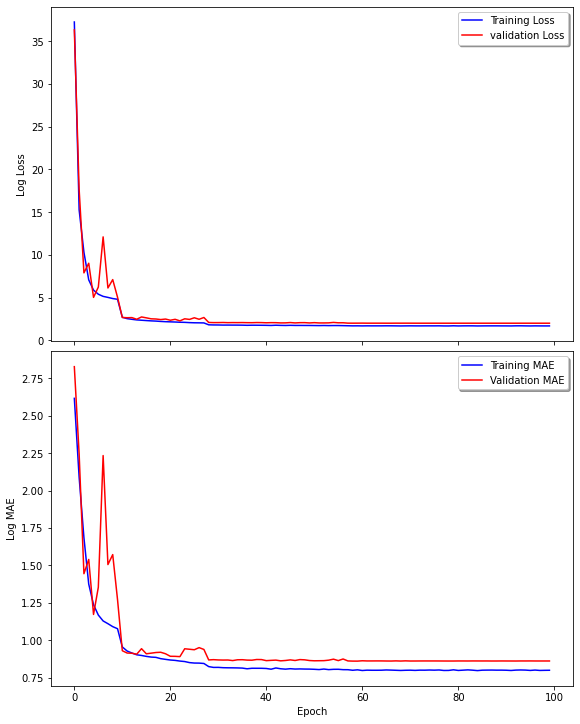

In [46]:
# Presenting the performance of the model in training
plot_hist(hist_final)

Predicted average MAE with using Train data: 0.6800375112353986
Predicted average MAE with using Dev data: 0.872461118120198


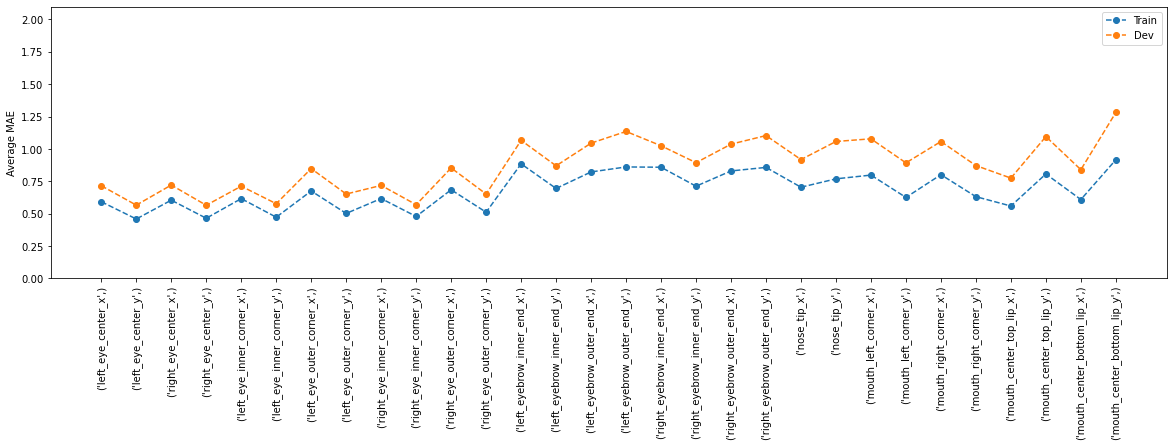

In [47]:
# Error analysis
Yfinal_pred_dev, dfinal = error_analysis(model_final, Xfa_train, Xfa_dev, Yfa_train, Yfa_dev, keypoints_list_full)

2331


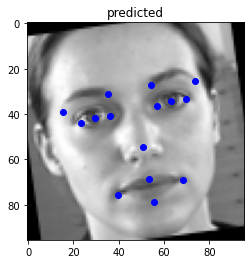

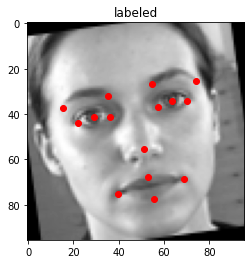

In [51]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
n = np.random.randint(len(Yfa_dev))
print(n)
plot_facial_keypoints(Xfa_dev[n],Yfinal_pred_dev[n]+Yfas_mean, 'b', 'predicted')
plot_facial_keypoints(Xfa_dev[n],Yfa_dev[n]+Yfas_mean, 'r')

### with regularization

In [110]:
# Final model with regularization

model_final_reg = create_CNN_model(n_out = 30, layers=best_layers, filters = [32,64,128,256,512], dense_unit = best_dense_unit, ks = [5,3,3,3,3], \
                           lr = 0.01, mpls = 2, drpout = best_drpout, padding = 'same', activation_last = 'relu',reg = {'l1': 0.001, 'l2':0.001})

model_final_reg.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 96, 96, 32)        800       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 48, 64)       

In [111]:
#compile final model
model_final_reg.compile(optimizer = best_optimizer , 
               loss = "mse", 
               metrics=["mae"])

In [112]:
# Fit and validate the model with augmented dataset
hist_final_reg = model_final_reg.fit(Xfa_train, Yfa_train,
            epochs= best_epoch, batch_size=best_batch_size,
            validation_split=0.1,
            callbacks = callbacks,
            verbose=1)

Epoch 1/100
768/771 [============================>.] - ETA: 0s - loss: 279.3126 - mae: 3.384 - ETA: 7s - loss: 359.4458 - mae: 7.305 - ETA: 8s - loss: 267.2882 - mae: 5.351 - ETA: 8s - loss: 223.4698 - mae: 4.520 - ETA: 9s - loss: 198.4418 - mae: 4.100 - ETA: 9s - loss: 180.3176 - mae: 3.875 - ETA: 8s - loss: 165.4642 - mae: 3.660 - ETA: 8s - loss: 154.3814 - mae: 3.517 - ETA: 8s - loss: 146.0746 - mae: 3.426 - ETA: 8s - loss: 138.5414 - mae: 3.351 - ETA: 8s - loss: 132.3885 - mae: 3.277 - ETA: 8s - loss: 127.1885 - mae: 3.218 - ETA: 8s - loss: 123.8326 - mae: 3.214 - ETA: 8s - loss: 120.5557 - mae: 3.197 - ETA: 8s - loss: 116.1707 - mae: 3.164 - ETA: 8s - loss: 111.9400 - mae: 3.127 - ETA: 8s - loss: 108.3219 - mae: 3.107 - ETA: 8s - loss: 104.7305 - mae: 3.084 - ETA: 8s - loss: 101.4746 - mae: 3.050 - ETA: 8s - loss: 98.8769 - mae: 3.038 - ETA: 7s - loss: 96.3227 - mae: 3.01 - ETA: 7s - loss: 93.6458 - mae: 2.98 - ETA: 7s - loss: 91.5327 - mae: 2.97 - ETA: 7s - loss: 89.6306 - mae: 2

767/771 [============================>.] - ETA: 0s - loss: 17.1718 - mae: 2.28 - ETA: 6s - loss: 14.1872 - mae: 1.94 - ETA: 7s - loss: 12.8865 - mae: 1.86 - ETA: 7s - loss: 12.3778 - mae: 1.83 - ETA: 8s - loss: 12.2813 - mae: 1.83 - ETA: 8s - loss: 12.6714 - mae: 1.87 - ETA: 8s - loss: 13.1539 - mae: 1.91 - ETA: 8s - loss: 12.8666 - mae: 1.89 - ETA: 8s - loss: 12.8287 - mae: 1.89 - ETA: 8s - loss: 13.0732 - mae: 1.90 - ETA: 8s - loss: 12.9980 - mae: 1.89 - ETA: 8s - loss: 12.9410 - mae: 1.89 - ETA: 8s - loss: 12.9544 - mae: 1.90 - ETA: 8s - loss: 12.7567 - mae: 1.88 - ETA: 7s - loss: 13.0831 - mae: 1.91 - ETA: 7s - loss: 13.0465 - mae: 1.91 - ETA: 7s - loss: 12.9738 - mae: 1.91 - ETA: 7s - loss: 12.9427 - mae: 1.91 - ETA: 7s - loss: 12.8850 - mae: 1.90 - ETA: 7s - loss: 12.8744 - mae: 1.89 - ETA: 7s - loss: 12.8026 - mae: 1.88 - ETA: 7s - loss: 12.7949 - mae: 1.89 - ETA: 7s - loss: 12.7828 - mae: 1.89 - ETA: 7s - loss: 13.1594 - mae: 1.91 - ETA: 7s - loss: 13.5401 - mae: 1.94 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 6.0209 - mae: 1.254 - ETA: 7s - loss: 6.2480 - mae: 1.248 - ETA: 7s - loss: 6.1376 - mae: 1.268 - ETA: 8s - loss: 6.0687 - mae: 1.247 - ETA: 8s - loss: 6.0237 - mae: 1.249 - ETA: 8s - loss: 5.9862 - mae: 1.250 - ETA: 8s - loss: 6.2659 - mae: 1.295 - ETA: 8s - loss: 6.2898 - mae: 1.298 - ETA: 8s - loss: 6.2737 - mae: 1.300 - ETA: 8s - loss: 6.2597 - mae: 1.297 - ETA: 8s - loss: 6.2844 - mae: 1.296 - ETA: 8s - loss: 6.2876 - mae: 1.293 - ETA: 8s - loss: 6.3047 - mae: 1.297 - ETA: 8s - loss: 6.3235 - mae: 1.302 - ETA: 8s - loss: 6.3874 - mae: 1.310 - ETA: 8s - loss: 6.3688 - mae: 1.309 - ETA: 8s - loss: 6.3545 - mae: 1.305 - ETA: 7s - loss: 6.3216 - mae: 1.300 - ETA: 7s - loss: 6.3063 - mae: 1.298 - ETA: 7s - loss: 6.3782 - mae: 1.302 - ETA: 7s - loss: 6.4084 - mae: 1.304 - ETA: 7s - loss: 6.4409 - mae: 1.308 - ETA: 7s - loss: 6.4176 - mae: 1.307 - ETA: 7s - loss: 6.4116 - mae: 1.308 - ETA: 7s - loss: 6.4232 - mae: 1.309 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 13.0184 - mae: 2.23 - ETA: 7s - loss: 7.3041 - mae: 1.3609 - ETA: 7s - loss: 6.1034 - mae: 1.226 - ETA: 7s - loss: 5.6551 - mae: 1.191 - ETA: 8s - loss: 5.4892 - mae: 1.173 - ETA: 8s - loss: 5.3031 - mae: 1.147 - ETA: 8s - loss: 5.2504 - mae: 1.149 - ETA: 9s - loss: 5.2572 - mae: 1.151 - ETA: 9s - loss: 5.1929 - mae: 1.141 - ETA: 9s - loss: 5.2369 - mae: 1.148 - ETA: 9s - loss: 5.2340 - mae: 1.152 - ETA: 9s - loss: 5.2285 - mae: 1.156 - ETA: 9s - loss: 5.2215 - mae: 1.148 - ETA: 9s - loss: 5.2337 - mae: 1.151 - ETA: 9s - loss: 5.2092 - mae: 1.151 - ETA: 9s - loss: 5.2564 - mae: 1.159 - ETA: 9s - loss: 5.2382 - mae: 1.155 - ETA: 9s - loss: 5.2325 - mae: 1.151 - ETA: 8s - loss: 5.2143 - mae: 1.148 - ETA: 8s - loss: 5.1852 - mae: 1.142 - ETA: 8s - loss: 5.1694 - mae: 1.140 - ETA: 8s - loss: 5.1627 - mae: 1.138 - ETA: 8s - loss: 5.1579 - mae: 1.137 - ETA: 8s - loss: 5.1702 - mae: 1.137 - ETA: 8s - loss: 5.1820 - mae: 1.137 - ETA: 8

771/771 [==============================] - ETA: 0s - loss: 6.3748 - mae: 1.400 - ETA: 7s - loss: 5.2205 - mae: 1.105 - ETA: 7s - loss: 5.1343 - mae: 1.100 - ETA: 8s - loss: 4.9672 - mae: 1.079 - ETA: 8s - loss: 4.9143 - mae: 1.081 - ETA: 8s - loss: 4.8943 - mae: 1.082 - ETA: 8s - loss: 4.8569 - mae: 1.078 - ETA: 8s - loss: 4.8930 - mae: 1.085 - ETA: 8s - loss: 4.8489 - mae: 1.081 - ETA: 8s - loss: 4.8850 - mae: 1.081 - ETA: 8s - loss: 4.8521 - mae: 1.075 - ETA: 8s - loss: 4.8508 - mae: 1.076 - ETA: 8s - loss: 4.8524 - mae: 1.077 - ETA: 8s - loss: 5.0131 - mae: 1.093 - ETA: 8s - loss: 4.9812 - mae: 1.089 - ETA: 8s - loss: 4.9704 - mae: 1.089 - ETA: 8s - loss: 4.9359 - mae: 1.086 - ETA: 8s - loss: 4.9033 - mae: 1.085 - ETA: 8s - loss: 4.9198 - mae: 1.087 - ETA: 7s - loss: 4.9233 - mae: 1.091 - ETA: 7s - loss: 4.9233 - mae: 1.090 - ETA: 7s - loss: 4.9101 - mae: 1.089 - ETA: 7s - loss: 4.8930 - mae: 1.087 - ETA: 7s - loss: 4.8990 - mae: 1.085 - ETA: 7s - loss: 4.9426 - mae: 1.091 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 7.1755 - mae: 1.064 - ETA: 7s - loss: 6.8294 - mae: 1.113 - ETA: 8s - loss: 5.7108 - mae: 1.044 - ETA: 8s - loss: 4.9688 - mae: 1.031 - ETA: 8s - loss: 4.5676 - mae: 1.028 - ETA: 8s - loss: 4.2392 - mae: 1.019 - ETA: 8s - loss: 4.0335 - mae: 1.017 - ETA: 8s - loss: 3.8784 - mae: 1.017 - ETA: 8s - loss: 3.7805 - mae: 1.017 - ETA: 8s - loss: 3.6693 - mae: 1.010 - ETA: 8s - loss: 3.5903 - mae: 1.009 - ETA: 8s - loss: 3.5324 - mae: 1.010 - ETA: 8s - loss: 3.4618 - mae: 1.006 - ETA: 8s - loss: 3.4276 - mae: 1.005 - ETA: 8s - loss: 3.3704 - mae: 0.999 - ETA: 7s - loss: 3.3182 - mae: 0.994 - ETA: 7s - loss: 3.2938 - mae: 0.993 - ETA: 7s - loss: 3.2690 - mae: 0.992 - ETA: 7s - loss: 3.2404 - mae: 0.991 - ETA: 7s - loss: 3.2141 - mae: 0.989 - ETA: 7s - loss: 3.1920 - mae: 0.989 - ETA: 7s - loss: 3.1764 - mae: 0.988 - ETA: 7s - loss: 3.1641 - mae: 0.988 - ETA: 7s - loss: 3.1624 - mae: 0.989 - ETA: 7s - loss: 3.1402 - mae: 0.988 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.1637 - mae: 0.844 - ETA: 8s - loss: 2.5237 - mae: 0.923 - ETA: 9s - loss: 2.4512 - mae: 0.902 - ETA: 10s - loss: 2.3666 - mae: 0.88 - ETA: 9s - loss: 2.3598 - mae: 0.8889 - ETA: 9s - loss: 2.4482 - mae: 0.911 - ETA: 9s - loss: 2.5022 - mae: 0.920 - ETA: 9s - loss: 2.4719 - mae: 0.916 - ETA: 9s - loss: 2.4542 - mae: 0.916 - ETA: 9s - loss: 2.4733 - mae: 0.917 - ETA: 9s - loss: 2.5744 - mae: 0.927 - ETA: 9s - loss: 2.5794 - mae: 0.928 - ETA: 9s - loss: 2.5587 - mae: 0.924 - ETA: 8s - loss: 2.5337 - mae: 0.919 - ETA: 8s - loss: 2.5160 - mae: 0.916 - ETA: 8s - loss: 2.4984 - mae: 0.913 - ETA: 8s - loss: 2.5002 - mae: 0.913 - ETA: 8s - loss: 2.4949 - mae: 0.913 - ETA: 8s - loss: 2.4889 - mae: 0.911 - ETA: 8s - loss: 2.4982 - mae: 0.913 - ETA: 8s - loss: 2.4936 - mae: 0.912 - ETA: 8s - loss: 2.5106 - mae: 0.914 - ETA: 8s - loss: 2.5136 - mae: 0.915 - ETA: 8s - loss: 2.5102 - mae: 0.917 - ETA: 7s - loss: 2.4948 - mae: 0.913 - ETA: 7

767/771 [============================>.] - ETA: 0s - loss: 2.5505 - mae: 0.929 - ETA: 7s - loss: 2.1862 - mae: 0.880 - ETA: 7s - loss: 2.2686 - mae: 0.885 - ETA: 8s - loss: 2.2894 - mae: 0.890 - ETA: 8s - loss: 2.2725 - mae: 0.886 - ETA: 8s - loss: 2.2719 - mae: 0.885 - ETA: 8s - loss: 2.2950 - mae: 0.889 - ETA: 8s - loss: 2.2905 - mae: 0.886 - ETA: 8s - loss: 2.3290 - mae: 0.890 - ETA: 8s - loss: 2.3235 - mae: 0.891 - ETA: 8s - loss: 2.3555 - mae: 0.896 - ETA: 8s - loss: 2.3625 - mae: 0.898 - ETA: 8s - loss: 2.3663 - mae: 0.899 - ETA: 7s - loss: 2.4232 - mae: 0.908 - ETA: 7s - loss: 2.4501 - mae: 0.915 - ETA: 7s - loss: 2.4331 - mae: 0.913 - ETA: 7s - loss: 2.4226 - mae: 0.911 - ETA: 7s - loss: 2.4192 - mae: 0.910 - ETA: 7s - loss: 2.4098 - mae: 0.907 - ETA: 7s - loss: 2.3995 - mae: 0.906 - ETA: 7s - loss: 2.3837 - mae: 0.901 - ETA: 7s - loss: 2.3877 - mae: 0.903 - ETA: 7s - loss: 2.3757 - mae: 0.900 - ETA: 7s - loss: 2.3660 - mae: 0.898 - ETA: 7s - loss: 2.3640 - mae: 0.898 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.2868 - mae: 0.862 - ETA: 7s - loss: 2.6283 - mae: 0.893 - ETA: 7s - loss: 2.4460 - mae: 0.894 - ETA: 8s - loss: 2.3901 - mae: 0.883 - ETA: 8s - loss: 2.3337 - mae: 0.874 - ETA: 8s - loss: 2.2995 - mae: 0.872 - ETA: 8s - loss: 2.2762 - mae: 0.868 - ETA: 8s - loss: 2.2260 - mae: 0.858 - ETA: 8s - loss: 2.2126 - mae: 0.858 - ETA: 8s - loss: 2.2179 - mae: 0.863 - ETA: 8s - loss: 2.1914 - mae: 0.858 - ETA: 8s - loss: 2.2112 - mae: 0.864 - ETA: 8s - loss: 2.2189 - mae: 0.868 - ETA: 8s - loss: 2.2279 - mae: 0.871 - ETA: 8s - loss: 2.2316 - mae: 0.872 - ETA: 8s - loss: 2.2415 - mae: 0.876 - ETA: 8s - loss: 2.2528 - mae: 0.880 - ETA: 7s - loss: 2.2584 - mae: 0.881 - ETA: 7s - loss: 2.2452 - mae: 0.878 - ETA: 7s - loss: 2.2428 - mae: 0.878 - ETA: 7s - loss: 2.2537 - mae: 0.880 - ETA: 7s - loss: 2.2561 - mae: 0.881 - ETA: 7s - loss: 2.2653 - mae: 0.882 - ETA: 7s - loss: 2.2775 - mae: 0.883 - ETA: 7s - loss: 2.2760 - mae: 0.883 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.2421 - mae: 0.920 - ETA: 7s - loss: 1.9689 - mae: 0.834 - ETA: 7s - loss: 2.0687 - mae: 0.850 - ETA: 8s - loss: 2.0468 - mae: 0.841 - ETA: 9s - loss: 2.0837 - mae: 0.849 - ETA: 9s - loss: 2.0351 - mae: 0.831 - ETA: 9s - loss: 2.0898 - mae: 0.842 - ETA: 8s - loss: 2.1672 - mae: 0.852 - ETA: 8s - loss: 2.1607 - mae: 0.853 - ETA: 8s - loss: 2.1739 - mae: 0.858 - ETA: 8s - loss: 2.2058 - mae: 0.864 - ETA: 8s - loss: 2.1843 - mae: 0.860 - ETA: 8s - loss: 2.2469 - mae: 0.866 - ETA: 8s - loss: 2.2411 - mae: 0.866 - ETA: 8s - loss: 2.2228 - mae: 0.862 - ETA: 8s - loss: 2.2226 - mae: 0.862 - ETA: 8s - loss: 2.2030 - mae: 0.859 - ETA: 8s - loss: 2.1972 - mae: 0.858 - ETA: 8s - loss: 2.2064 - mae: 0.860 - ETA: 8s - loss: 2.2124 - mae: 0.862 - ETA: 7s - loss: 2.2044 - mae: 0.862 - ETA: 7s - loss: 2.2038 - mae: 0.862 - ETA: 7s - loss: 2.1977 - mae: 0.861 - ETA: 8s - loss: 2.1927 - mae: 0.860 - ETA: 8s - loss: 2.1996 - mae: 0.862 - ETA: 8s

770/771 [============================>.] - ETA: 0s - loss: 2.0712 - mae: 0.875 - ETA: 7s - loss: 2.0538 - mae: 0.840 - ETA: 7s - loss: 2.0870 - mae: 0.854 - ETA: 8s - loss: 2.1298 - mae: 0.855 - ETA: 8s - loss: 2.1036 - mae: 0.852 - ETA: 8s - loss: 2.0929 - mae: 0.850 - ETA: 8s - loss: 2.1341 - mae: 0.856 - ETA: 8s - loss: 2.1315 - mae: 0.857 - ETA: 8s - loss: 2.0951 - mae: 0.848 - ETA: 8s - loss: 2.1127 - mae: 0.852 - ETA: 8s - loss: 2.1154 - mae: 0.854 - ETA: 8s - loss: 2.1056 - mae: 0.853 - ETA: 8s - loss: 2.1108 - mae: 0.855 - ETA: 8s - loss: 2.1237 - mae: 0.860 - ETA: 8s - loss: 2.1211 - mae: 0.859 - ETA: 8s - loss: 2.1315 - mae: 0.862 - ETA: 8s - loss: 2.1622 - mae: 0.865 - ETA: 8s - loss: 2.1716 - mae: 0.867 - ETA: 7s - loss: 2.1787 - mae: 0.870 - ETA: 7s - loss: 2.1726 - mae: 0.869 - ETA: 7s - loss: 2.1702 - mae: 0.869 - ETA: 7s - loss: 2.1601 - mae: 0.866 - ETA: 7s - loss: 2.1603 - mae: 0.867 - ETA: 7s - loss: 2.1531 - mae: 0.865 - ETA: 7s - loss: 2.1536 - mae: 0.866 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 3.3348 - mae: 1.083 - ETA: 7s - loss: 2.3540 - mae: 0.909 - ETA: 7s - loss: 2.1441 - mae: 0.876 - ETA: 8s - loss: 2.1218 - mae: 0.868 - ETA: 8s - loss: 2.0873 - mae: 0.854 - ETA: 8s - loss: 2.0944 - mae: 0.858 - ETA: 8s - loss: 2.1288 - mae: 0.866 - ETA: 8s - loss: 2.1375 - mae: 0.863 - ETA: 8s - loss: 2.0990 - mae: 0.853 - ETA: 8s - loss: 2.0759 - mae: 0.847 - ETA: 8s - loss: 2.0889 - mae: 0.850 - ETA: 8s - loss: 2.0660 - mae: 0.845 - ETA: 8s - loss: 2.0634 - mae: 0.846 - ETA: 8s - loss: 2.1026 - mae: 0.855 - ETA: 8s - loss: 2.0973 - mae: 0.853 - ETA: 7s - loss: 2.0898 - mae: 0.852 - ETA: 7s - loss: 2.0806 - mae: 0.849 - ETA: 7s - loss: 2.0812 - mae: 0.850 - ETA: 7s - loss: 2.0868 - mae: 0.852 - ETA: 7s - loss: 2.0872 - mae: 0.852 - ETA: 7s - loss: 2.0778 - mae: 0.849 - ETA: 7s - loss: 2.0832 - mae: 0.850 - ETA: 7s - loss: 2.0739 - mae: 0.847 - ETA: 7s - loss: 2.0764 - mae: 0.848 - ETA: 7s - loss: 2.0781 - mae: 0.849 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.7646 - mae: 0.804 - ETA: 7s - loss: 1.7230 - mae: 0.800 - ETA: 7s - loss: 1.7936 - mae: 0.823 - ETA: 8s - loss: 1.8676 - mae: 0.842 - ETA: 8s - loss: 1.8633 - mae: 0.841 - ETA: 8s - loss: 1.8444 - mae: 0.837 - ETA: 8s - loss: 1.8573 - mae: 0.841 - ETA: 8s - loss: 1.8603 - mae: 0.839 - ETA: 8s - loss: 1.8717 - mae: 0.841 - ETA: 8s - loss: 1.8763 - mae: 0.844 - ETA: 8s - loss: 1.8761 - mae: 0.845 - ETA: 8s - loss: 1.9127 - mae: 0.854 - ETA: 8s - loss: 1.9160 - mae: 0.852 - ETA: 8s - loss: 1.9059 - mae: 0.849 - ETA: 8s - loss: 1.9012 - mae: 0.847 - ETA: 7s - loss: 1.9047 - mae: 0.849 - ETA: 7s - loss: 1.9022 - mae: 0.847 - ETA: 8s - loss: 1.9098 - mae: 0.849 - ETA: 8s - loss: 1.9110 - mae: 0.849 - ETA: 8s - loss: 1.9128 - mae: 0.849 - ETA: 8s - loss: 1.9108 - mae: 0.848 - ETA: 8s - loss: 1.9246 - mae: 0.851 - ETA: 8s - loss: 1.9121 - mae: 0.847 - ETA: 8s - loss: 1.9118 - mae: 0.847 - ETA: 8s - loss: 1.9090 - mae: 0.847 - ETA: 8s

767/771 [============================>.] - ETA: 0s - loss: 2.1720 - mae: 0.911 - ETA: 7s - loss: 1.8623 - mae: 0.825 - ETA: 7s - loss: 1.9240 - mae: 0.854 - ETA: 7s - loss: 1.8842 - mae: 0.846 - ETA: 8s - loss: 1.9275 - mae: 0.853 - ETA: 8s - loss: 1.9300 - mae: 0.857 - ETA: 8s - loss: 1.9980 - mae: 0.860 - ETA: 8s - loss: 1.9780 - mae: 0.855 - ETA: 8s - loss: 1.9670 - mae: 0.854 - ETA: 8s - loss: 1.9976 - mae: 0.859 - ETA: 8s - loss: 1.9809 - mae: 0.854 - ETA: 8s - loss: 1.9717 - mae: 0.854 - ETA: 8s - loss: 1.9755 - mae: 0.852 - ETA: 7s - loss: 1.9600 - mae: 0.848 - ETA: 7s - loss: 1.9609 - mae: 0.847 - ETA: 7s - loss: 1.9651 - mae: 0.845 - ETA: 7s - loss: 1.9581 - mae: 0.844 - ETA: 7s - loss: 1.9525 - mae: 0.844 - ETA: 7s - loss: 1.9644 - mae: 0.848 - ETA: 7s - loss: 1.9591 - mae: 0.848 - ETA: 7s - loss: 1.9530 - mae: 0.846 - ETA: 7s - loss: 1.9415 - mae: 0.844 - ETA: 7s - loss: 1.9561 - mae: 0.846 - ETA: 7s - loss: 1.9533 - mae: 0.845 - ETA: 7s - loss: 1.9445 - mae: 0.844 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 2.0113 - mae: 0.847 - ETA: 7s - loss: 1.9686 - mae: 0.858 - ETA: 7s - loss: 1.9474 - mae: 0.853 - ETA: 8s - loss: 1.8887 - mae: 0.833 - ETA: 8s - loss: 1.8782 - mae: 0.836 - ETA: 8s - loss: 1.8811 - mae: 0.839 - ETA: 8s - loss: 1.8870 - mae: 0.840 - ETA: 8s - loss: 1.8693 - mae: 0.835 - ETA: 8s - loss: 1.8591 - mae: 0.830 - ETA: 8s - loss: 1.8719 - mae: 0.834 - ETA: 8s - loss: 1.8695 - mae: 0.833 - ETA: 8s - loss: 1.8644 - mae: 0.830 - ETA: 8s - loss: 1.8630 - mae: 0.830 - ETA: 8s - loss: 1.8819 - mae: 0.834 - ETA: 8s - loss: 1.8790 - mae: 0.834 - ETA: 8s - loss: 1.9001 - mae: 0.834 - ETA: 8s - loss: 1.8993 - mae: 0.833 - ETA: 7s - loss: 1.8994 - mae: 0.833 - ETA: 7s - loss: 1.8904 - mae: 0.832 - ETA: 7s - loss: 1.8972 - mae: 0.834 - ETA: 7s - loss: 1.8936 - mae: 0.833 - ETA: 7s - loss: 1.8932 - mae: 0.834 - ETA: 7s - loss: 1.8858 - mae: 0.832 - ETA: 7s - loss: 1.8848 - mae: 0.833 - ETA: 7s - loss: 1.8876 - mae: 0.834 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.6174 - mae: 0.765 - ETA: 7s - loss: 1.8551 - mae: 0.832 - ETA: 7s - loss: 1.7905 - mae: 0.810 - ETA: 7s - loss: 1.7565 - mae: 0.800 - ETA: 8s - loss: 1.7801 - mae: 0.810 - ETA: 8s - loss: 1.7733 - mae: 0.813 - ETA: 8s - loss: 1.7810 - mae: 0.815 - ETA: 8s - loss: 1.7833 - mae: 0.816 - ETA: 8s - loss: 1.8156 - mae: 0.823 - ETA: 8s - loss: 1.8084 - mae: 0.821 - ETA: 8s - loss: 1.8273 - mae: 0.824 - ETA: 8s - loss: 1.8292 - mae: 0.825 - ETA: 8s - loss: 1.8423 - mae: 0.828 - ETA: 8s - loss: 1.8274 - mae: 0.825 - ETA: 8s - loss: 1.8320 - mae: 0.827 - ETA: 8s - loss: 1.8342 - mae: 0.828 - ETA: 8s - loss: 1.8453 - mae: 0.831 - ETA: 8s - loss: 1.8472 - mae: 0.832 - ETA: 8s - loss: 1.8533 - mae: 0.833 - ETA: 7s - loss: 1.8411 - mae: 0.829 - ETA: 7s - loss: 1.8400 - mae: 0.829 - ETA: 7s - loss: 1.8545 - mae: 0.832 - ETA: 7s - loss: 1.8531 - mae: 0.832 - ETA: 7s - loss: 1.8544 - mae: 0.832 - ETA: 7s - loss: 1.8507 - mae: 0.831 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 1.8240 - mae: 0.834 - ETA: 8s - loss: 1.8893 - mae: 0.853 - ETA: 9s - loss: 1.8272 - mae: 0.828 - ETA: 9s - loss: 1.8225 - mae: 0.834 - ETA: 9s - loss: 1.7986 - mae: 0.833 - ETA: 9s - loss: 1.7911 - mae: 0.831 - ETA: 9s - loss: 1.7885 - mae: 0.828 - ETA: 9s - loss: 1.7860 - mae: 0.825 - ETA: 9s - loss: 1.7820 - mae: 0.822 - ETA: 9s - loss: 1.7692 - mae: 0.818 - ETA: 9s - loss: 1.7749 - mae: 0.819 - ETA: 9s - loss: 1.7856 - mae: 0.820 - ETA: 9s - loss: 1.7779 - mae: 0.819 - ETA: 9s - loss: 1.8117 - mae: 0.818 - ETA: 9s - loss: 1.8109 - mae: 0.817 - ETA: 8s - loss: 1.8061 - mae: 0.816 - ETA: 8s - loss: 1.8151 - mae: 0.818 - ETA: 8s - loss: 1.8015 - mae: 0.815 - ETA: 8s - loss: 1.8157 - mae: 0.819 - ETA: 8s - loss: 1.8125 - mae: 0.818 - ETA: 8s - loss: 1.8256 - mae: 0.822 - ETA: 8s - loss: 1.8278 - mae: 0.822 - ETA: 8s - loss: 1.8289 - mae: 0.823 - ETA: 8s - loss: 1.8251 - mae: 0.822 - ETA: 8s - loss: 1.8259 - mae: 0.823 - ETA: 8s

770/771 [============================>.] - ETA: 0s - loss: 2.0963 - mae: 0.907 - ETA: 7s - loss: 1.8681 - mae: 0.838 - ETA: 8s - loss: 1.8197 - mae: 0.813 - ETA: 8s - loss: 1.9217 - mae: 0.841 - ETA: 8s - loss: 1.8889 - mae: 0.837 - ETA: 8s - loss: 1.8182 - mae: 0.817 - ETA: 8s - loss: 1.8238 - mae: 0.822 - ETA: 8s - loss: 1.7927 - mae: 0.815 - ETA: 8s - loss: 1.8153 - mae: 0.822 - ETA: 8s - loss: 1.8140 - mae: 0.822 - ETA: 8s - loss: 1.7995 - mae: 0.819 - ETA: 8s - loss: 1.8157 - mae: 0.823 - ETA: 8s - loss: 1.7940 - mae: 0.817 - ETA: 8s - loss: 1.7858 - mae: 0.815 - ETA: 8s - loss: 1.8151 - mae: 0.819 - ETA: 7s - loss: 1.8294 - mae: 0.823 - ETA: 7s - loss: 1.8325 - mae: 0.825 - ETA: 7s - loss: 1.8275 - mae: 0.823 - ETA: 7s - loss: 1.8304 - mae: 0.824 - ETA: 7s - loss: 1.8361 - mae: 0.825 - ETA: 7s - loss: 1.8379 - mae: 0.826 - ETA: 7s - loss: 1.8443 - mae: 0.828 - ETA: 7s - loss: 1.8422 - mae: 0.828 - ETA: 7s - loss: 1.8353 - mae: 0.826 - ETA: 7s - loss: 1.8340 - mae: 0.826 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.7723 - mae: 0.829 - ETA: 7s - loss: 1.7876 - mae: 0.813 - ETA: 8s - loss: 1.8278 - mae: 0.823 - ETA: 8s - loss: 1.8359 - mae: 0.823 - ETA: 9s - loss: 1.8497 - mae: 0.829 - ETA: 9s - loss: 1.8192 - mae: 0.822 - ETA: 9s - loss: 1.8245 - mae: 0.822 - ETA: 9s - loss: 1.8355 - mae: 0.824 - ETA: 8s - loss: 1.8214 - mae: 0.821 - ETA: 8s - loss: 1.8079 - mae: 0.818 - ETA: 8s - loss: 1.8057 - mae: 0.818 - ETA: 8s - loss: 1.7868 - mae: 0.814 - ETA: 8s - loss: 1.8158 - mae: 0.817 - ETA: 8s - loss: 1.8134 - mae: 0.817 - ETA: 8s - loss: 1.8157 - mae: 0.819 - ETA: 8s - loss: 1.8230 - mae: 0.821 - ETA: 8s - loss: 1.8203 - mae: 0.820 - ETA: 8s - loss: 1.8235 - mae: 0.821 - ETA: 8s - loss: 1.8409 - mae: 0.826 - ETA: 8s - loss: 1.8402 - mae: 0.826 - ETA: 8s - loss: 1.8461 - mae: 0.828 - ETA: 8s - loss: 1.8518 - mae: 0.830 - ETA: 8s - loss: 1.8458 - mae: 0.829 - ETA: 8s - loss: 1.8415 - mae: 0.828 - ETA: 7s - loss: 1.8362 - mae: 0.827 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.6610 - mae: 0.788 - ETA: 7s - loss: 1.7036 - mae: 0.797 - ETA: 7s - loss: 1.7415 - mae: 0.803 - ETA: 8s - loss: 1.8424 - mae: 0.818 - ETA: 8s - loss: 1.8095 - mae: 0.811 - ETA: 8s - loss: 1.7759 - mae: 0.803 - ETA: 8s - loss: 1.7561 - mae: 0.801 - ETA: 8s - loss: 1.7791 - mae: 0.806 - ETA: 8s - loss: 1.7779 - mae: 0.806 - ETA: 8s - loss: 1.7995 - mae: 0.808 - ETA: 8s - loss: 1.8152 - mae: 0.812 - ETA: 8s - loss: 1.8067 - mae: 0.810 - ETA: 8s - loss: 1.7989 - mae: 0.809 - ETA: 8s - loss: 1.7947 - mae: 0.809 - ETA: 7s - loss: 1.7886 - mae: 0.808 - ETA: 7s - loss: 1.7867 - mae: 0.808 - ETA: 7s - loss: 1.7819 - mae: 0.808 - ETA: 7s - loss: 1.7764 - mae: 0.807 - ETA: 7s - loss: 1.7768 - mae: 0.808 - ETA: 7s - loss: 1.7798 - mae: 0.810 - ETA: 7s - loss: 1.7772 - mae: 0.809 - ETA: 7s - loss: 1.7775 - mae: 0.810 - ETA: 7s - loss: 1.7753 - mae: 0.810 - ETA: 7s - loss: 1.7815 - mae: 0.811 - ETA: 7s - loss: 1.7717 - mae: 0.808 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 1.5680 - mae: 0.768 - ETA: 7s - loss: 1.7978 - mae: 0.826 - ETA: 7s - loss: 1.7732 - mae: 0.823 - ETA: 8s - loss: 1.7425 - mae: 0.815 - ETA: 8s - loss: 1.7708 - mae: 0.820 - ETA: 8s - loss: 1.7511 - mae: 0.815 - ETA: 8s - loss: 1.7315 - mae: 0.809 - ETA: 8s - loss: 1.7421 - mae: 0.813 - ETA: 8s - loss: 1.7543 - mae: 0.817 - ETA: 8s - loss: 1.7556 - mae: 0.817 - ETA: 8s - loss: 1.7657 - mae: 0.818 - ETA: 8s - loss: 1.7641 - mae: 0.818 - ETA: 8s - loss: 1.7597 - mae: 0.816 - ETA: 8s - loss: 1.7639 - mae: 0.817 - ETA: 8s - loss: 1.7762 - mae: 0.819 - ETA: 8s - loss: 1.7821 - mae: 0.821 - ETA: 7s - loss: 1.7806 - mae: 0.819 - ETA: 7s - loss: 1.7847 - mae: 0.819 - ETA: 7s - loss: 1.7992 - mae: 0.822 - ETA: 7s - loss: 1.7973 - mae: 0.821 - ETA: 7s - loss: 1.7977 - mae: 0.820 - ETA: 7s - loss: 1.7937 - mae: 0.820 - ETA: 7s - loss: 1.7881 - mae: 0.818 - ETA: 7s - loss: 1.7910 - mae: 0.819 - ETA: 7s - loss: 1.7882 - mae: 0.817 - ETA: 7s

767/771 [============================>.] - ETA: 0s - loss: 1.7148 - mae: 0.791 - ETA: 7s - loss: 1.7043 - mae: 0.793 - ETA: 7s - loss: 1.7597 - mae: 0.803 - ETA: 7s - loss: 1.7369 - mae: 0.795 - ETA: 8s - loss: 1.7430 - mae: 0.799 - ETA: 8s - loss: 1.7282 - mae: 0.797 - ETA: 8s - loss: 1.7467 - mae: 0.802 - ETA: 8s - loss: 1.7837 - mae: 0.811 - ETA: 8s - loss: 1.7951 - mae: 0.814 - ETA: 8s - loss: 1.7763 - mae: 0.810 - ETA: 8s - loss: 1.7790 - mae: 0.813 - ETA: 8s - loss: 1.8097 - mae: 0.815 - ETA: 8s - loss: 1.8137 - mae: 0.817 - ETA: 8s - loss: 1.8190 - mae: 0.819 - ETA: 8s - loss: 1.8182 - mae: 0.819 - ETA: 7s - loss: 1.8230 - mae: 0.821 - ETA: 7s - loss: 1.8187 - mae: 0.821 - ETA: 7s - loss: 1.8275 - mae: 0.823 - ETA: 7s - loss: 1.8147 - mae: 0.822 - ETA: 7s - loss: 1.8154 - mae: 0.823 - ETA: 7s - loss: 1.8120 - mae: 0.822 - ETA: 7s - loss: 1.8121 - mae: 0.822 - ETA: 7s - loss: 1.8302 - mae: 0.827 - ETA: 7s - loss: 1.8256 - mae: 0.826 - ETA: 7s - loss: 1.8221 - mae: 0.825 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.5393 - mae: 0.769 - ETA: 7s - loss: 1.6007 - mae: 0.774 - ETA: 7s - loss: 1.5583 - mae: 0.760 - ETA: 8s - loss: 1.6583 - mae: 0.777 - ETA: 8s - loss: 1.6984 - mae: 0.794 - ETA: 8s - loss: 1.7128 - mae: 0.802 - ETA: 8s - loss: 1.7113 - mae: 0.802 - ETA: 8s - loss: 1.7184 - mae: 0.803 - ETA: 8s - loss: 1.7261 - mae: 0.803 - ETA: 8s - loss: 1.7399 - mae: 0.807 - ETA: 8s - loss: 1.7654 - mae: 0.815 - ETA: 8s - loss: 1.7609 - mae: 0.814 - ETA: 8s - loss: 1.7692 - mae: 0.814 - ETA: 8s - loss: 1.7777 - mae: 0.816 - ETA: 8s - loss: 1.7846 - mae: 0.819 - ETA: 8s - loss: 1.7925 - mae: 0.821 - ETA: 8s - loss: 1.8076 - mae: 0.824 - ETA: 8s - loss: 1.8171 - mae: 0.827 - ETA: 7s - loss: 1.8104 - mae: 0.825 - ETA: 7s - loss: 1.8121 - mae: 0.826 - ETA: 7s - loss: 1.8026 - mae: 0.823 - ETA: 7s - loss: 1.8002 - mae: 0.822 - ETA: 7s - loss: 1.7997 - mae: 0.822 - ETA: 7s - loss: 1.8005 - mae: 0.822 - ETA: 7s - loss: 1.7989 - mae: 0.822 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.6158 - mae: 0.763 - ETA: 7s - loss: 1.7124 - mae: 0.785 - ETA: 7s - loss: 1.7558 - mae: 0.805 - ETA: 8s - loss: 1.8137 - mae: 0.825 - ETA: 8s - loss: 1.8206 - mae: 0.832 - ETA: 8s - loss: 1.8108 - mae: 0.826 - ETA: 8s - loss: 1.7848 - mae: 0.817 - ETA: 8s - loss: 1.7701 - mae: 0.811 - ETA: 8s - loss: 1.7511 - mae: 0.807 - ETA: 8s - loss: 1.7576 - mae: 0.808 - ETA: 8s - loss: 1.7650 - mae: 0.808 - ETA: 8s - loss: 1.7686 - mae: 0.809 - ETA: 8s - loss: 1.7596 - mae: 0.807 - ETA: 8s - loss: 1.7616 - mae: 0.808 - ETA: 8s - loss: 1.7704 - mae: 0.811 - ETA: 8s - loss: 1.7744 - mae: 0.812 - ETA: 8s - loss: 1.7852 - mae: 0.814 - ETA: 7s - loss: 1.7936 - mae: 0.817 - ETA: 7s - loss: 1.8057 - mae: 0.821 - ETA: 7s - loss: 1.8110 - mae: 0.823 - ETA: 7s - loss: 1.8132 - mae: 0.823 - ETA: 7s - loss: 1.8055 - mae: 0.821 - ETA: 7s - loss: 1.8056 - mae: 0.821 - ETA: 7s - loss: 1.7992 - mae: 0.820 - ETA: 7s - loss: 1.7952 - mae: 0.819 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 2.1640 - mae: 0.873 - ETA: 7s - loss: 1.8124 - mae: 0.819 - ETA: 8s - loss: 1.7757 - mae: 0.814 - ETA: 8s - loss: 1.7597 - mae: 0.808 - ETA: 8s - loss: 1.7454 - mae: 0.804 - ETA: 8s - loss: 1.7981 - mae: 0.813 - ETA: 8s - loss: 1.8240 - mae: 0.813 - ETA: 8s - loss: 1.8119 - mae: 0.813 - ETA: 8s - loss: 1.8154 - mae: 0.818 - ETA: 8s - loss: 1.8083 - mae: 0.816 - ETA: 8s - loss: 1.7873 - mae: 0.811 - ETA: 8s - loss: 1.8020 - mae: 0.817 - ETA: 8s - loss: 1.7951 - mae: 0.815 - ETA: 8s - loss: 1.7846 - mae: 0.813 - ETA: 8s - loss: 1.7793 - mae: 0.812 - ETA: 8s - loss: 1.7695 - mae: 0.810 - ETA: 8s - loss: 1.7687 - mae: 0.810 - ETA: 8s - loss: 1.7692 - mae: 0.811 - ETA: 8s - loss: 1.7745 - mae: 0.813 - ETA: 8s - loss: 1.7861 - mae: 0.815 - ETA: 8s - loss: 1.7894 - mae: 0.816 - ETA: 8s - loss: 1.7804 - mae: 0.814 - ETA: 8s - loss: 1.7841 - mae: 0.814 - ETA: 8s - loss: 1.7757 - mae: 0.812 - ETA: 8s - loss: 1.7758 - mae: 0.812 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.7446 - mae: 0.811 - ETA: 7s - loss: 1.8174 - mae: 0.854 - ETA: 8s - loss: 1.8108 - mae: 0.845 - ETA: 8s - loss: 1.7812 - mae: 0.831 - ETA: 9s - loss: 1.7552 - mae: 0.821 - ETA: 9s - loss: 1.7568 - mae: 0.821 - ETA: 10s - loss: 1.7826 - mae: 0.82 - ETA: 9s - loss: 1.7782 - mae: 0.8287 - ETA: 9s - loss: 1.7673 - mae: 0.824 - ETA: 9s - loss: 1.7547 - mae: 0.820 - ETA: 9s - loss: 1.7579 - mae: 0.820 - ETA: 9s - loss: 1.7570 - mae: 0.821 - ETA: 9s - loss: 1.7553 - mae: 0.819 - ETA: 8s - loss: 1.7573 - mae: 0.820 - ETA: 8s - loss: 1.7691 - mae: 0.823 - ETA: 8s - loss: 1.7654 - mae: 0.822 - ETA: 8s - loss: 1.7731 - mae: 0.823 - ETA: 8s - loss: 1.7666 - mae: 0.821 - ETA: 8s - loss: 1.7691 - mae: 0.821 - ETA: 8s - loss: 1.7838 - mae: 0.825 - ETA: 8s - loss: 1.7744 - mae: 0.821 - ETA: 8s - loss: 1.7705 - mae: 0.821 - ETA: 8s - loss: 1.7667 - mae: 0.821 - ETA: 8s - loss: 1.7660 - mae: 0.821 - ETA: 8s - loss: 1.7600 - mae: 0.819 - ETA: 8

767/771 [============================>.] - ETA: 0s - loss: 1.6380 - mae: 0.802 - ETA: 7s - loss: 1.7721 - mae: 0.810 - ETA: 8s - loss: 1.7535 - mae: 0.807 - ETA: 8s - loss: 1.7759 - mae: 0.820 - ETA: 8s - loss: 1.7402 - mae: 0.805 - ETA: 8s - loss: 1.7301 - mae: 0.804 - ETA: 8s - loss: 1.7279 - mae: 0.806 - ETA: 8s - loss: 1.7660 - mae: 0.812 - ETA: 8s - loss: 1.7564 - mae: 0.811 - ETA: 8s - loss: 1.7429 - mae: 0.808 - ETA: 8s - loss: 1.7775 - mae: 0.810 - ETA: 8s - loss: 1.7755 - mae: 0.808 - ETA: 8s - loss: 1.7773 - mae: 0.810 - ETA: 8s - loss: 1.7742 - mae: 0.810 - ETA: 8s - loss: 1.7726 - mae: 0.812 - ETA: 8s - loss: 1.7697 - mae: 0.811 - ETA: 8s - loss: 1.7762 - mae: 0.813 - ETA: 8s - loss: 1.7801 - mae: 0.815 - ETA: 8s - loss: 1.7693 - mae: 0.812 - ETA: 8s - loss: 1.7604 - mae: 0.809 - ETA: 8s - loss: 1.7555 - mae: 0.808 - ETA: 7s - loss: 1.7591 - mae: 0.808 - ETA: 7s - loss: 1.7499 - mae: 0.806 - ETA: 7s - loss: 1.7541 - mae: 0.807 - ETA: 7s - loss: 1.7695 - mae: 0.810 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.6595 - mae: 0.785 - ETA: 7s - loss: 1.7678 - mae: 0.832 - ETA: 7s - loss: 1.7838 - mae: 0.833 - ETA: 8s - loss: 1.7525 - mae: 0.821 - ETA: 8s - loss: 1.8640 - mae: 0.836 - ETA: 8s - loss: 1.8639 - mae: 0.837 - ETA: 8s - loss: 1.8751 - mae: 0.841 - ETA: 8s - loss: 1.8511 - mae: 0.836 - ETA: 8s - loss: 1.8376 - mae: 0.833 - ETA: 8s - loss: 1.8198 - mae: 0.831 - ETA: 8s - loss: 1.7989 - mae: 0.825 - ETA: 8s - loss: 1.8213 - mae: 0.828 - ETA: 8s - loss: 1.8190 - mae: 0.825 - ETA: 8s - loss: 1.8227 - mae: 0.826 - ETA: 8s - loss: 1.8122 - mae: 0.824 - ETA: 8s - loss: 1.8088 - mae: 0.823 - ETA: 8s - loss: 1.7980 - mae: 0.821 - ETA: 8s - loss: 1.7957 - mae: 0.821 - ETA: 8s - loss: 1.7914 - mae: 0.820 - ETA: 8s - loss: 1.8009 - mae: 0.823 - ETA: 8s - loss: 1.7942 - mae: 0.822 - ETA: 7s - loss: 1.7883 - mae: 0.820 - ETA: 7s - loss: 1.7916 - mae: 0.821 - ETA: 7s - loss: 1.7960 - mae: 0.821 - ETA: 7s - loss: 1.7889 - mae: 0.820 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.6539 - mae: 0.796 - ETA: 7s - loss: 1.7266 - mae: 0.818 - ETA: 7s - loss: 1.7916 - mae: 0.817 - ETA: 8s - loss: 1.7789 - mae: 0.813 - ETA: 8s - loss: 1.8005 - mae: 0.818 - ETA: 8s - loss: 1.7954 - mae: 0.819 - ETA: 8s - loss: 1.7826 - mae: 0.818 - ETA: 8s - loss: 1.8094 - mae: 0.823 - ETA: 8s - loss: 1.8124 - mae: 0.826 - ETA: 8s - loss: 1.7913 - mae: 0.820 - ETA: 8s - loss: 1.7987 - mae: 0.825 - ETA: 8s - loss: 1.7799 - mae: 0.820 - ETA: 8s - loss: 1.7819 - mae: 0.822 - ETA: 8s - loss: 1.7708 - mae: 0.819 - ETA: 8s - loss: 1.7718 - mae: 0.820 - ETA: 8s - loss: 1.7793 - mae: 0.819 - ETA: 7s - loss: 1.7831 - mae: 0.821 - ETA: 7s - loss: 1.7720 - mae: 0.818 - ETA: 7s - loss: 1.7834 - mae: 0.821 - ETA: 7s - loss: 1.7869 - mae: 0.822 - ETA: 7s - loss: 1.7874 - mae: 0.823 - ETA: 7s - loss: 1.7905 - mae: 0.823 - ETA: 7s - loss: 1.7909 - mae: 0.823 - ETA: 7s - loss: 1.7892 - mae: 0.823 - ETA: 7s - loss: 1.7954 - mae: 0.823 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.7992 - mae: 0.879 - ETA: 7s - loss: 1.9543 - mae: 0.876 - ETA: 8s - loss: 1.9125 - mae: 0.860 - ETA: 8s - loss: 2.0731 - mae: 0.873 - ETA: 8s - loss: 2.0463 - mae: 0.876 - ETA: 8s - loss: 1.9864 - mae: 0.865 - ETA: 8s - loss: 1.9386 - mae: 0.856 - ETA: 8s - loss: 1.9011 - mae: 0.848 - ETA: 8s - loss: 1.8822 - mae: 0.844 - ETA: 8s - loss: 1.8508 - mae: 0.837 - ETA: 8s - loss: 1.8387 - mae: 0.834 - ETA: 8s - loss: 1.8592 - mae: 0.837 - ETA: 8s - loss: 1.8533 - mae: 0.834 - ETA: 8s - loss: 1.8604 - mae: 0.837 - ETA: 8s - loss: 1.8636 - mae: 0.839 - ETA: 8s - loss: 1.8530 - mae: 0.837 - ETA: 8s - loss: 1.8438 - mae: 0.835 - ETA: 8s - loss: 1.8483 - mae: 0.836 - ETA: 7s - loss: 1.8366 - mae: 0.834 - ETA: 7s - loss: 1.8250 - mae: 0.831 - ETA: 7s - loss: 1.8218 - mae: 0.830 - ETA: 7s - loss: 1.8215 - mae: 0.831 - ETA: 7s - loss: 1.8222 - mae: 0.831 - ETA: 7s - loss: 1.8236 - mae: 0.831 - ETA: 7s - loss: 1.8205 - mae: 0.830 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 2.1254 - mae: 0.905 - ETA: 25s - loss: 1.7889 - mae: 0.82 - ETA: 25s - loss: 1.7908 - mae: 0.81 - ETA: 23s - loss: 1.7450 - mae: 0.80 - ETA: 20s - loss: 1.7091 - mae: 0.80 - ETA: 20s - loss: 1.6996 - mae: 0.80 - ETA: 20s - loss: 1.6752 - mae: 0.79 - ETA: 19s - loss: 1.7216 - mae: 0.80 - ETA: 18s - loss: 1.7056 - mae: 0.80 - ETA: 17s - loss: 1.7165 - mae: 0.80 - ETA: 17s - loss: 1.7716 - mae: 0.82 - ETA: 16s - loss: 1.7695 - mae: 0.82 - ETA: 16s - loss: 1.7378 - mae: 0.81 - ETA: 16s - loss: 1.7368 - mae: 0.81 - ETA: 15s - loss: 1.7541 - mae: 0.81 - ETA: 15s - loss: 1.7693 - mae: 0.81 - ETA: 14s - loss: 1.7667 - mae: 0.81 - ETA: 14s - loss: 1.7553 - mae: 0.81 - ETA: 13s - loss: 1.7598 - mae: 0.81 - ETA: 13s - loss: 1.7605 - mae: 0.81 - ETA: 13s - loss: 1.7645 - mae: 0.81 - ETA: 12s - loss: 1.7624 - mae: 0.81 - ETA: 12s - loss: 1.7576 - mae: 0.81 - ETA: 12s - loss: 1.7485 - mae: 0.81 - ETA: 12s - loss: 1.7420 - mae: 0.80 - ETA: 11

770/771 [============================>.] - ETA: 0s - loss: 1.7852 - mae: 0.856 - ETA: 7s - loss: 1.7180 - mae: 0.813 - ETA: 8s - loss: 1.7524 - mae: 0.819 - ETA: 8s - loss: 1.7188 - mae: 0.806 - ETA: 8s - loss: 1.6760 - mae: 0.795 - ETA: 8s - loss: 1.6773 - mae: 0.794 - ETA: 8s - loss: 1.6901 - mae: 0.796 - ETA: 8s - loss: 1.6993 - mae: 0.800 - ETA: 8s - loss: 1.7160 - mae: 0.805 - ETA: 8s - loss: 1.7444 - mae: 0.810 - ETA: 8s - loss: 1.7400 - mae: 0.809 - ETA: 8s - loss: 1.7369 - mae: 0.808 - ETA: 8s - loss: 1.7433 - mae: 0.810 - ETA: 8s - loss: 1.7340 - mae: 0.808 - ETA: 8s - loss: 1.7306 - mae: 0.807 - ETA: 8s - loss: 1.7221 - mae: 0.805 - ETA: 7s - loss: 1.7382 - mae: 0.808 - ETA: 7s - loss: 1.7392 - mae: 0.808 - ETA: 7s - loss: 1.7354 - mae: 0.807 - ETA: 7s - loss: 1.7281 - mae: 0.806 - ETA: 7s - loss: 1.7273 - mae: 0.805 - ETA: 7s - loss: 1.7315 - mae: 0.807 - ETA: 7s - loss: 1.7237 - mae: 0.805 - ETA: 7s - loss: 1.7307 - mae: 0.807 - ETA: 7s - loss: 1.7347 - mae: 0.808 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 1.7525 - mae: 0.743 - ETA: 7s - loss: 1.8127 - mae: 0.789 - ETA: 8s - loss: 1.7546 - mae: 0.791 - ETA: 8s - loss: 1.7335 - mae: 0.788 - ETA: 8s - loss: 1.7374 - mae: 0.794 - ETA: 8s - loss: 1.7125 - mae: 0.791 - ETA: 8s - loss: 1.7469 - mae: 0.804 - ETA: 8s - loss: 1.7487 - mae: 0.805 - ETA: 8s - loss: 1.7358 - mae: 0.804 - ETA: 8s - loss: 1.7370 - mae: 0.805 - ETA: 8s - loss: 1.7313 - mae: 0.804 - ETA: 8s - loss: 1.7110 - mae: 0.798 - ETA: 8s - loss: 1.7115 - mae: 0.798 - ETA: 8s - loss: 1.7104 - mae: 0.799 - ETA: 8s - loss: 1.7142 - mae: 0.799 - ETA: 8s - loss: 1.7235 - mae: 0.802 - ETA: 8s - loss: 1.7219 - mae: 0.802 - ETA: 7s - loss: 1.7139 - mae: 0.800 - ETA: 7s - loss: 1.7101 - mae: 0.800 - ETA: 7s - loss: 1.7112 - mae: 0.801 - ETA: 7s - loss: 1.7052 - mae: 0.800 - ETA: 7s - loss: 1.7058 - mae: 0.800 - ETA: 7s - loss: 1.7029 - mae: 0.800 - ETA: 7s - loss: 1.7050 - mae: 0.801 - ETA: 7s - loss: 1.7126 - mae: 0.803 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 2.0350 - mae: 0.857 - ETA: 7s - loss: 1.8995 - mae: 0.860 - ETA: 8s - loss: 1.8627 - mae: 0.850 - ETA: 8s - loss: 1.8621 - mae: 0.849 - ETA: 8s - loss: 1.8244 - mae: 0.839 - ETA: 8s - loss: 1.8229 - mae: 0.838 - ETA: 8s - loss: 1.8377 - mae: 0.837 - ETA: 8s - loss: 1.8469 - mae: 0.839 - ETA: 8s - loss: 1.8258 - mae: 0.835 - ETA: 8s - loss: 1.8165 - mae: 0.830 - ETA: 8s - loss: 1.8099 - mae: 0.829 - ETA: 8s - loss: 1.7882 - mae: 0.822 - ETA: 8s - loss: 1.7820 - mae: 0.820 - ETA: 8s - loss: 1.7956 - mae: 0.824 - ETA: 9s - loss: 1.8172 - mae: 0.826 - ETA: 10s - loss: 1.8162 - mae: 0.82 - ETA: 10s - loss: 1.8070 - mae: 0.82 - ETA: 10s - loss: 1.8040 - mae: 0.82 - ETA: 10s - loss: 1.8046 - mae: 0.82 - ETA: 10s - loss: 1.8029 - mae: 0.82 - ETA: 10s - loss: 1.8001 - mae: 0.82 - ETA: 10s - loss: 1.8042 - mae: 0.82 - ETA: 10s - loss: 1.7984 - mae: 0.82 - ETA: 10s - loss: 1.7931 - mae: 0.82 - ETA: 10s - loss: 1.7901 - mae: 0.81 - ETA: 10

771/771 [==============================] - ETA: 0s - loss: 1.6481 - mae: 0.817 - ETA: 7s - loss: 1.7158 - mae: 0.813 - ETA: 8s - loss: 1.6784 - mae: 0.793 - ETA: 8s - loss: 1.7019 - mae: 0.802 - ETA: 8s - loss: 1.6834 - mae: 0.796 - ETA: 8s - loss: 1.7433 - mae: 0.813 - ETA: 8s - loss: 1.7752 - mae: 0.820 - ETA: 8s - loss: 1.7379 - mae: 0.810 - ETA: 8s - loss: 1.7463 - mae: 0.814 - ETA: 8s - loss: 1.7704 - mae: 0.815 - ETA: 8s - loss: 1.7732 - mae: 0.818 - ETA: 8s - loss: 1.7705 - mae: 0.817 - ETA: 8s - loss: 1.7700 - mae: 0.816 - ETA: 8s - loss: 1.7863 - mae: 0.819 - ETA: 8s - loss: 1.7720 - mae: 0.815 - ETA: 8s - loss: 1.7806 - mae: 0.814 - ETA: 7s - loss: 1.7671 - mae: 0.810 - ETA: 7s - loss: 1.7586 - mae: 0.808 - ETA: 7s - loss: 1.7504 - mae: 0.807 - ETA: 7s - loss: 1.7504 - mae: 0.808 - ETA: 7s - loss: 1.7510 - mae: 0.808 - ETA: 7s - loss: 1.7521 - mae: 0.809 - ETA: 7s - loss: 1.7493 - mae: 0.808 - ETA: 7s - loss: 1.7667 - mae: 0.811 - ETA: 7s - loss: 1.7648 - mae: 0.812 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.5376 - mae: 0.759 - ETA: 9s - loss: 1.6309 - mae: 0.790 - ETA: 10s - loss: 1.7543 - mae: 0.81 - ETA: 10s - loss: 1.7313 - mae: 0.80 - ETA: 10s - loss: 1.6944 - mae: 0.79 - ETA: 10s - loss: 1.6510 - mae: 0.78 - ETA: 10s - loss: 1.6668 - mae: 0.78 - ETA: 10s - loss: 1.6771 - mae: 0.79 - ETA: 9s - loss: 1.7075 - mae: 0.8053 - ETA: 9s - loss: 1.7077 - mae: 0.805 - ETA: 9s - loss: 1.7105 - mae: 0.805 - ETA: 9s - loss: 1.7231 - mae: 0.807 - ETA: 9s - loss: 1.7271 - mae: 0.808 - ETA: 9s - loss: 1.7426 - mae: 0.812 - ETA: 9s - loss: 1.7336 - mae: 0.810 - ETA: 9s - loss: 1.7336 - mae: 0.809 - ETA: 9s - loss: 1.7393 - mae: 0.810 - ETA: 9s - loss: 1.7461 - mae: 0.812 - ETA: 8s - loss: 1.7489 - mae: 0.812 - ETA: 8s - loss: 1.7599 - mae: 0.815 - ETA: 8s - loss: 1.7522 - mae: 0.813 - ETA: 8s - loss: 1.7465 - mae: 0.811 - ETA: 8s - loss: 1.7379 - mae: 0.809 - ETA: 8s - loss: 1.7406 - mae: 0.809 - ETA: 8s - loss: 1.7373 - mae: 0.809 - ETA: 8

770/771 [============================>.] - ETA: 0s - loss: 1.5608 - mae: 0.757 - ETA: 7s - loss: 1.9008 - mae: 0.836 - ETA: 7s - loss: 1.7790 - mae: 0.812 - ETA: 8s - loss: 1.7916 - mae: 0.815 - ETA: 8s - loss: 1.7580 - mae: 0.809 - ETA: 8s - loss: 1.7543 - mae: 0.807 - ETA: 8s - loss: 1.7474 - mae: 0.804 - ETA: 8s - loss: 1.7667 - mae: 0.812 - ETA: 8s - loss: 1.7957 - mae: 0.819 - ETA: 8s - loss: 1.7873 - mae: 0.818 - ETA: 8s - loss: 1.7714 - mae: 0.816 - ETA: 8s - loss: 1.7731 - mae: 0.817 - ETA: 8s - loss: 1.7712 - mae: 0.816 - ETA: 8s - loss: 1.7796 - mae: 0.818 - ETA: 8s - loss: 1.7666 - mae: 0.816 - ETA: 8s - loss: 1.7629 - mae: 0.816 - ETA: 8s - loss: 1.7610 - mae: 0.817 - ETA: 8s - loss: 1.7695 - mae: 0.819 - ETA: 8s - loss: 1.7628 - mae: 0.818 - ETA: 8s - loss: 1.7646 - mae: 0.818 - ETA: 7s - loss: 1.7743 - mae: 0.821 - ETA: 7s - loss: 1.7873 - mae: 0.823 - ETA: 7s - loss: 1.7910 - mae: 0.824 - ETA: 7s - loss: 1.8007 - mae: 0.826 - ETA: 7s - loss: 1.7899 - mae: 0.822 - ETA: 8s

771/771 [==============================] - ETA: 0s - loss: 1.7136 - mae: 0.808 - ETA: 7s - loss: 1.8037 - mae: 0.822 - ETA: 8s - loss: 1.7306 - mae: 0.807 - ETA: 8s - loss: 1.7030 - mae: 0.804 - ETA: 8s - loss: 1.6668 - mae: 0.792 - ETA: 8s - loss: 1.6824 - mae: 0.789 - ETA: 8s - loss: 1.6983 - mae: 0.793 - ETA: 8s - loss: 1.7017 - mae: 0.796 - ETA: 8s - loss: 1.7177 - mae: 0.801 - ETA: 8s - loss: 1.7300 - mae: 0.807 - ETA: 8s - loss: 1.7399 - mae: 0.810 - ETA: 8s - loss: 1.7256 - mae: 0.806 - ETA: 8s - loss: 1.7423 - mae: 0.807 - ETA: 8s - loss: 1.7471 - mae: 0.809 - ETA: 8s - loss: 1.7782 - mae: 0.813 - ETA: 8s - loss: 1.7926 - mae: 0.818 - ETA: 8s - loss: 1.7939 - mae: 0.819 - ETA: 7s - loss: 1.7889 - mae: 0.818 - ETA: 7s - loss: 1.7902 - mae: 0.819 - ETA: 7s - loss: 1.7848 - mae: 0.818 - ETA: 7s - loss: 1.7897 - mae: 0.820 - ETA: 7s - loss: 1.7773 - mae: 0.817 - ETA: 7s - loss: 1.7807 - mae: 0.818 - ETA: 7s - loss: 1.7693 - mae: 0.815 - ETA: 7s - loss: 1.7692 - mae: 0.816 - ETA: 7s

769/771 [============================>.] - ETA: 0s - loss: 1.6257 - mae: 0.786 - ETA: 7s - loss: 2.1931 - mae: 0.846 - ETA: 7s - loss: 1.9416 - mae: 0.821 - ETA: 8s - loss: 1.8686 - mae: 0.815 - ETA: 9s - loss: 1.8614 - mae: 0.819 - ETA: 9s - loss: 1.8358 - mae: 0.816 - ETA: 8s - loss: 1.8370 - mae: 0.817 - ETA: 8s - loss: 1.8320 - mae: 0.819 - ETA: 8s - loss: 1.8002 - mae: 0.811 - ETA: 8s - loss: 1.7910 - mae: 0.812 - ETA: 8s - loss: 1.8098 - mae: 0.819 - ETA: 8s - loss: 1.7893 - mae: 0.814 - ETA: 8s - loss: 1.7800 - mae: 0.813 - ETA: 8s - loss: 1.7915 - mae: 0.815 - ETA: 8s - loss: 1.7820 - mae: 0.814 - ETA: 8s - loss: 1.8098 - mae: 0.819 - ETA: 8s - loss: 1.8261 - mae: 0.819 - ETA: 8s - loss: 1.8198 - mae: 0.819 - ETA: 8s - loss: 1.8154 - mae: 0.819 - ETA: 8s - loss: 1.8133 - mae: 0.819 - ETA: 8s - loss: 1.8089 - mae: 0.818 - ETA: 8s - loss: 1.8082 - mae: 0.818 - ETA: 8s - loss: 1.8082 - mae: 0.819 - ETA: 7s - loss: 1.8191 - mae: 0.822 - ETA: 7s - loss: 1.8149 - mae: 0.821 - ETA: 7s

770/771 [============================>.] - ETA: 0s - loss: 1.5814 - mae: 0.758 - ETA: 7s - loss: 1.7812 - mae: 0.806 - ETA: 7s - loss: 1.7324 - mae: 0.799 - ETA: 8s - loss: 1.7230 - mae: 0.801 - ETA: 8s - loss: 1.7540 - mae: 0.808 - ETA: 8s - loss: 1.7229 - mae: 0.803 - ETA: 8s - loss: 1.7336 - mae: 0.807 - ETA: 8s - loss: 1.7327 - mae: 0.807 - ETA: 8s - loss: 1.7169 - mae: 0.803 - ETA: 8s - loss: 1.7139 - mae: 0.803 - ETA: 8s - loss: 1.7389 - mae: 0.804 - ETA: 8s - loss: 1.7441 - mae: 0.805 - ETA: 8s - loss: 1.7501 - mae: 0.808 - ETA: 8s - loss: 1.7576 - mae: 0.809 - ETA: 8s - loss: 1.7478 - mae: 0.807 - ETA: 8s - loss: 1.7596 - mae: 0.808 - ETA: 8s - loss: 1.7645 - mae: 0.810 - ETA: 8s - loss: 1.7644 - mae: 0.811 - ETA: 7s - loss: 1.7613 - mae: 0.810 - ETA: 7s - loss: 1.7910 - mae: 0.813 - ETA: 7s - loss: 1.8112 - mae: 0.816 - ETA: 7s - loss: 1.8221 - mae: 0.819 - ETA: 7s - loss: 1.8291 - mae: 0.821 - ETA: 7s - loss: 1.8298 - mae: 0.822 - ETA: 7s - loss: 1.8269 - mae: 0.822 - ETA: 7s

771/771 [==============================] - ETA: 0s - loss: 2.4664 - mae: 0.953 - ETA: 7s - loss: 1.7962 - mae: 0.827 - ETA: 8s - loss: 1.8641 - mae: 0.825 - ETA: 8s - loss: 1.8374 - mae: 0.832 - ETA: 8s - loss: 1.7738 - mae: 0.816 - ETA: 8s - loss: 1.7940 - mae: 0.826 - ETA: 8s - loss: 1.7874 - mae: 0.823 - ETA: 8s - loss: 1.7855 - mae: 0.822 - ETA: 8s - loss: 1.7744 - mae: 0.819 - ETA: 8s - loss: 1.7642 - mae: 0.817 - ETA: 8s - loss: 1.7625 - mae: 0.818 - ETA: 8s - loss: 1.7445 - mae: 0.811 - ETA: 8s - loss: 1.7382 - mae: 0.809 - ETA: 8s - loss: 1.7349 - mae: 0.808 - ETA: 8s - loss: 1.7314 - mae: 0.807 - ETA: 8s - loss: 1.7352 - mae: 0.807 - ETA: 8s - loss: 1.7334 - mae: 0.808 - ETA: 8s - loss: 1.7342 - mae: 0.807 - ETA: 8s - loss: 1.7521 - mae: 0.813 - ETA: 8s - loss: 1.7530 - mae: 0.813 - ETA: 8s - loss: 1.7532 - mae: 0.813 - ETA: 8s - loss: 1.7473 - mae: 0.811 - ETA: 8s - loss: 1.7496 - mae: 0.810 - ETA: 7s - loss: 1.7588 - mae: 0.814 - ETA: 7s - loss: 1.7558 - mae: 0.813 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.5797 - mae: 0.793 - ETA: 7s - loss: 2.0407 - mae: 0.886 - ETA: 7s - loss: 1.9369 - mae: 0.870 - ETA: 8s - loss: 1.8664 - mae: 0.850 - ETA: 8s - loss: 1.7990 - mae: 0.831 - ETA: 9s - loss: 1.7866 - mae: 0.824 - ETA: 9s - loss: 1.7570 - mae: 0.817 - ETA: 9s - loss: 1.7745 - mae: 0.820 - ETA: 8s - loss: 1.7602 - mae: 0.818 - ETA: 8s - loss: 1.7477 - mae: 0.814 - ETA: 8s - loss: 1.7649 - mae: 0.818 - ETA: 8s - loss: 1.7880 - mae: 0.822 - ETA: 8s - loss: 1.7983 - mae: 0.824 - ETA: 8s - loss: 1.7788 - mae: 0.819 - ETA: 8s - loss: 1.7741 - mae: 0.817 - ETA: 8s - loss: 1.7638 - mae: 0.815 - ETA: 8s - loss: 1.7587 - mae: 0.814 - ETA: 8s - loss: 1.7513 - mae: 0.813 - ETA: 8s - loss: 1.7483 - mae: 0.811 - ETA: 8s - loss: 1.7498 - mae: 0.813 - ETA: 8s - loss: 1.7514 - mae: 0.813 - ETA: 8s - loss: 1.7470 - mae: 0.812 - ETA: 8s - loss: 1.7519 - mae: 0.813 - ETA: 8s - loss: 1.7538 - mae: 0.814 - ETA: 8s - loss: 1.7540 - mae: 0.815 - ETA: 8s

770/771 [============================>.] - ETA: 0s - loss: 2.1338 - mae: 0.911 - ETA: 7s - loss: 1.8336 - mae: 0.851 - ETA: 7s - loss: 1.8148 - mae: 0.841 - ETA: 8s - loss: 1.7252 - mae: 0.812 - ETA: 8s - loss: 1.7131 - mae: 0.810 - ETA: 8s - loss: 1.7257 - mae: 0.815 - ETA: 8s - loss: 1.7073 - mae: 0.809 - ETA: 8s - loss: 1.7239 - mae: 0.817 - ETA: 8s - loss: 1.7660 - mae: 0.817 - ETA: 8s - loss: 1.7680 - mae: 0.819 - ETA: 8s - loss: 1.7724 - mae: 0.819 - ETA: 8s - loss: 1.7678 - mae: 0.819 - ETA: 8s - loss: 1.7731 - mae: 0.821 - ETA: 8s - loss: 1.7621 - mae: 0.818 - ETA: 8s - loss: 1.7598 - mae: 0.818 - ETA: 8s - loss: 1.7703 - mae: 0.820 - ETA: 8s - loss: 1.7629 - mae: 0.818 - ETA: 8s - loss: 1.7543 - mae: 0.815 - ETA: 8s - loss: 1.7611 - mae: 0.817 - ETA: 7s - loss: 1.7558 - mae: 0.815 - ETA: 7s - loss: 1.7574 - mae: 0.815 - ETA: 7s - loss: 1.7553 - mae: 0.815 - ETA: 7s - loss: 1.7496 - mae: 0.814 - ETA: 7s - loss: 1.7551 - mae: 0.815 - ETA: 7s - loss: 1.7629 - mae: 0.816 - ETA: 7s

768/771 [============================>.] - ETA: 0s - loss: 1.9367 - mae: 0.845 - ETA: 7s - loss: 1.7103 - mae: 0.804 - ETA: 8s - loss: 1.7885 - mae: 0.823 - ETA: 8s - loss: 1.9139 - mae: 0.855 - ETA: 8s - loss: 1.9108 - mae: 0.857 - ETA: 8s - loss: 1.8796 - mae: 0.849 - ETA: 8s - loss: 1.8598 - mae: 0.844 - ETA: 8s - loss: 1.8430 - mae: 0.838 - ETA: 8s - loss: 1.8487 - mae: 0.834 - ETA: 8s - loss: 1.8472 - mae: 0.834 - ETA: 8s - loss: 1.8428 - mae: 0.834 - ETA: 8s - loss: 1.8342 - mae: 0.834 - ETA: 8s - loss: 1.8241 - mae: 0.832 - ETA: 8s - loss: 1.8123 - mae: 0.830 - ETA: 8s - loss: 1.8185 - mae: 0.832 - ETA: 8s - loss: 1.7938 - mae: 0.825 - ETA: 8s - loss: 1.7906 - mae: 0.825 - ETA: 8s - loss: 1.7818 - mae: 0.822 - ETA: 8s - loss: 1.7758 - mae: 0.821 - ETA: 7s - loss: 1.7734 - mae: 0.819 - ETA: 7s - loss: 1.7701 - mae: 0.818 - ETA: 7s - loss: 1.7649 - mae: 0.817 - ETA: 7s - loss: 1.7744 - mae: 0.819 - ETA: 7s - loss: 1.7754 - mae: 0.820 - ETA: 7s - loss: 1.7990 - mae: 0.822 - ETA: 7s

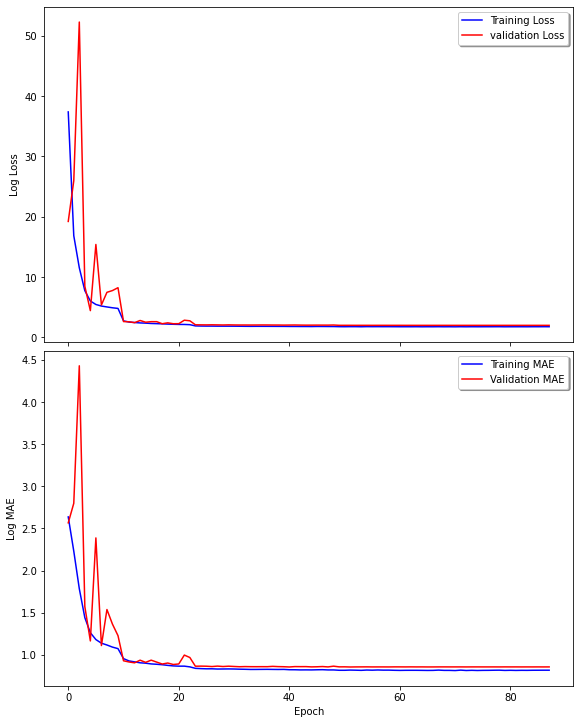

In [113]:
# Presenting the performance of the model in training
plot_hist(hist_final_reg)

Predicted average MAE with using Train data: 0.7020836712269155
Predicted average MAE with using Dev data: 0.8679619713907609


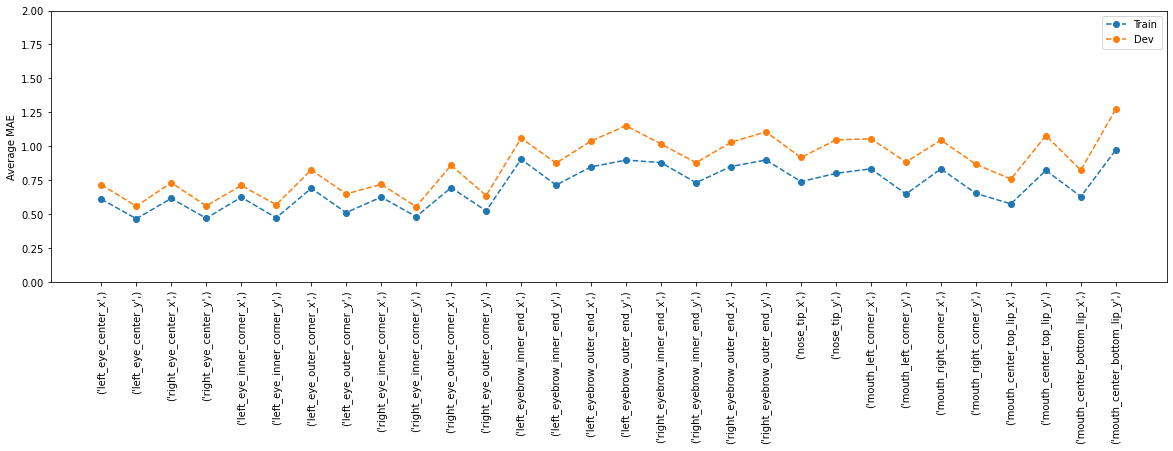

In [116]:
# Error analysis
Yfinal_pred_dev, dfinal = error_analysis(model_final_reg, Xfa_train, Xfa_dev, Yfa_train, Yfa_dev, keypoints_list_full)

## Predicting on Final Test Set with the best model (with regularization)

In [65]:
Xt = df_final_test.iloc[:, -1]
# We need to reshape the input data in a way that each image is presented as a 96x96 matrix
Xt1 = reshape_inputs(Xt)

In [117]:
# We use our best model with regularization for better prediction on test data
Yt_pred = model_final_reg.predict(Xt1)

1476


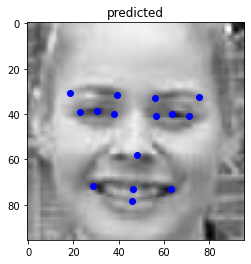

626


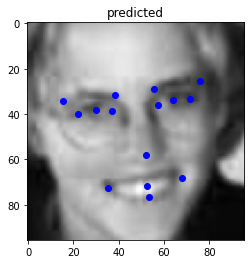

418


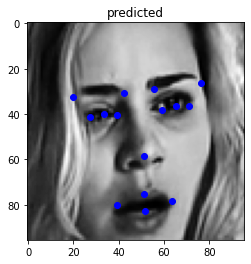

304


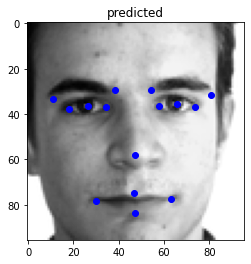

69


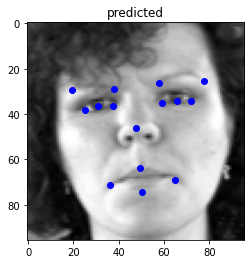

1390


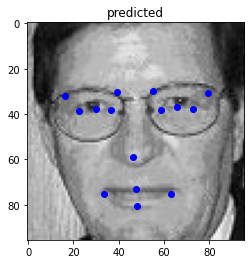

252


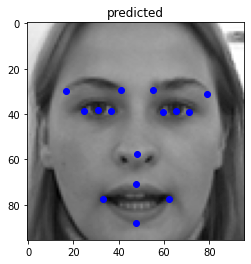

1325


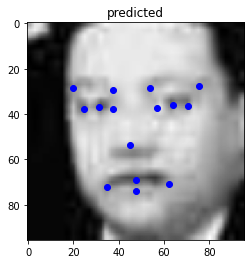

1447


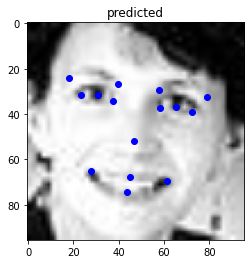

1549


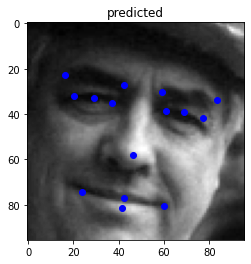

In [118]:
# show the predicted and truly labeled keypoints for random datapoint in the dev dataset
for i in range(10):
    n = np.random.randint(len(Yt_pred))
    print(n)
    plot_facial_keypoints(Xt1[n],Yt_pred[n]+Yfas_mean, 'b', 'predicted')